# Модель "Прогнозирование увольнения работников"

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import statistics
import missingno as msno
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import numpy as np

from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score, f1_score, make_scorer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## 1. Первичный просмотр данных

In [2]:
# Загрузка датасета
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
print('размерность:',df.shape)
df.head()

размерность: (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [3]:
# функция выведения уникальных значения для каждой колонки циклом
def print_info(df):
    for column in df.columns:
        print('Характеристика:', column)
        print('Количество уникальных значений:', df[column].nunique())
        print('Список значений:')
        print(df[column].value_counts())
        print()

In [4]:
print_info(df)

Характеристика: Age
Количество уникальных значений: 43
Список значений:
Age
35    78
34    77
36    69
31    69
29    68
32    61
30    60
33    58
38    58
40    57
37    50
27    48
28    48
42    46
39    42
45    41
41    40
26    39
44    33
46    33
43    32
50    30
25    26
24    26
49    24
47    24
55    22
51    19
53    19
48    19
54    18
52    18
22    16
56    14
23    14
58    14
21    13
20    11
59    10
19     9
18     8
60     5
57     4
Name: count, dtype: int64

Характеристика: Attrition
Количество уникальных значений: 2
Список значений:
Attrition
No     1233
Yes     237
Name: count, dtype: int64

Характеристика: BusinessTravel
Количество уникальных значений: 3
Список значений:
BusinessTravel
Travel_Rarely        1043
Travel_Frequently     277
Non-Travel            150
Name: count, dtype: int64

Характеристика: DailyRate
Количество уникальных значений: 886
Список значений:
DailyRate
691     6
408     5
530     5
1329    5
1082    5
       ..
650     1
279     1
3

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [6]:
# проверяем на наличие Дубликатов
df[df.duplicated()]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager


Выводы:
Не все признаки будем брать для моделирования 

Удаление признаков осуществляем по 2 категориям: 

Неинформативный признак ('EmployeeCount', 'Over18', 'StandardHours'), 

Признак создающий мультиколлинеарность('YearsAtCompany', 'TotalWorkingYears', 'JobLevel', 'PerformanceRating', 'YearsWithCurrManager').###


## Визуализации и зависимости

In [33]:
# Рассчет матрици корреляции и тепловой карты для неё

In [34]:
corr = df.corr().round(4)

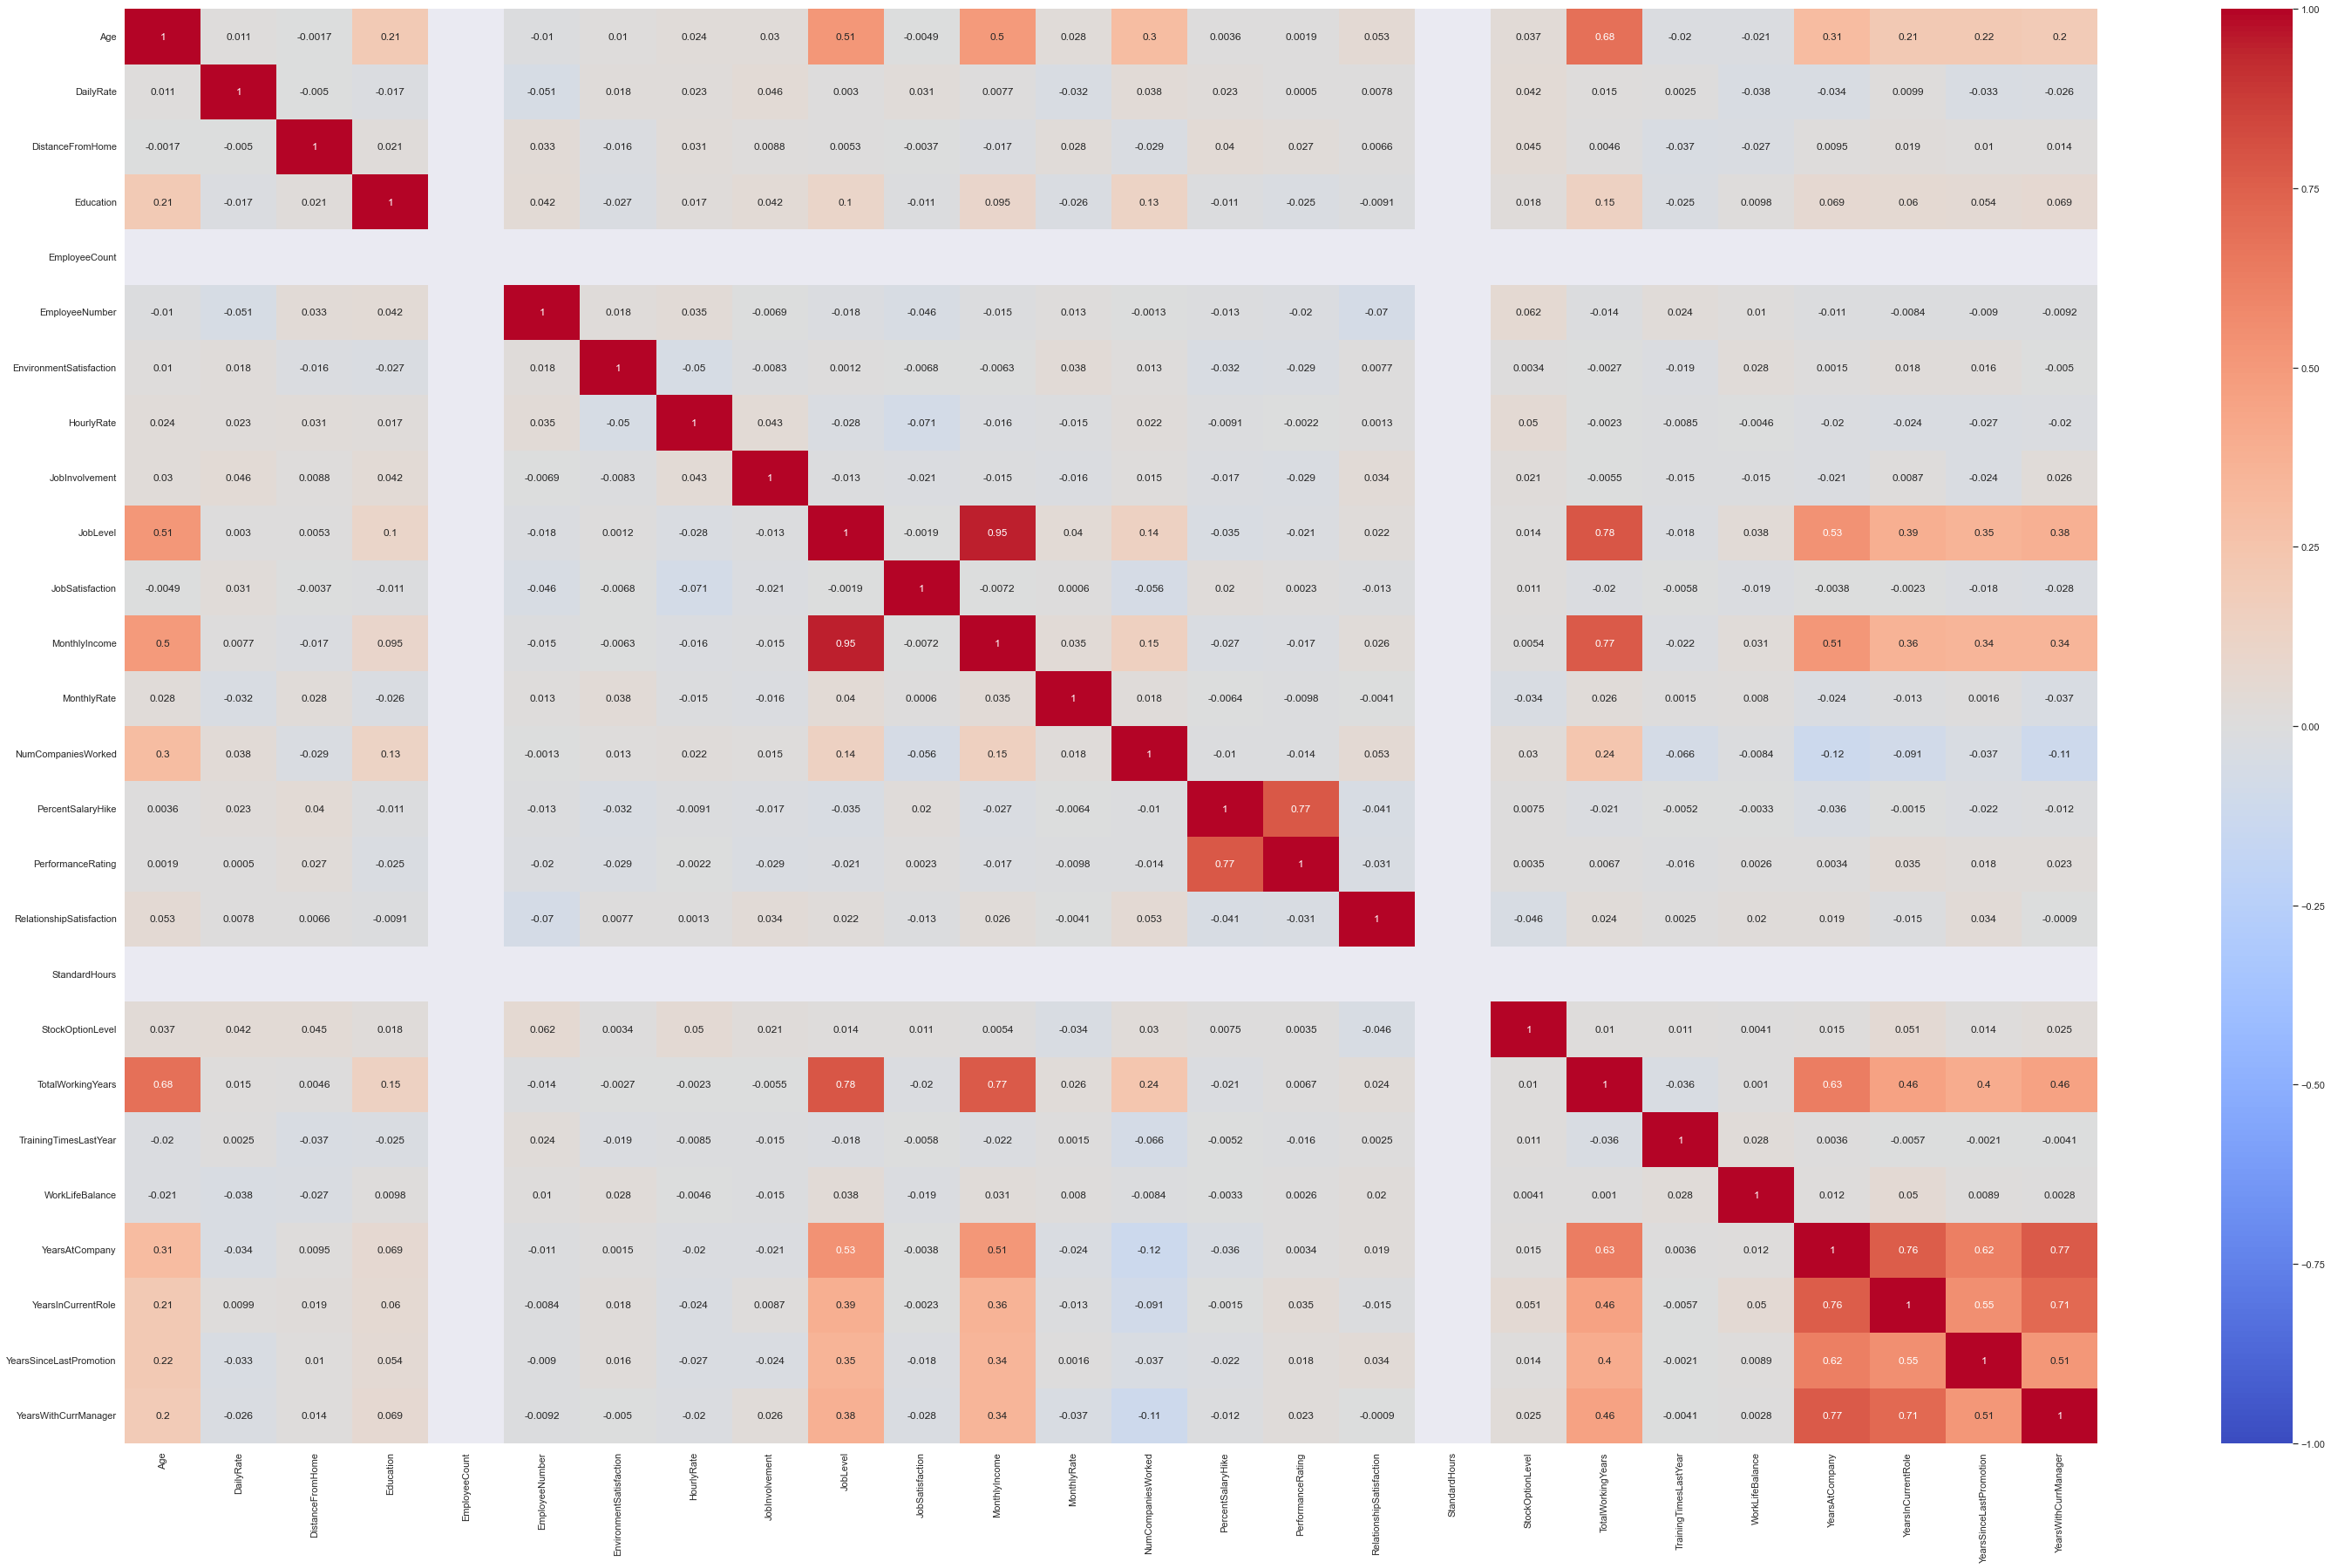

In [35]:
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
sns.set(rc={'figure.figsize':(50.7, 30.27)})

In [7]:
df1 = df.copy()

In [8]:
#  Устраняем мультиколлинеарность
df1.drop(columns=['YearsAtCompany', 'TotalWorkingYears', 'JobLevel'] , inplace=True)

In [9]:
df1.drop(columns=['PerformanceRating', 'YearsWithCurrManager'] , inplace=True)

In [10]:
# Удаляем неинформативные столбцы
df1.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'] , inplace=True)

In [11]:
df1

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,19479,8,Yes,11,1,0,0,1,4,0
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,24907,1,No,23,4,1,3,3,7,1
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,2396,6,Yes,15,2,0,3,3,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,23159,1,Yes,11,3,0,3,3,7,3
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,16632,9,No,12,4,1,3,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,No,Travel_Frequently,884,Research & Development,23,2,Medical,2061,3,...,12290,4,No,17,3,1,3,3,2,0
1466,39,No,Travel_Rarely,613,Research & Development,6,1,Medical,2062,4,...,21457,4,No,15,1,1,5,3,7,1
1467,27,No,Travel_Rarely,155,Research & Development,4,3,Life Sciences,2064,2,...,5174,1,Yes,20,2,1,0,3,2,0
1468,49,No,Travel_Frequently,1023,Sales,2,3,Medical,2065,4,...,13243,2,No,14,4,0,3,2,6,0


In [41]:
corr = df1.corr().round(4)

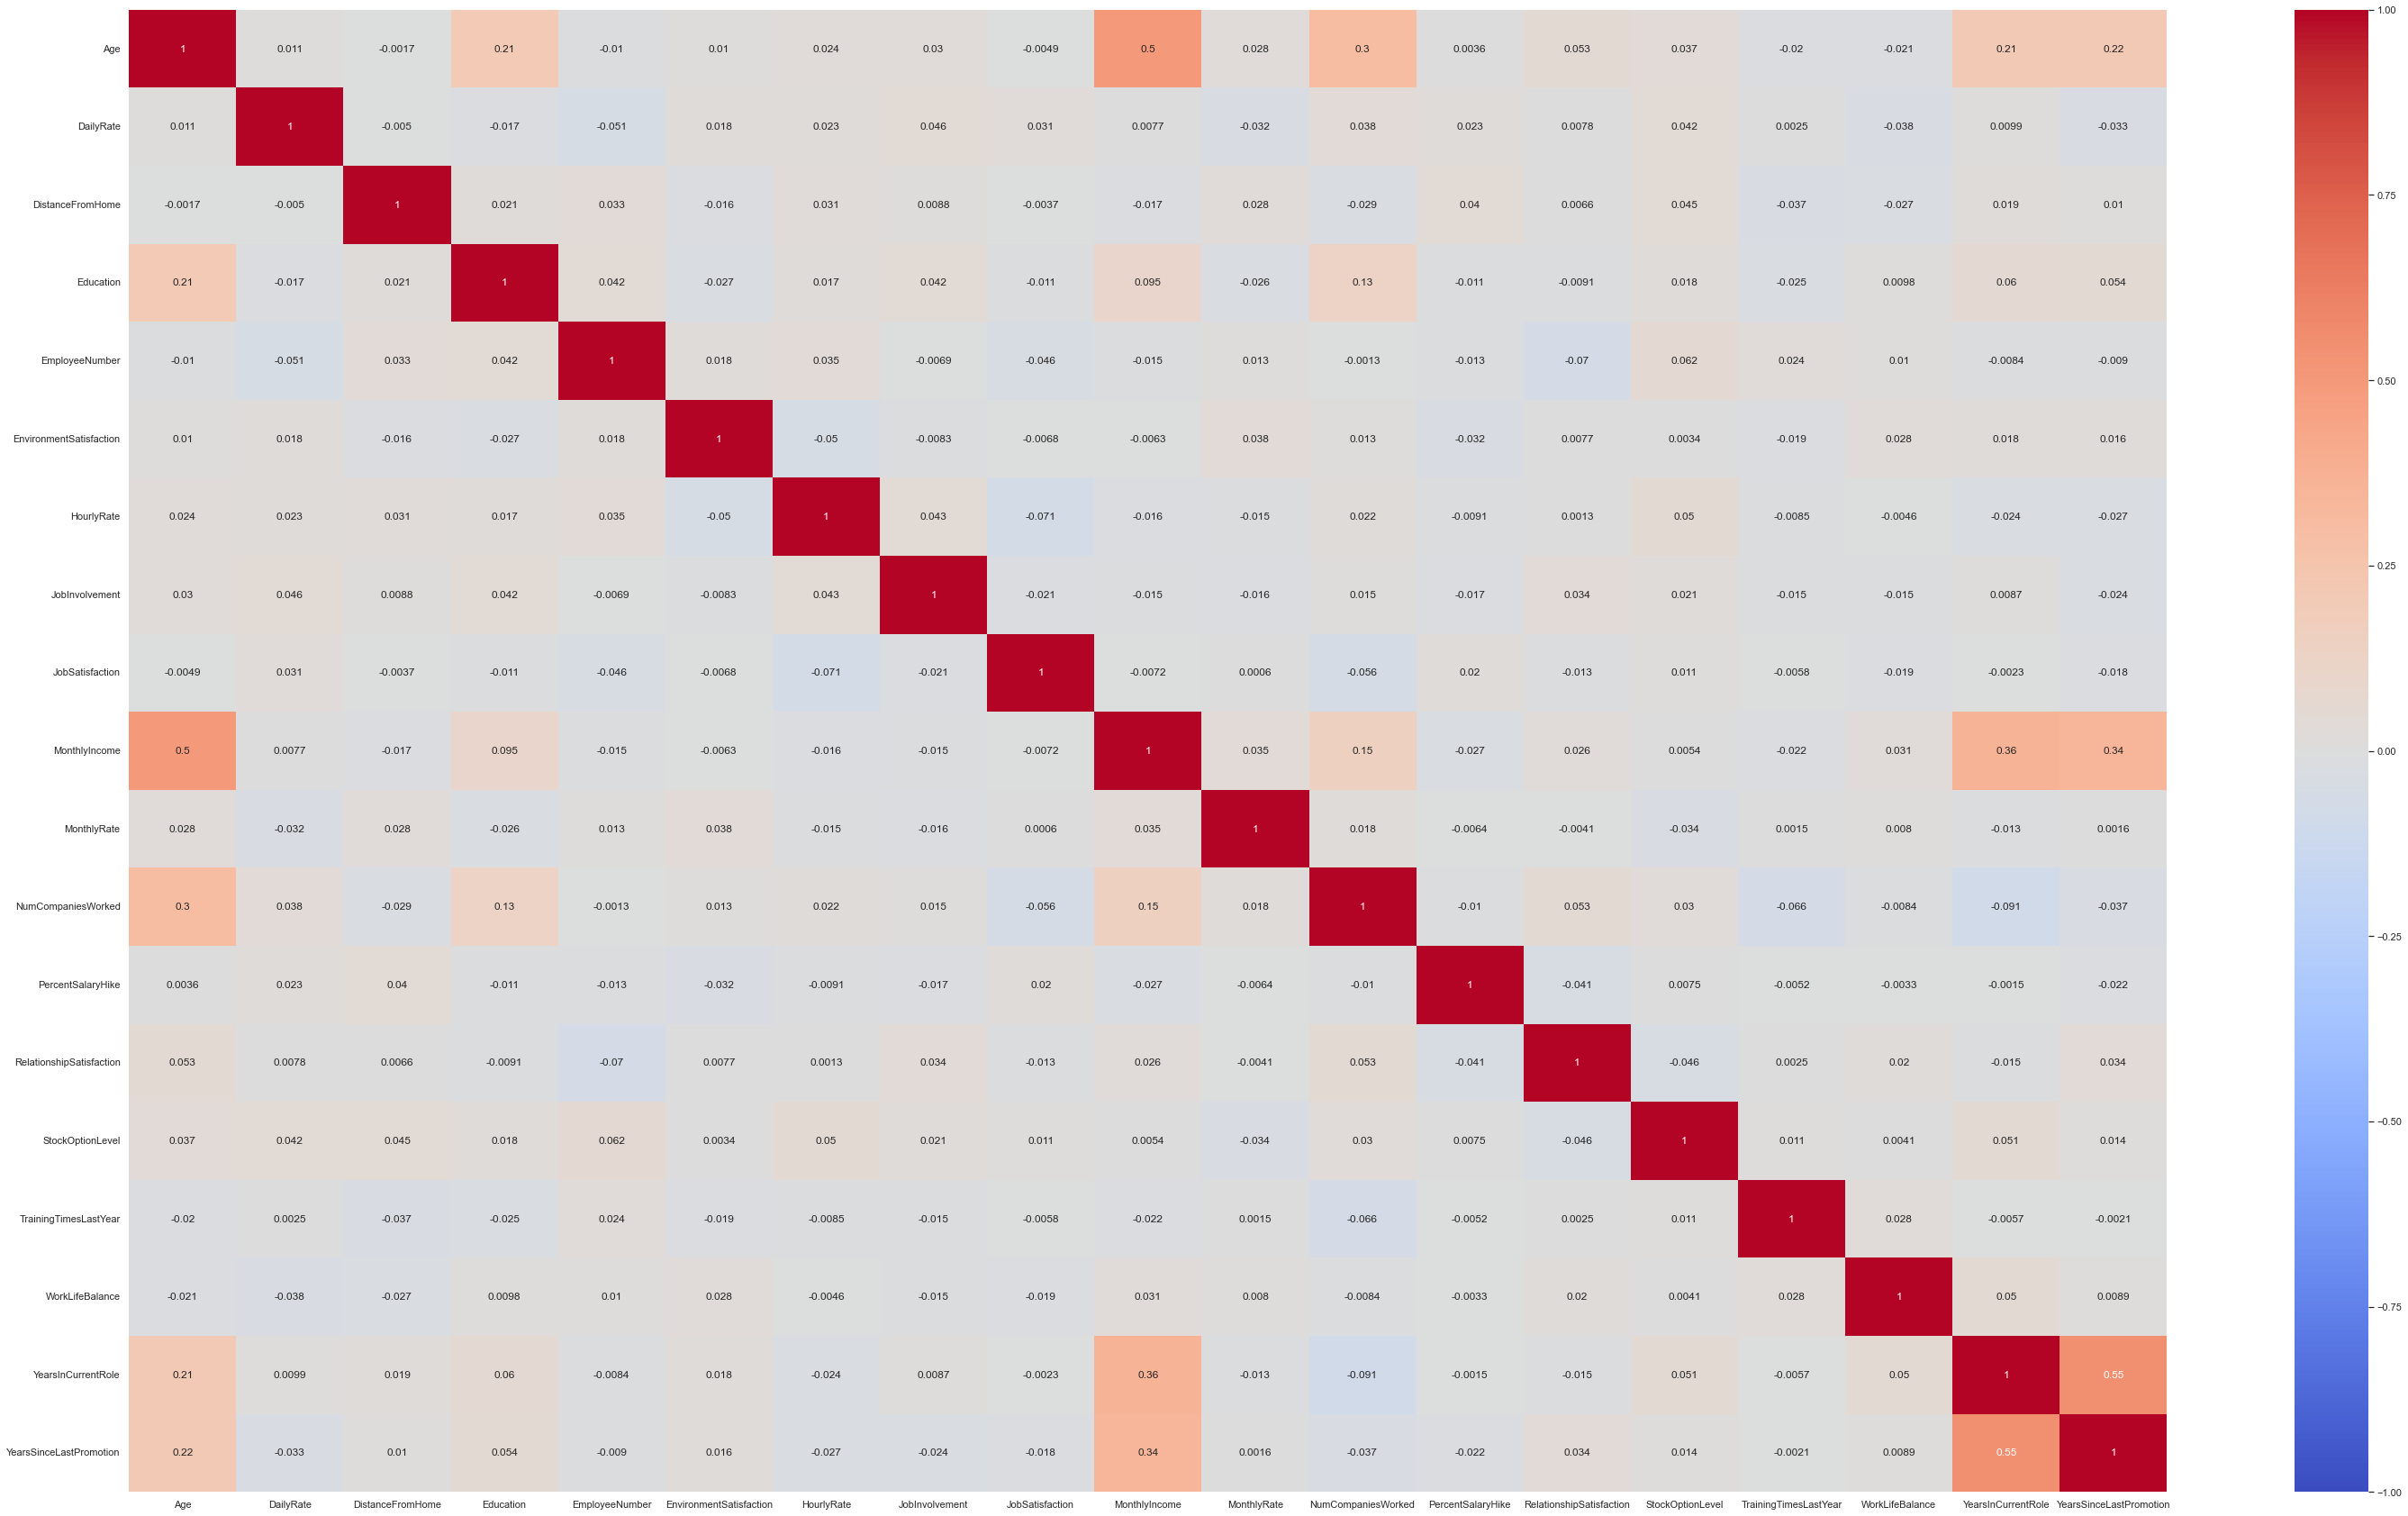

In [42]:
# Тепловая карта для обновлённого датафрейма, связи ниже 0,7
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
sns.set(rc={'figure.figsize':(50.7, 30.27)})

In [12]:
list_atribut = df1.columns.tolist()
list_atribut 

['Age',
 'Attrition',
 'BusinessTravel',
 'DailyRate',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'Gender',
 'HourlyRate',
 'JobInvolvement',
 'JobRole',
 'JobSatisfaction',
 'MaritalStatus',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'OverTime',
 'PercentSalaryHike',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion']

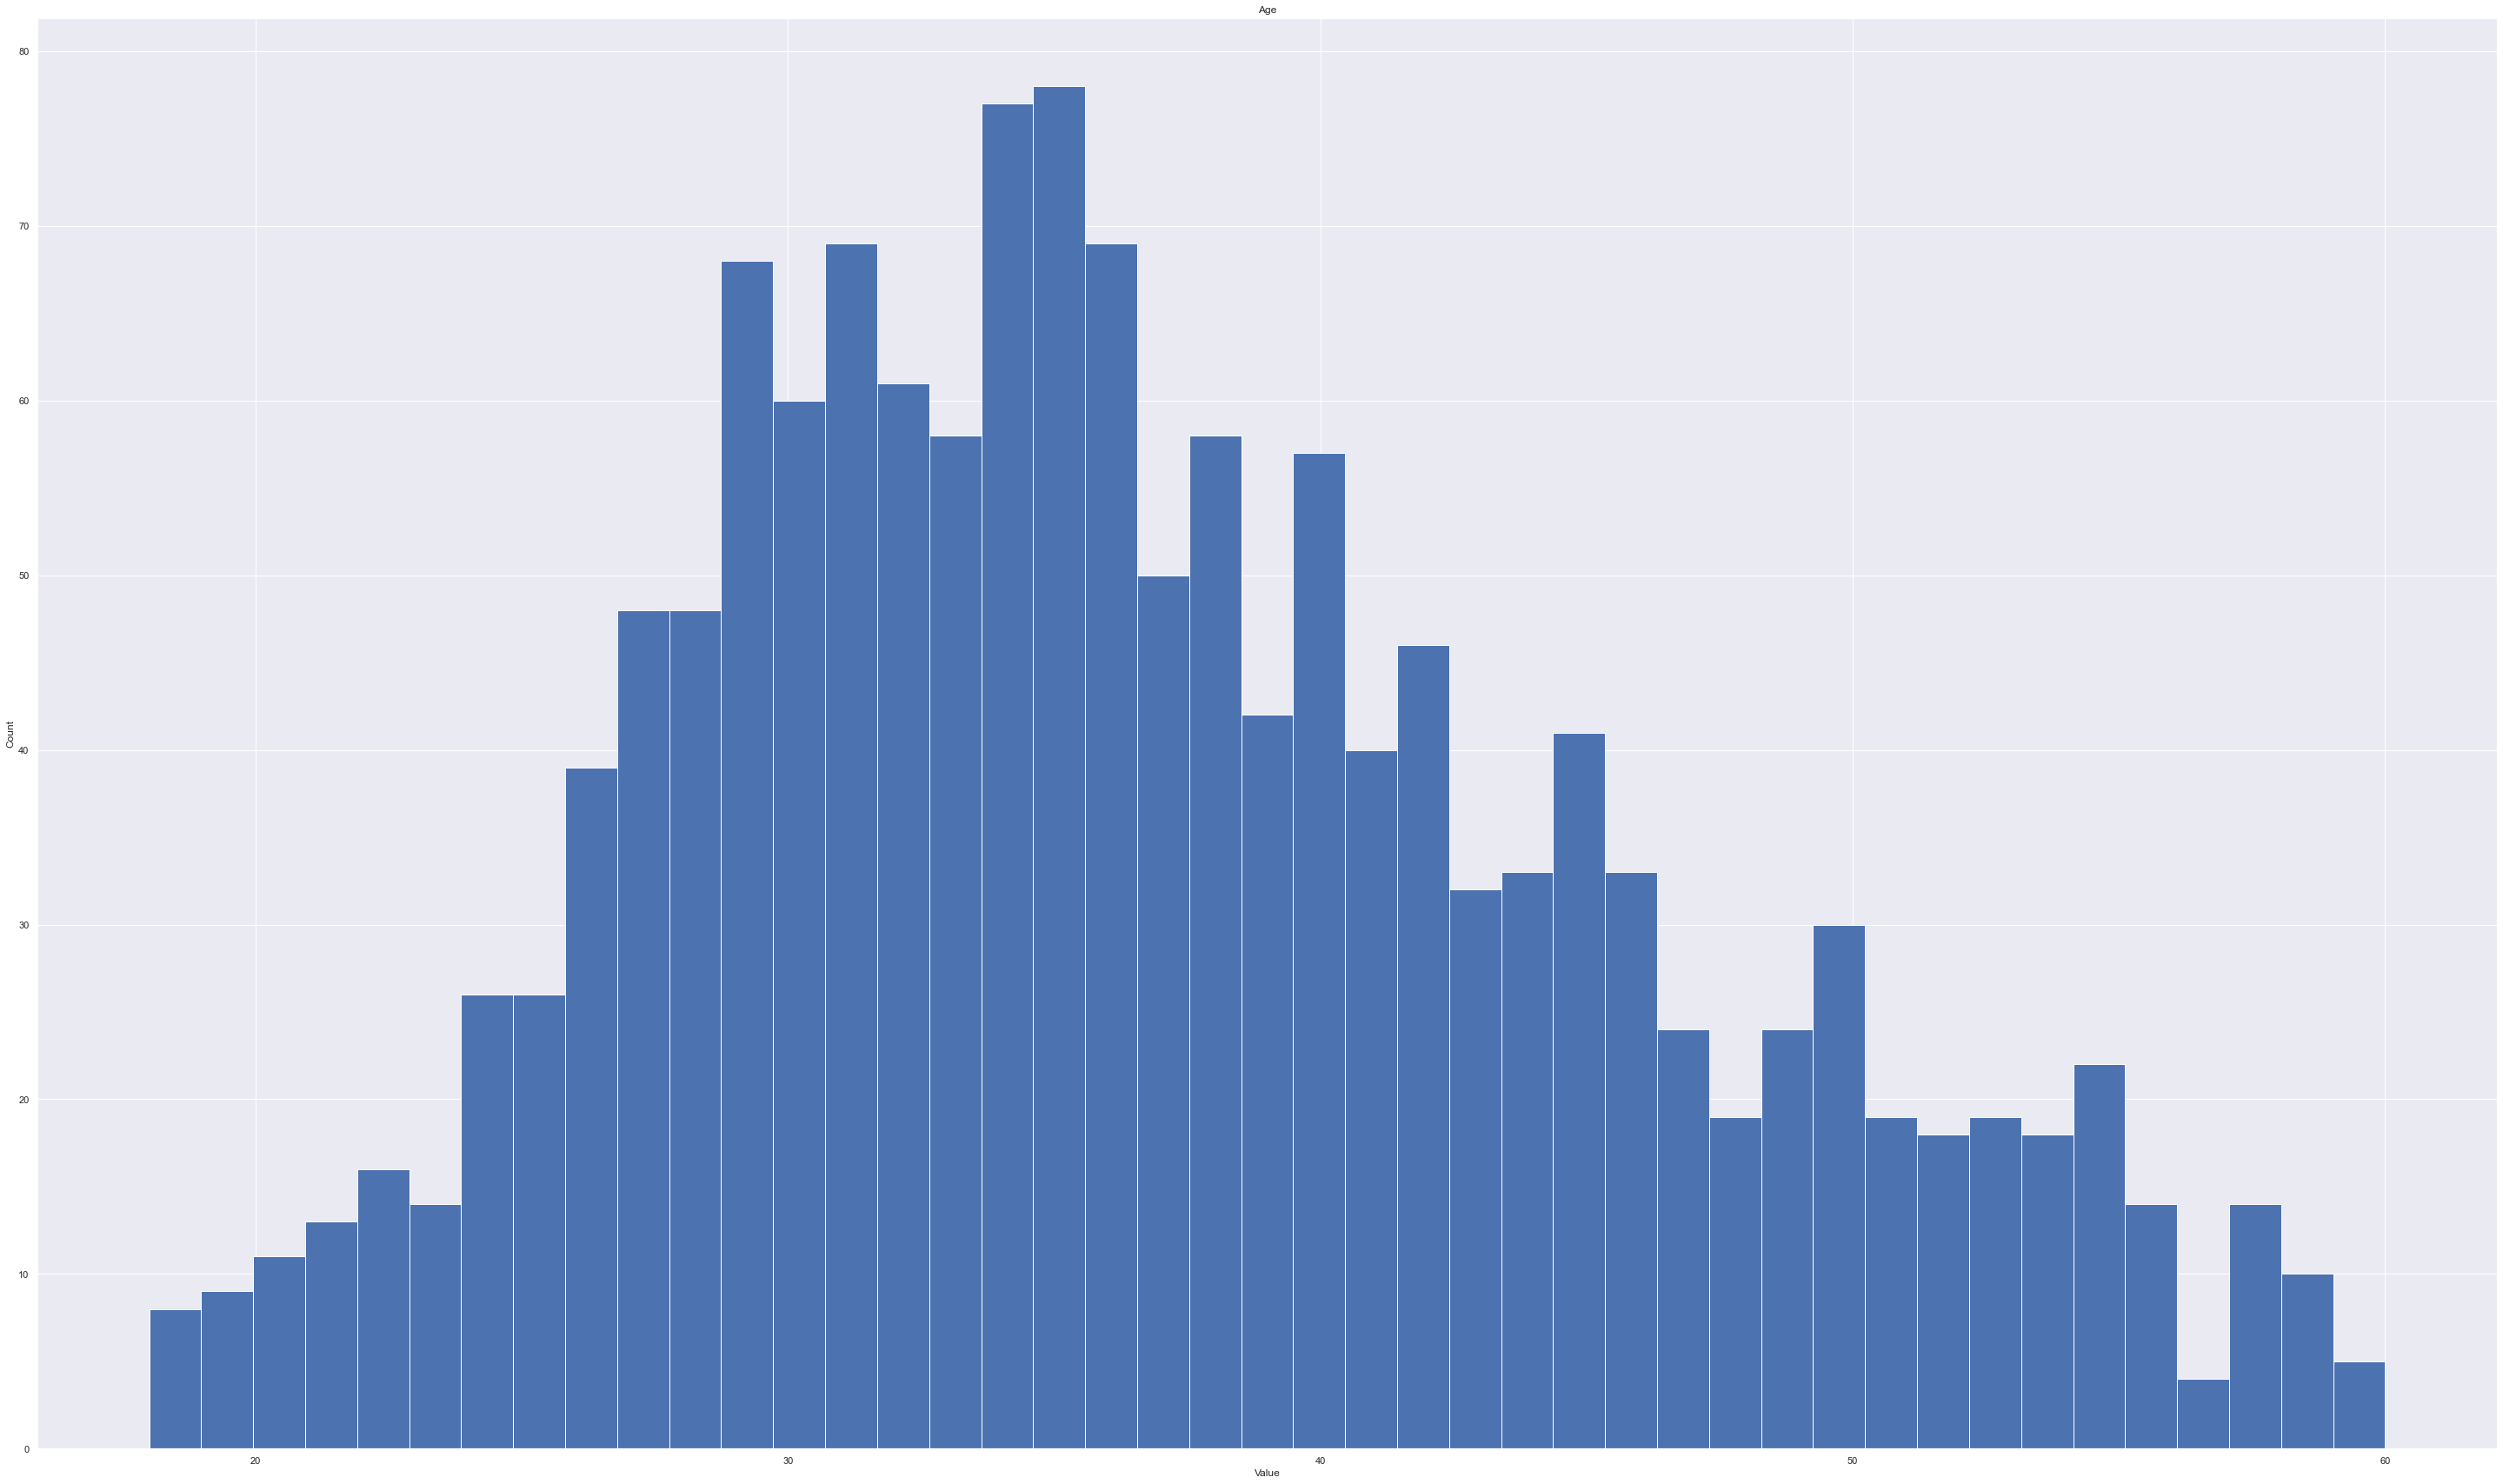

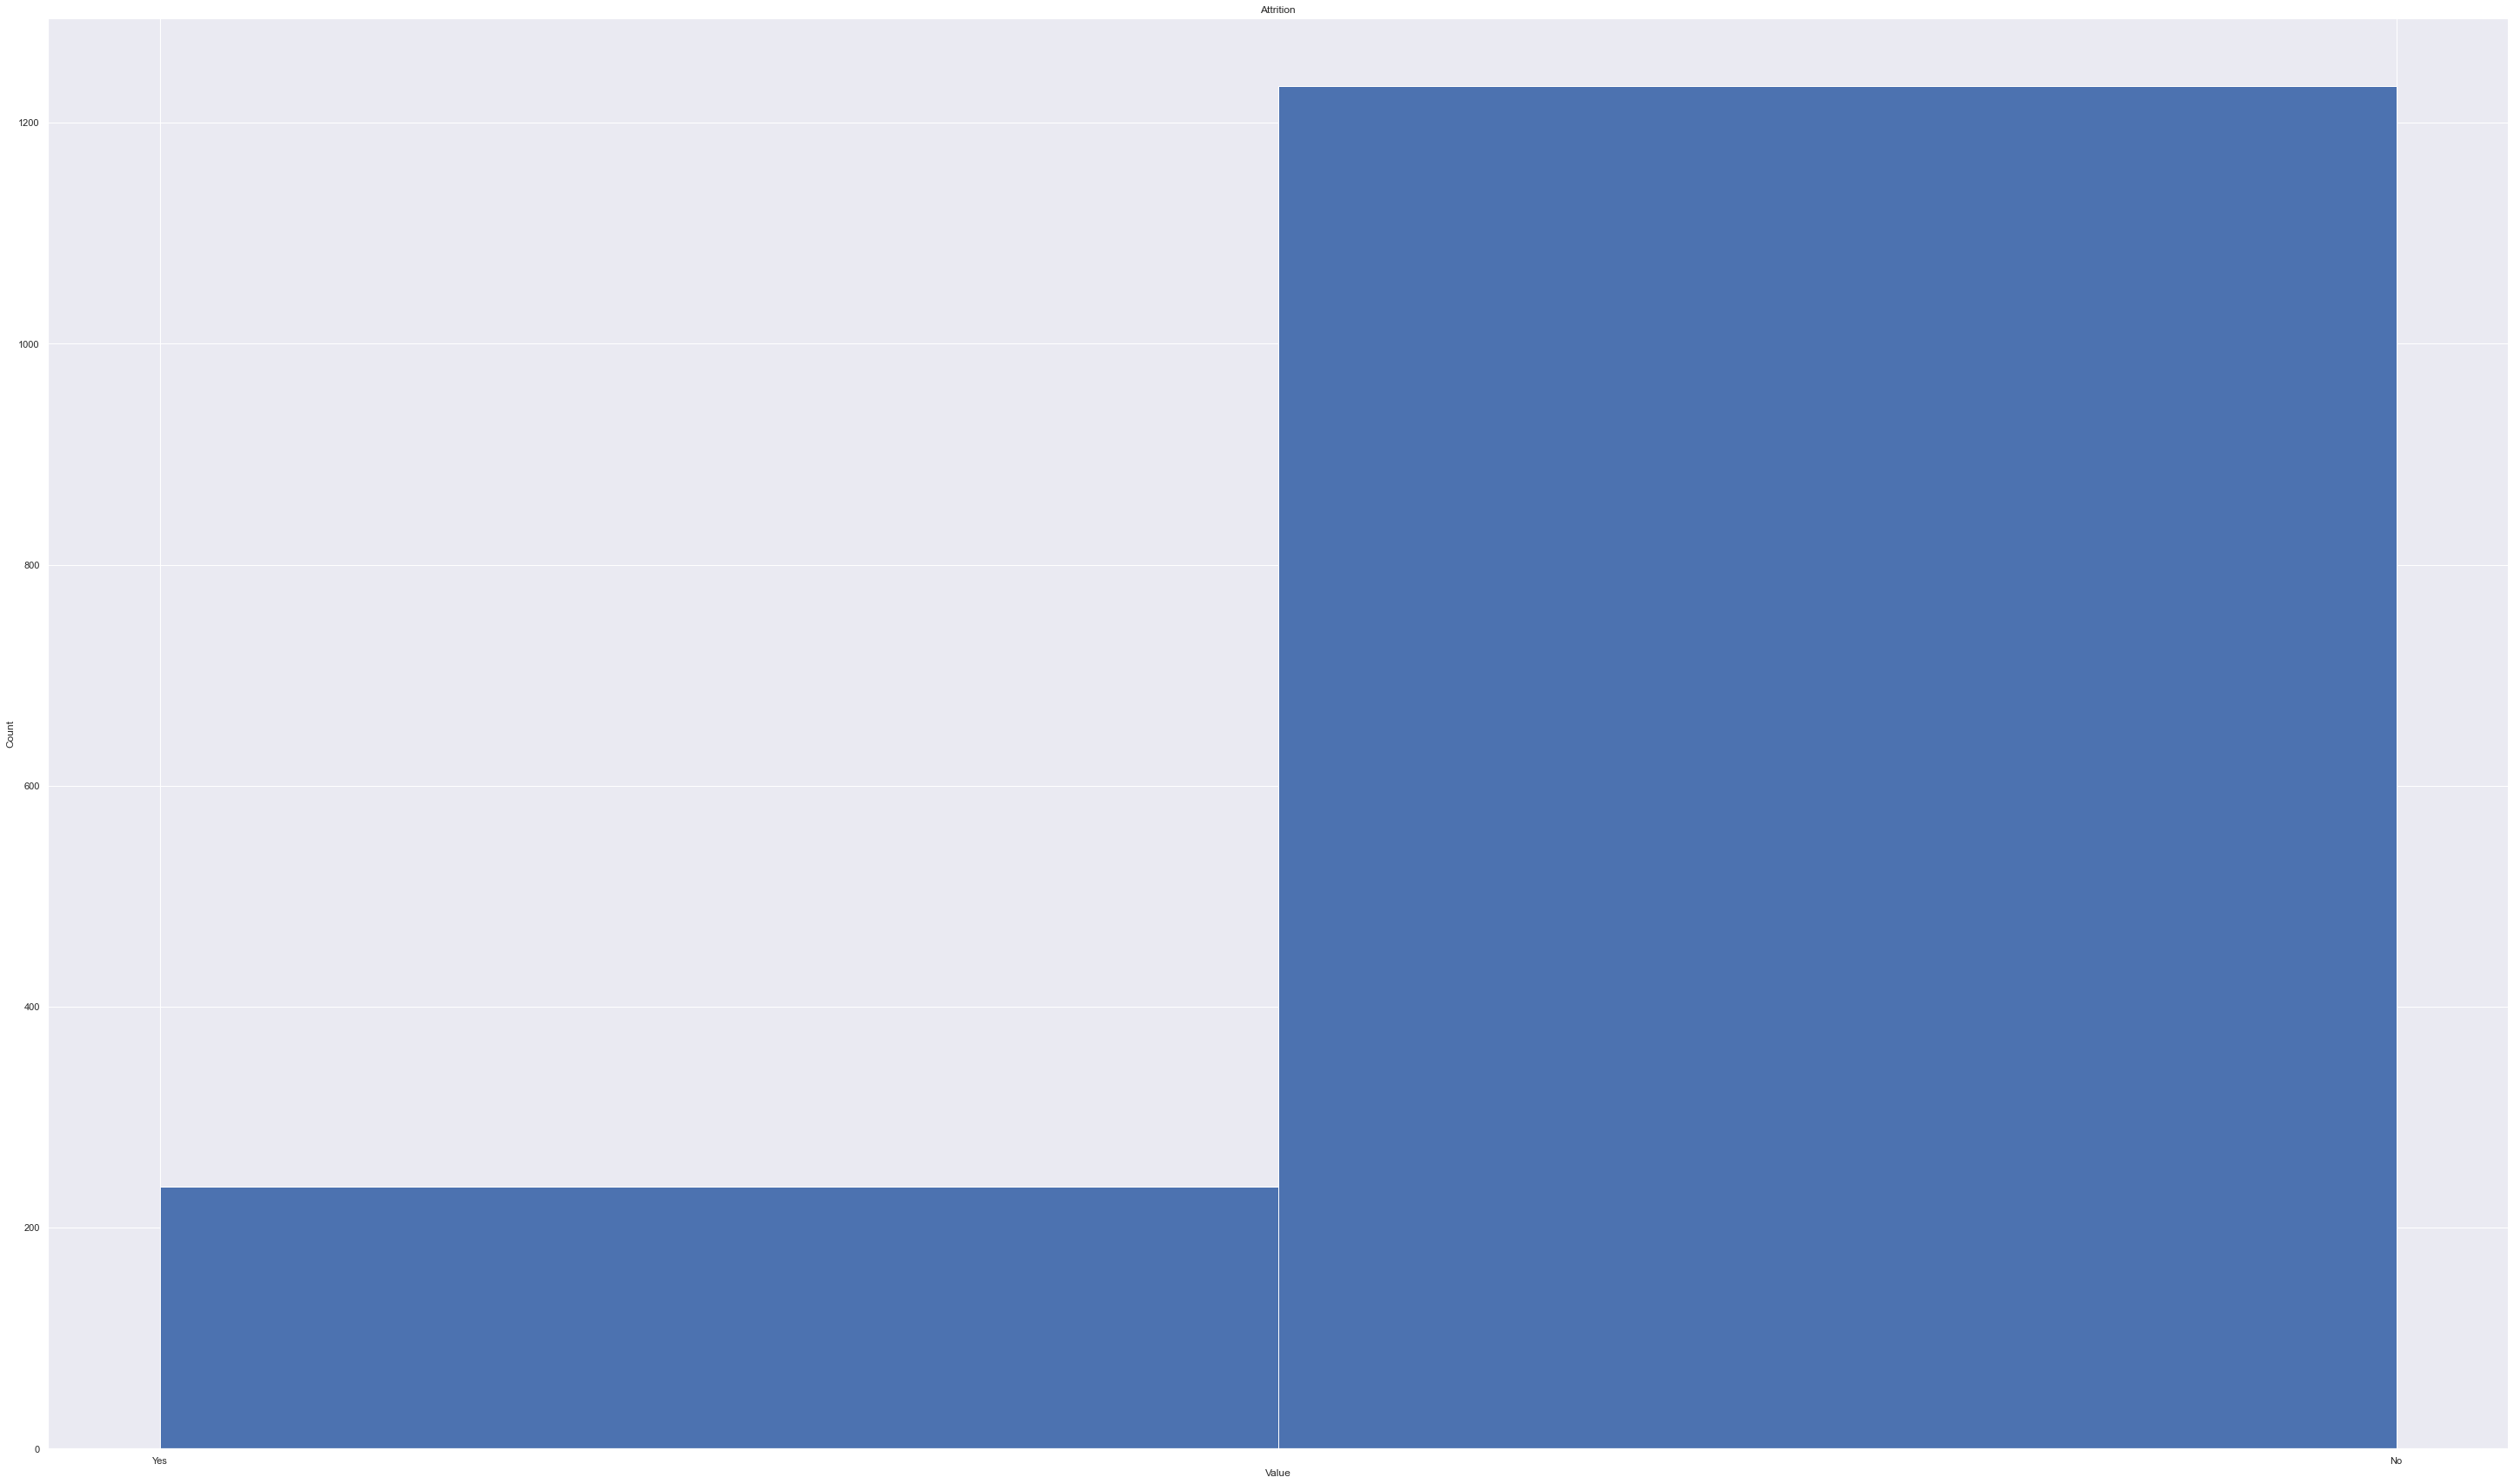

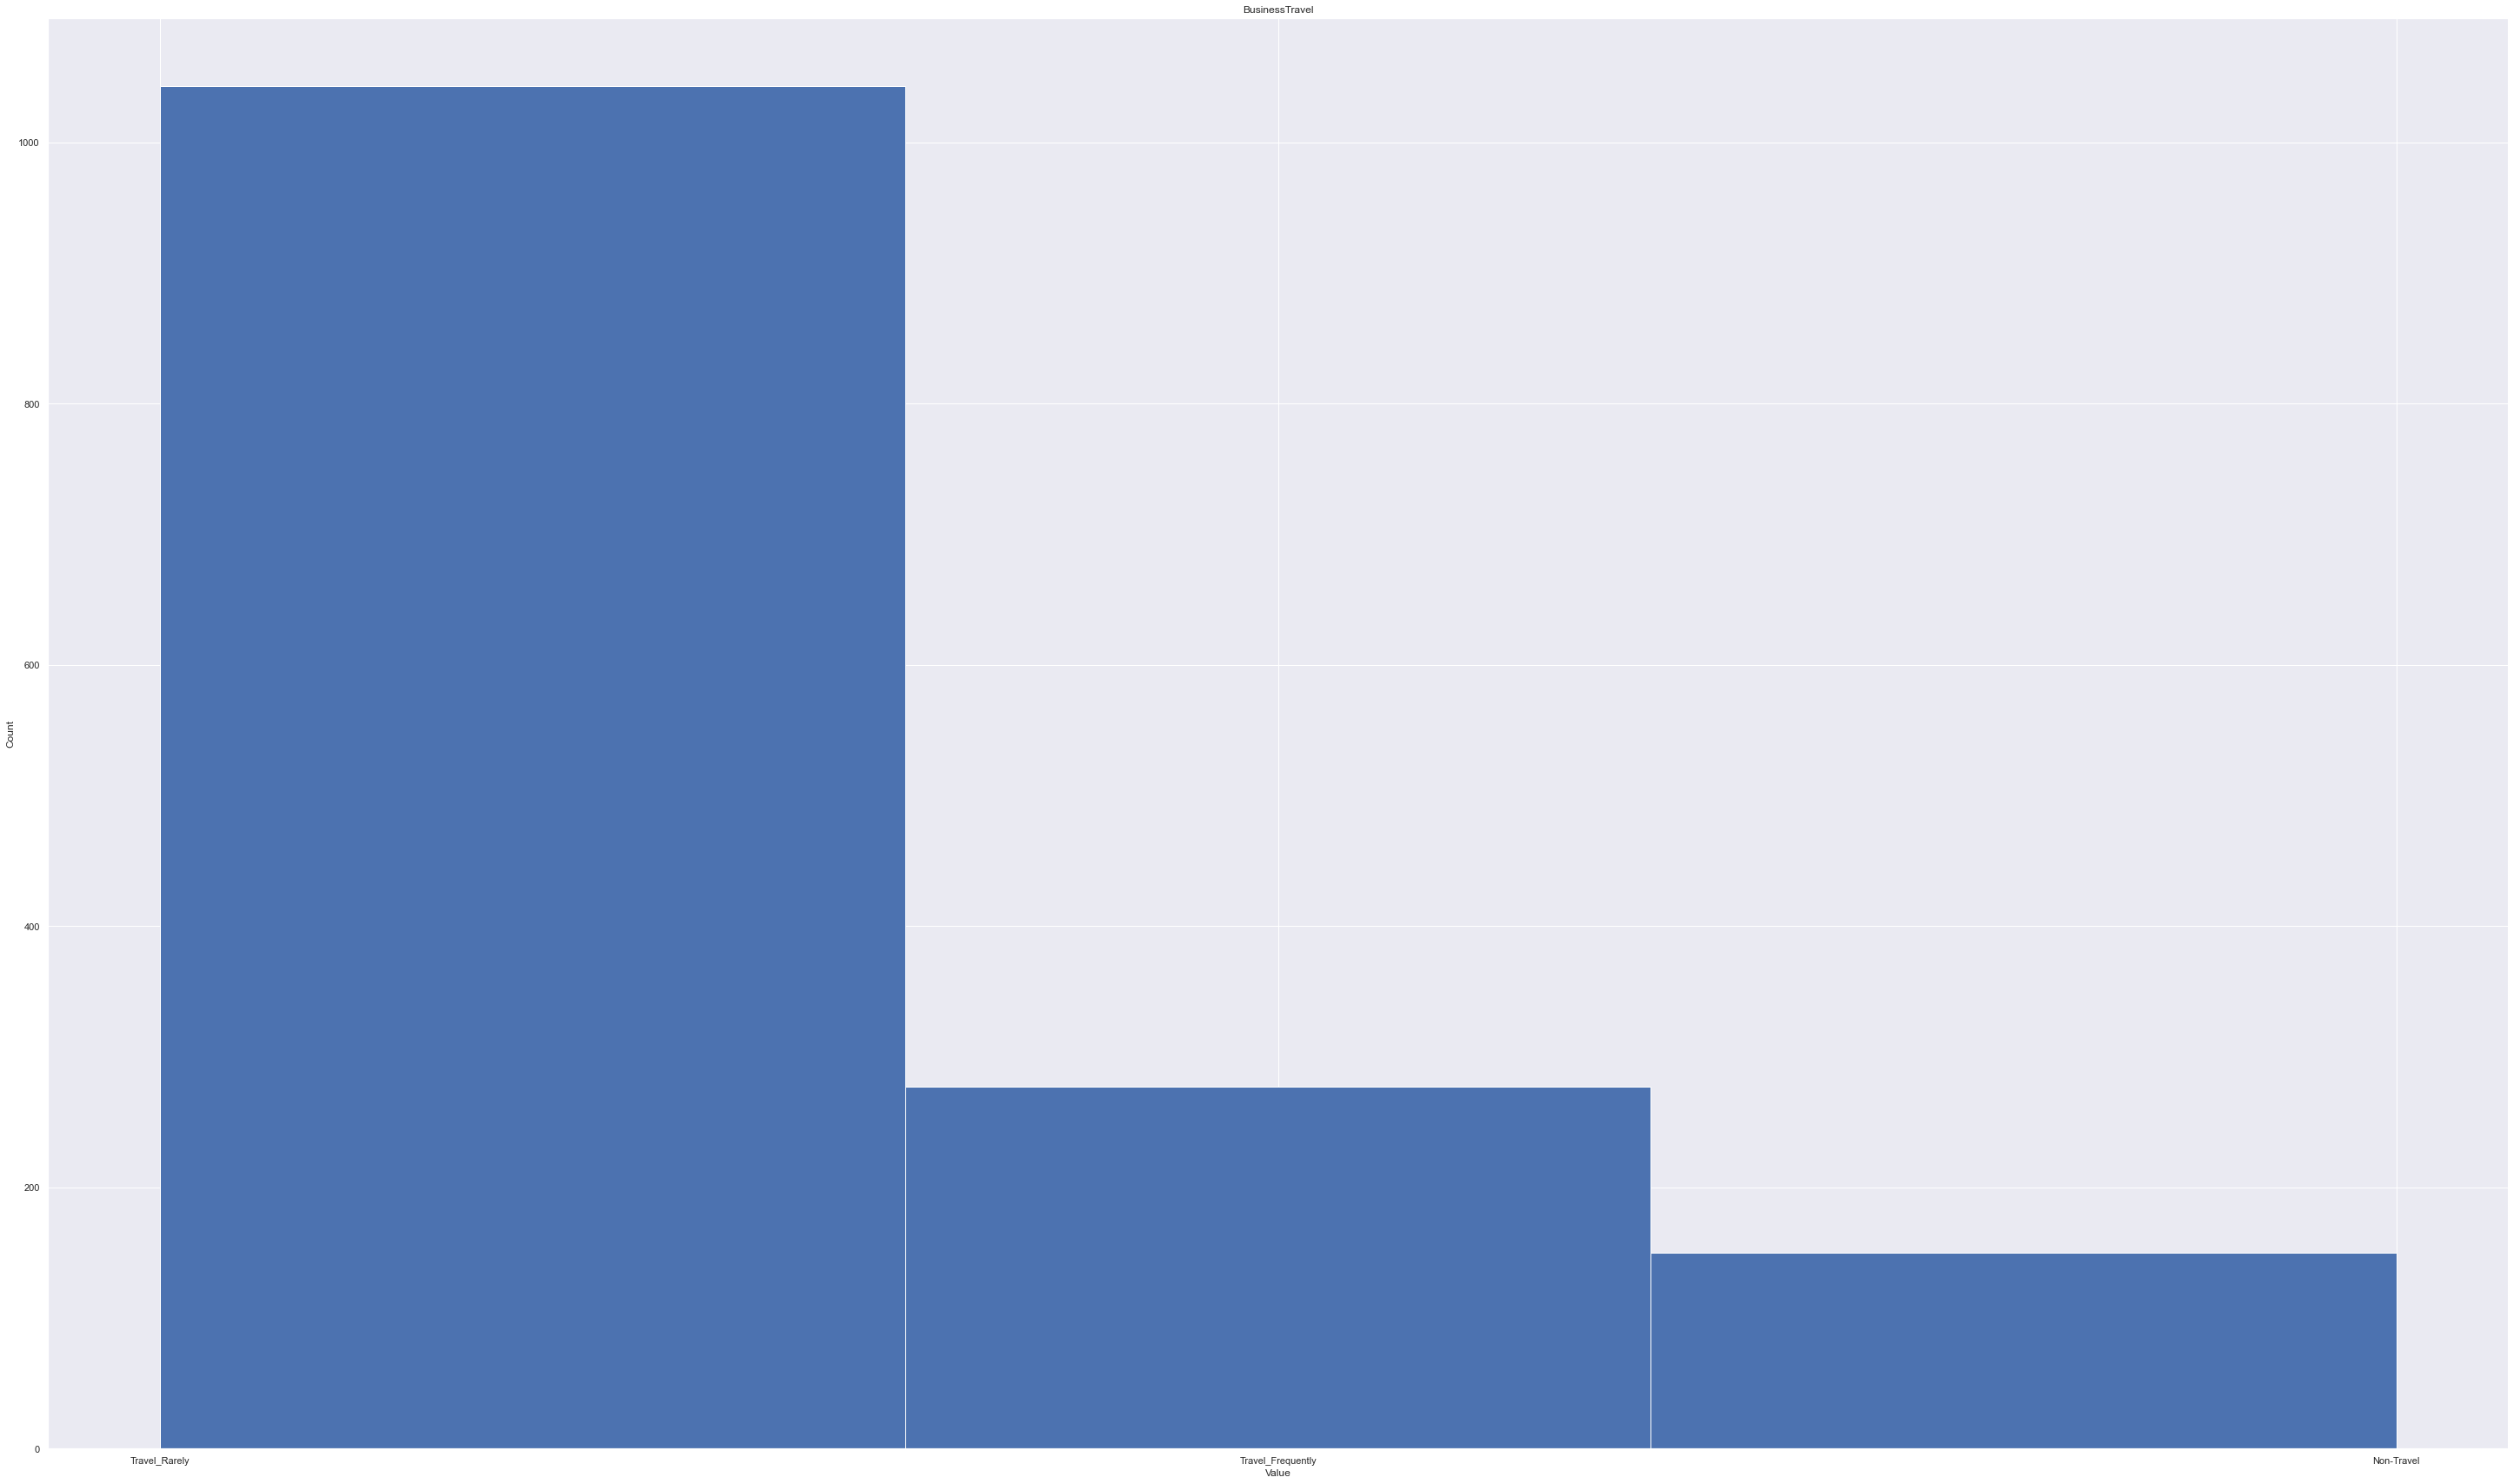

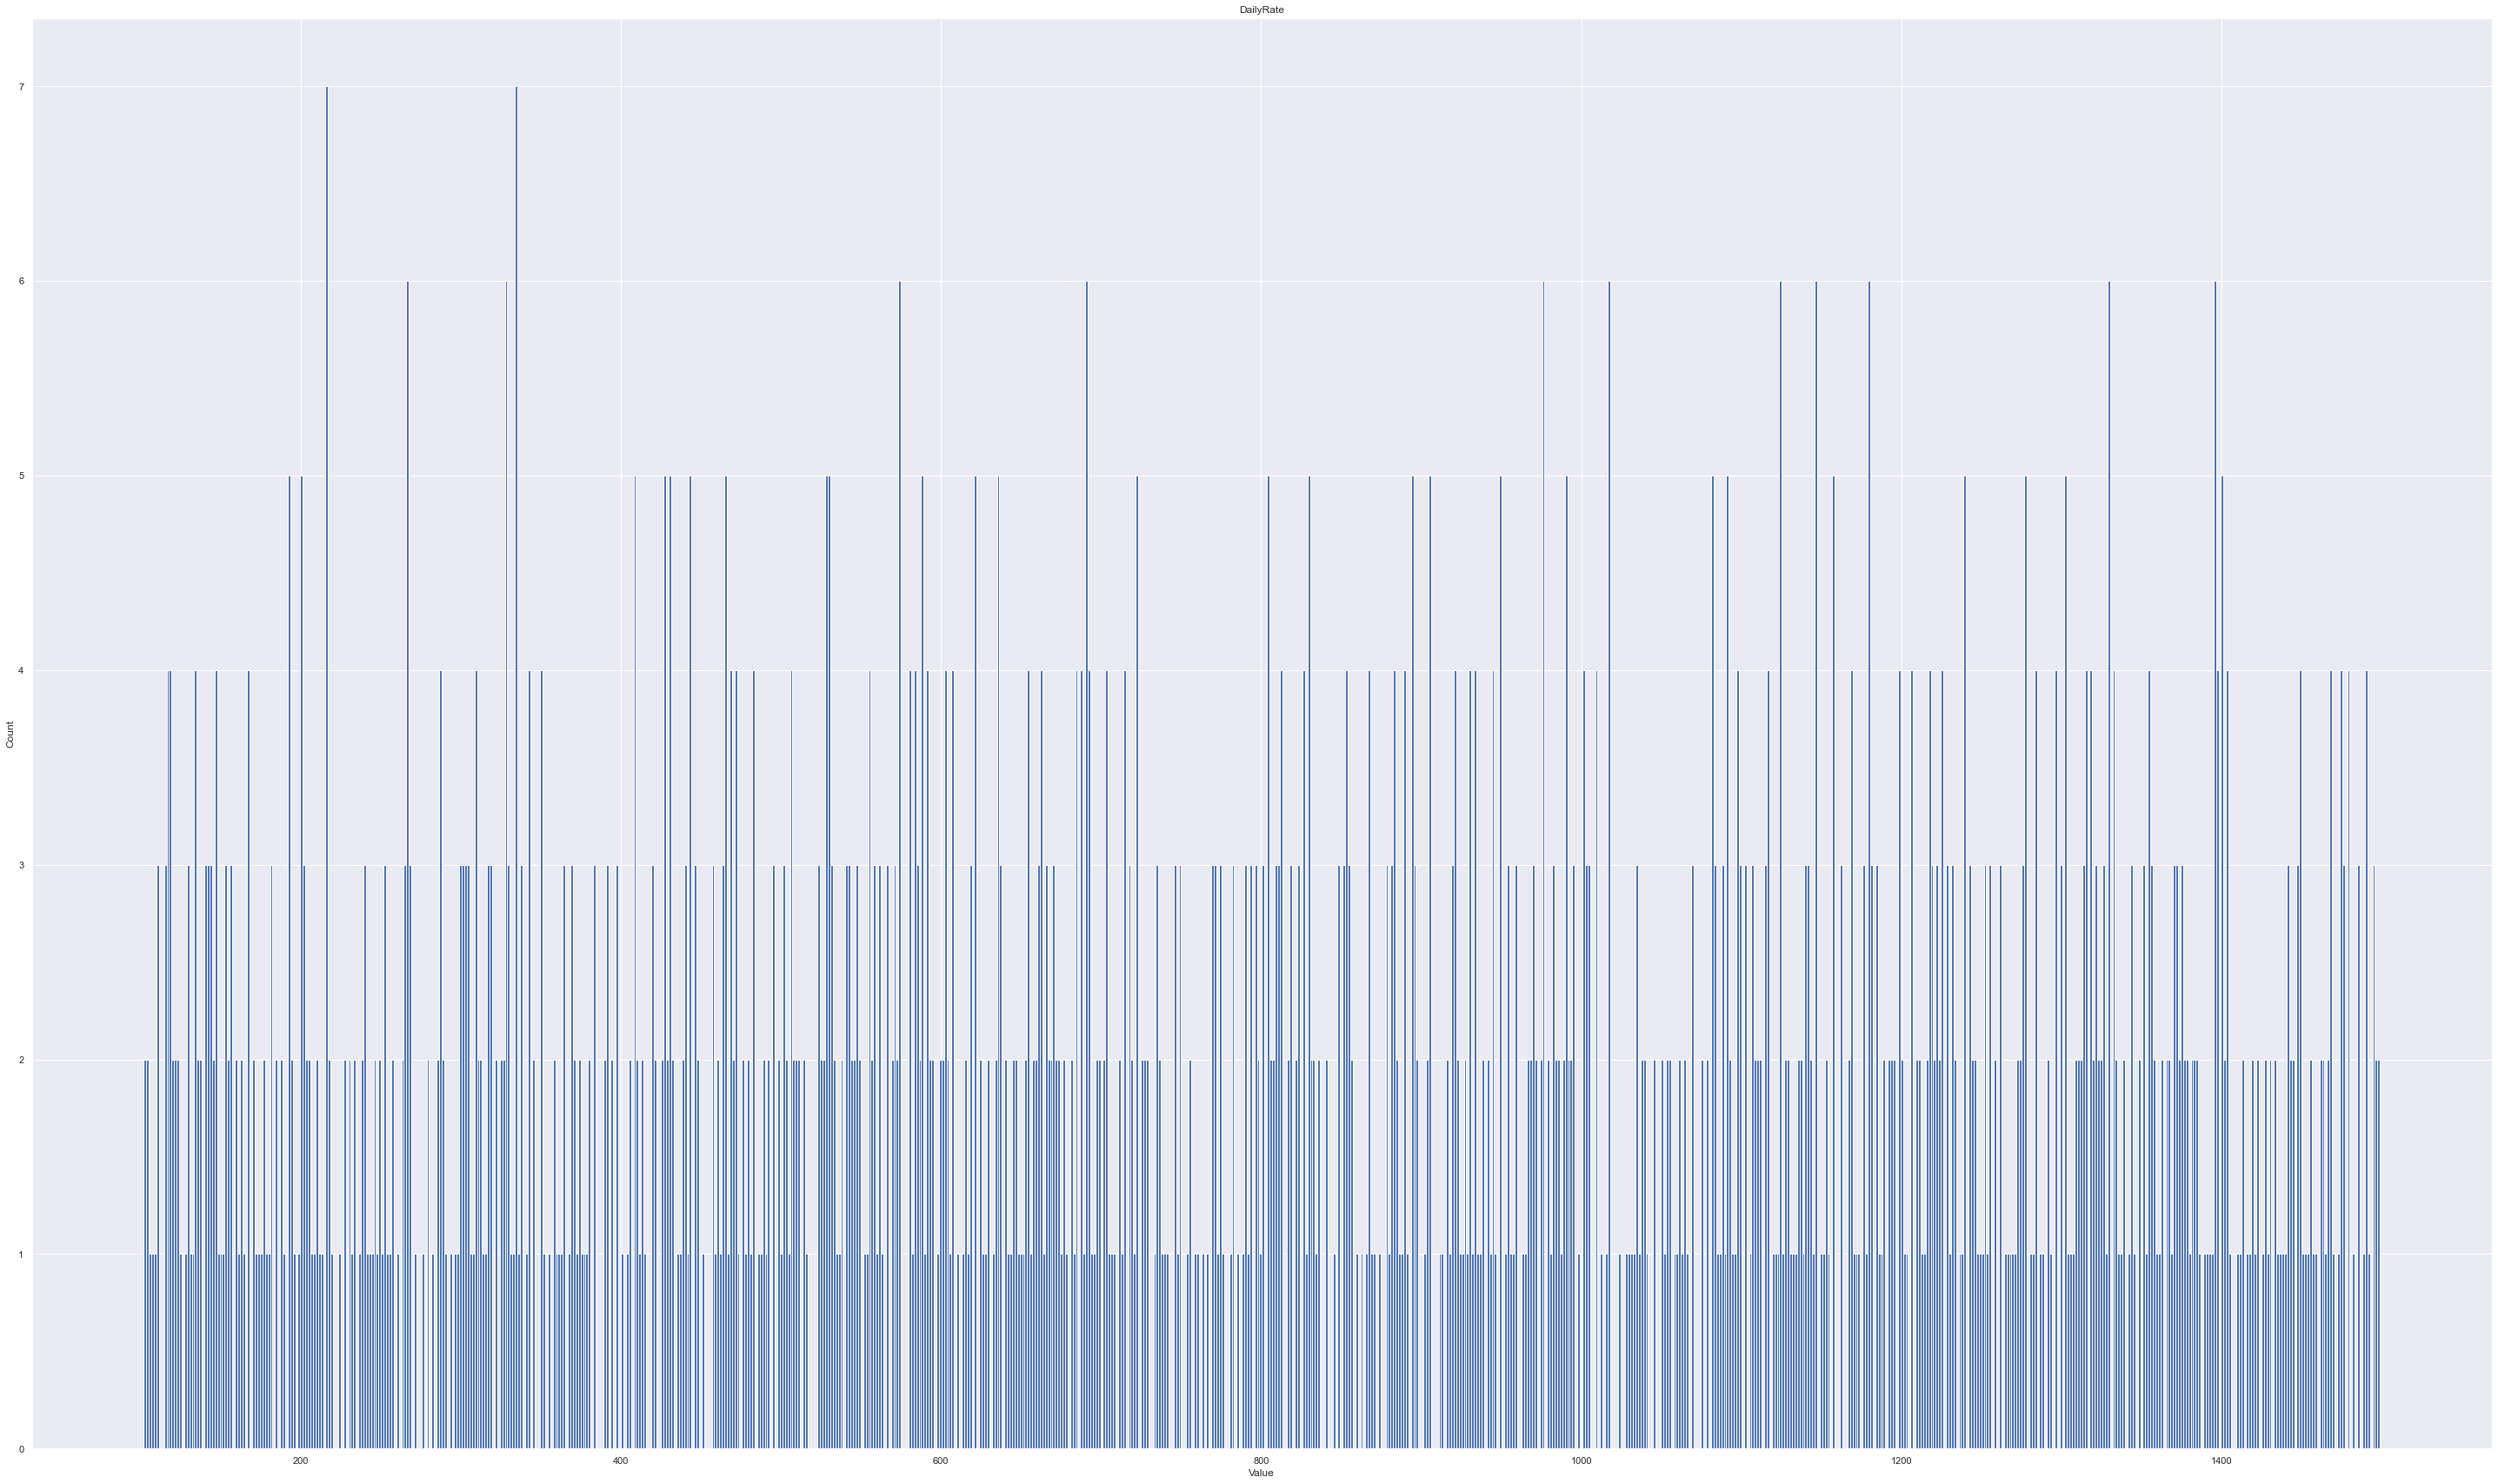

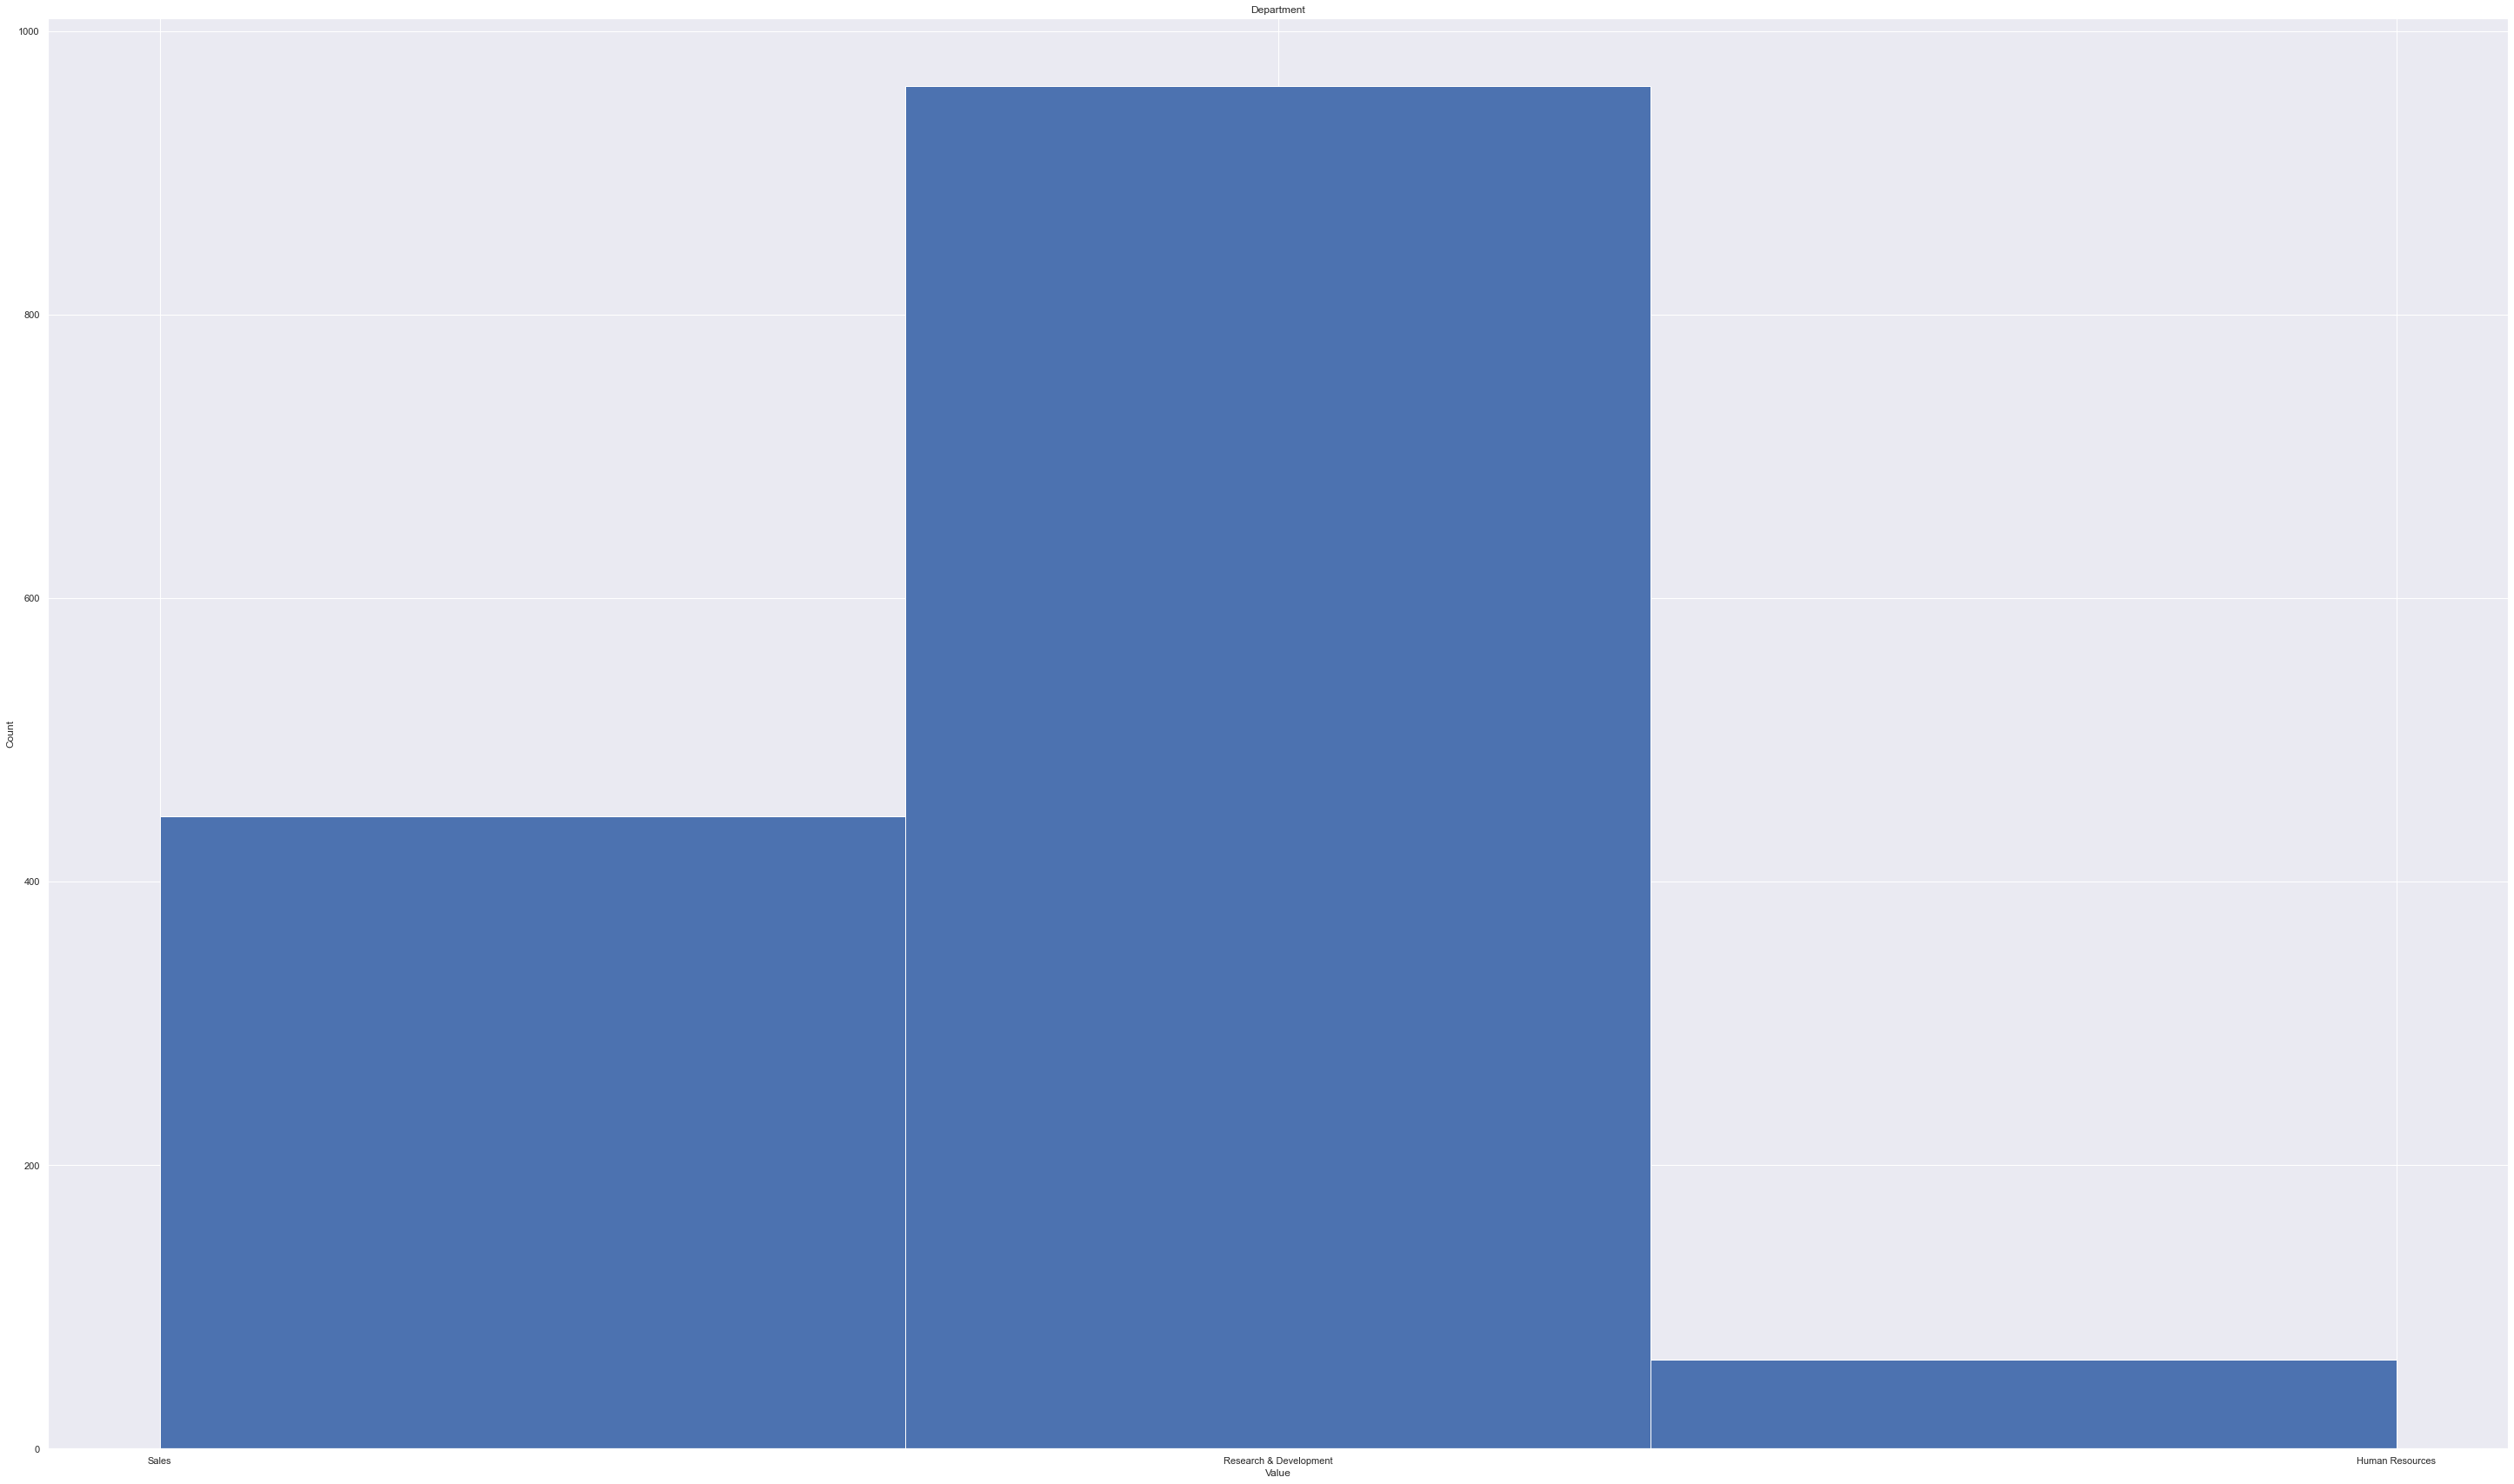

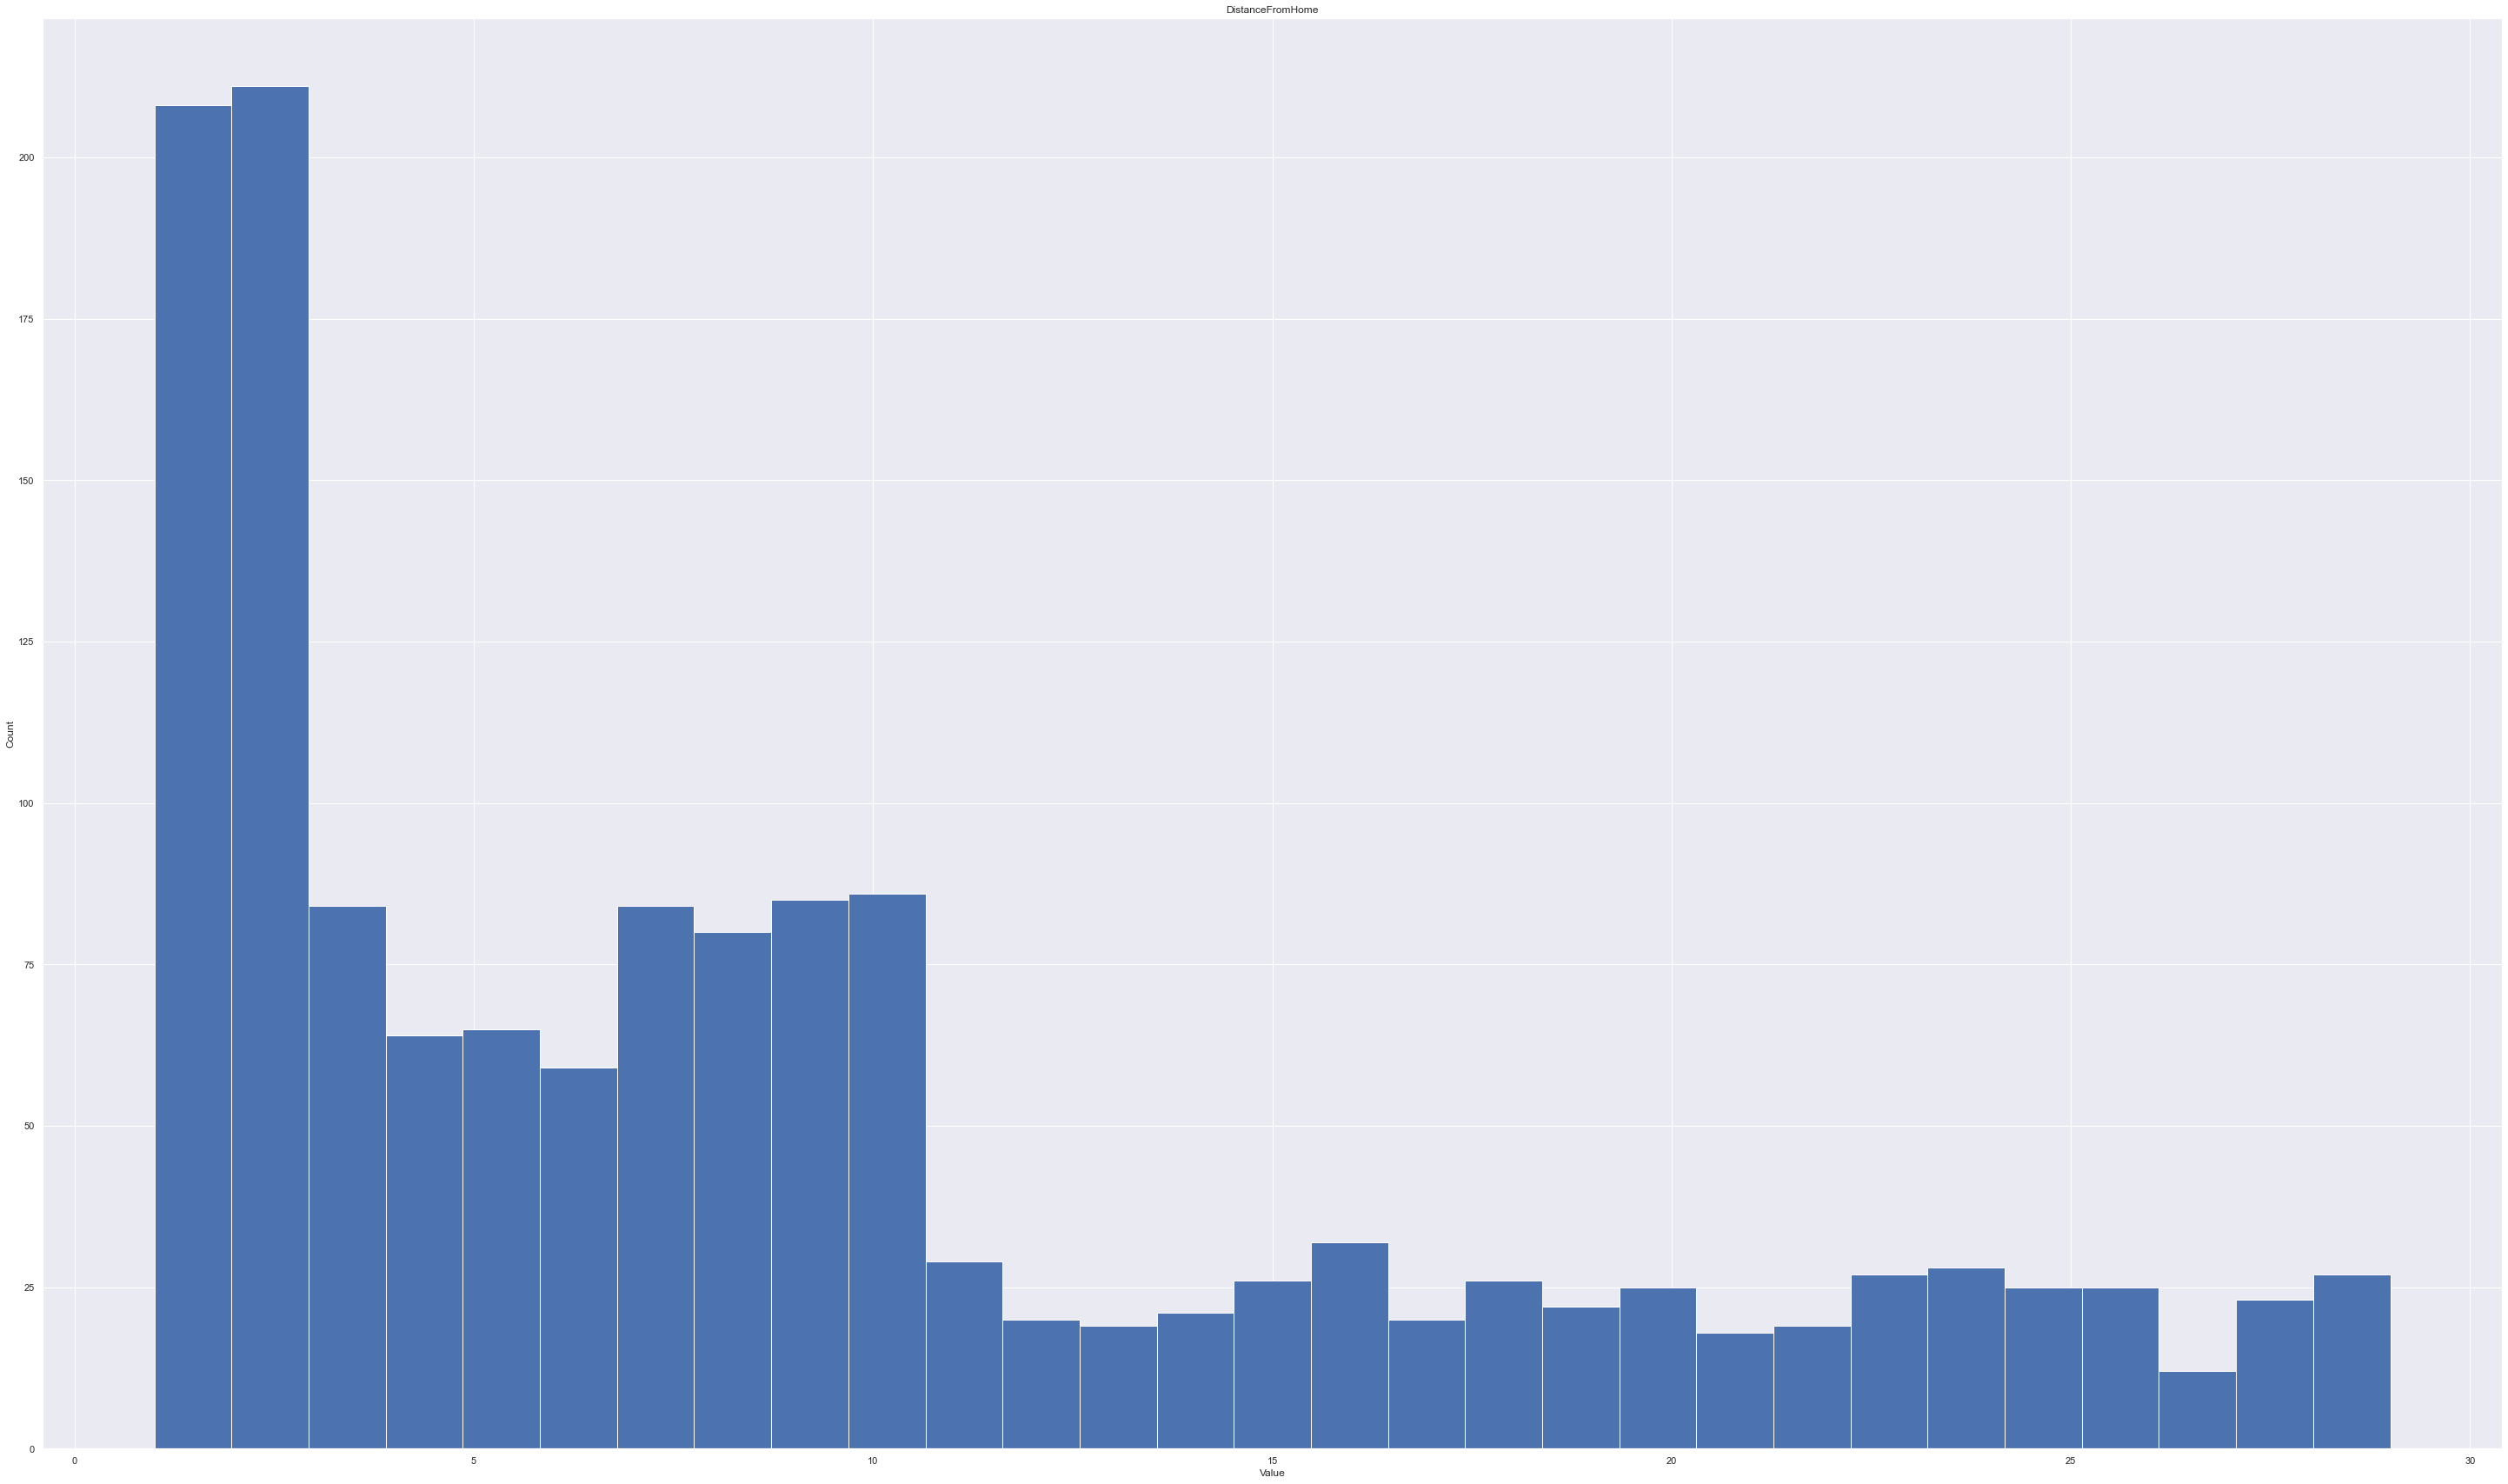

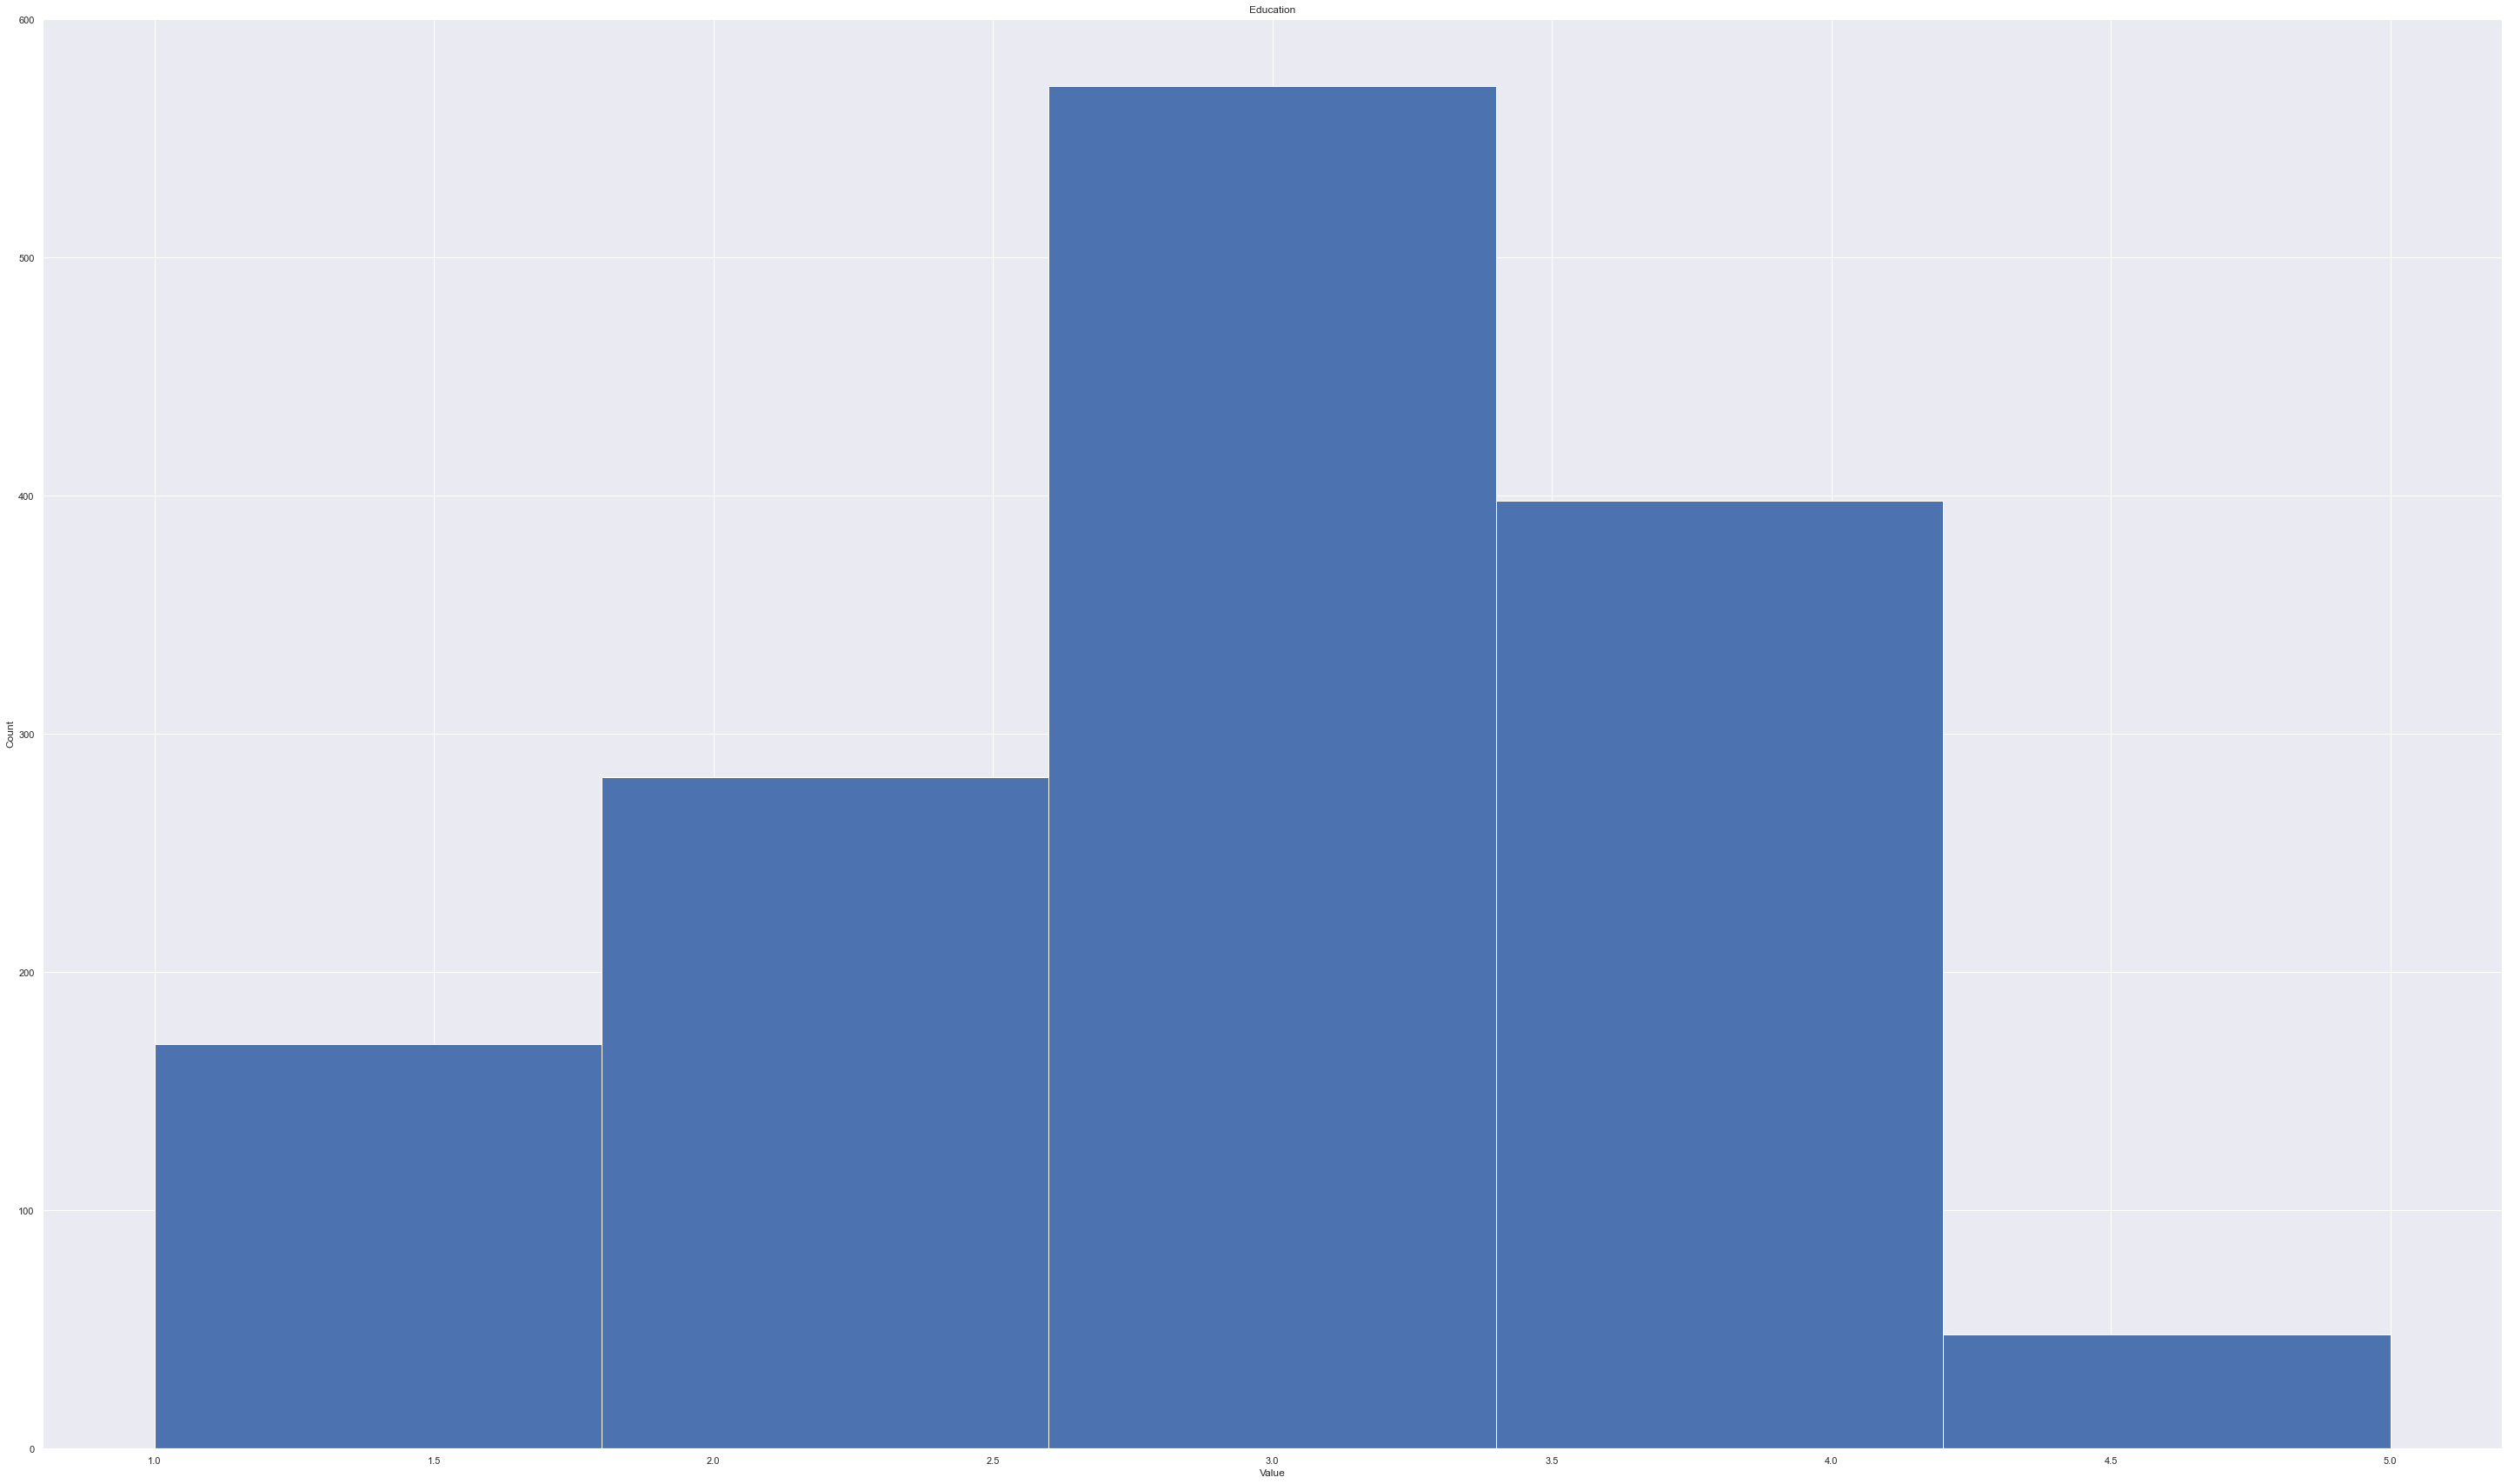

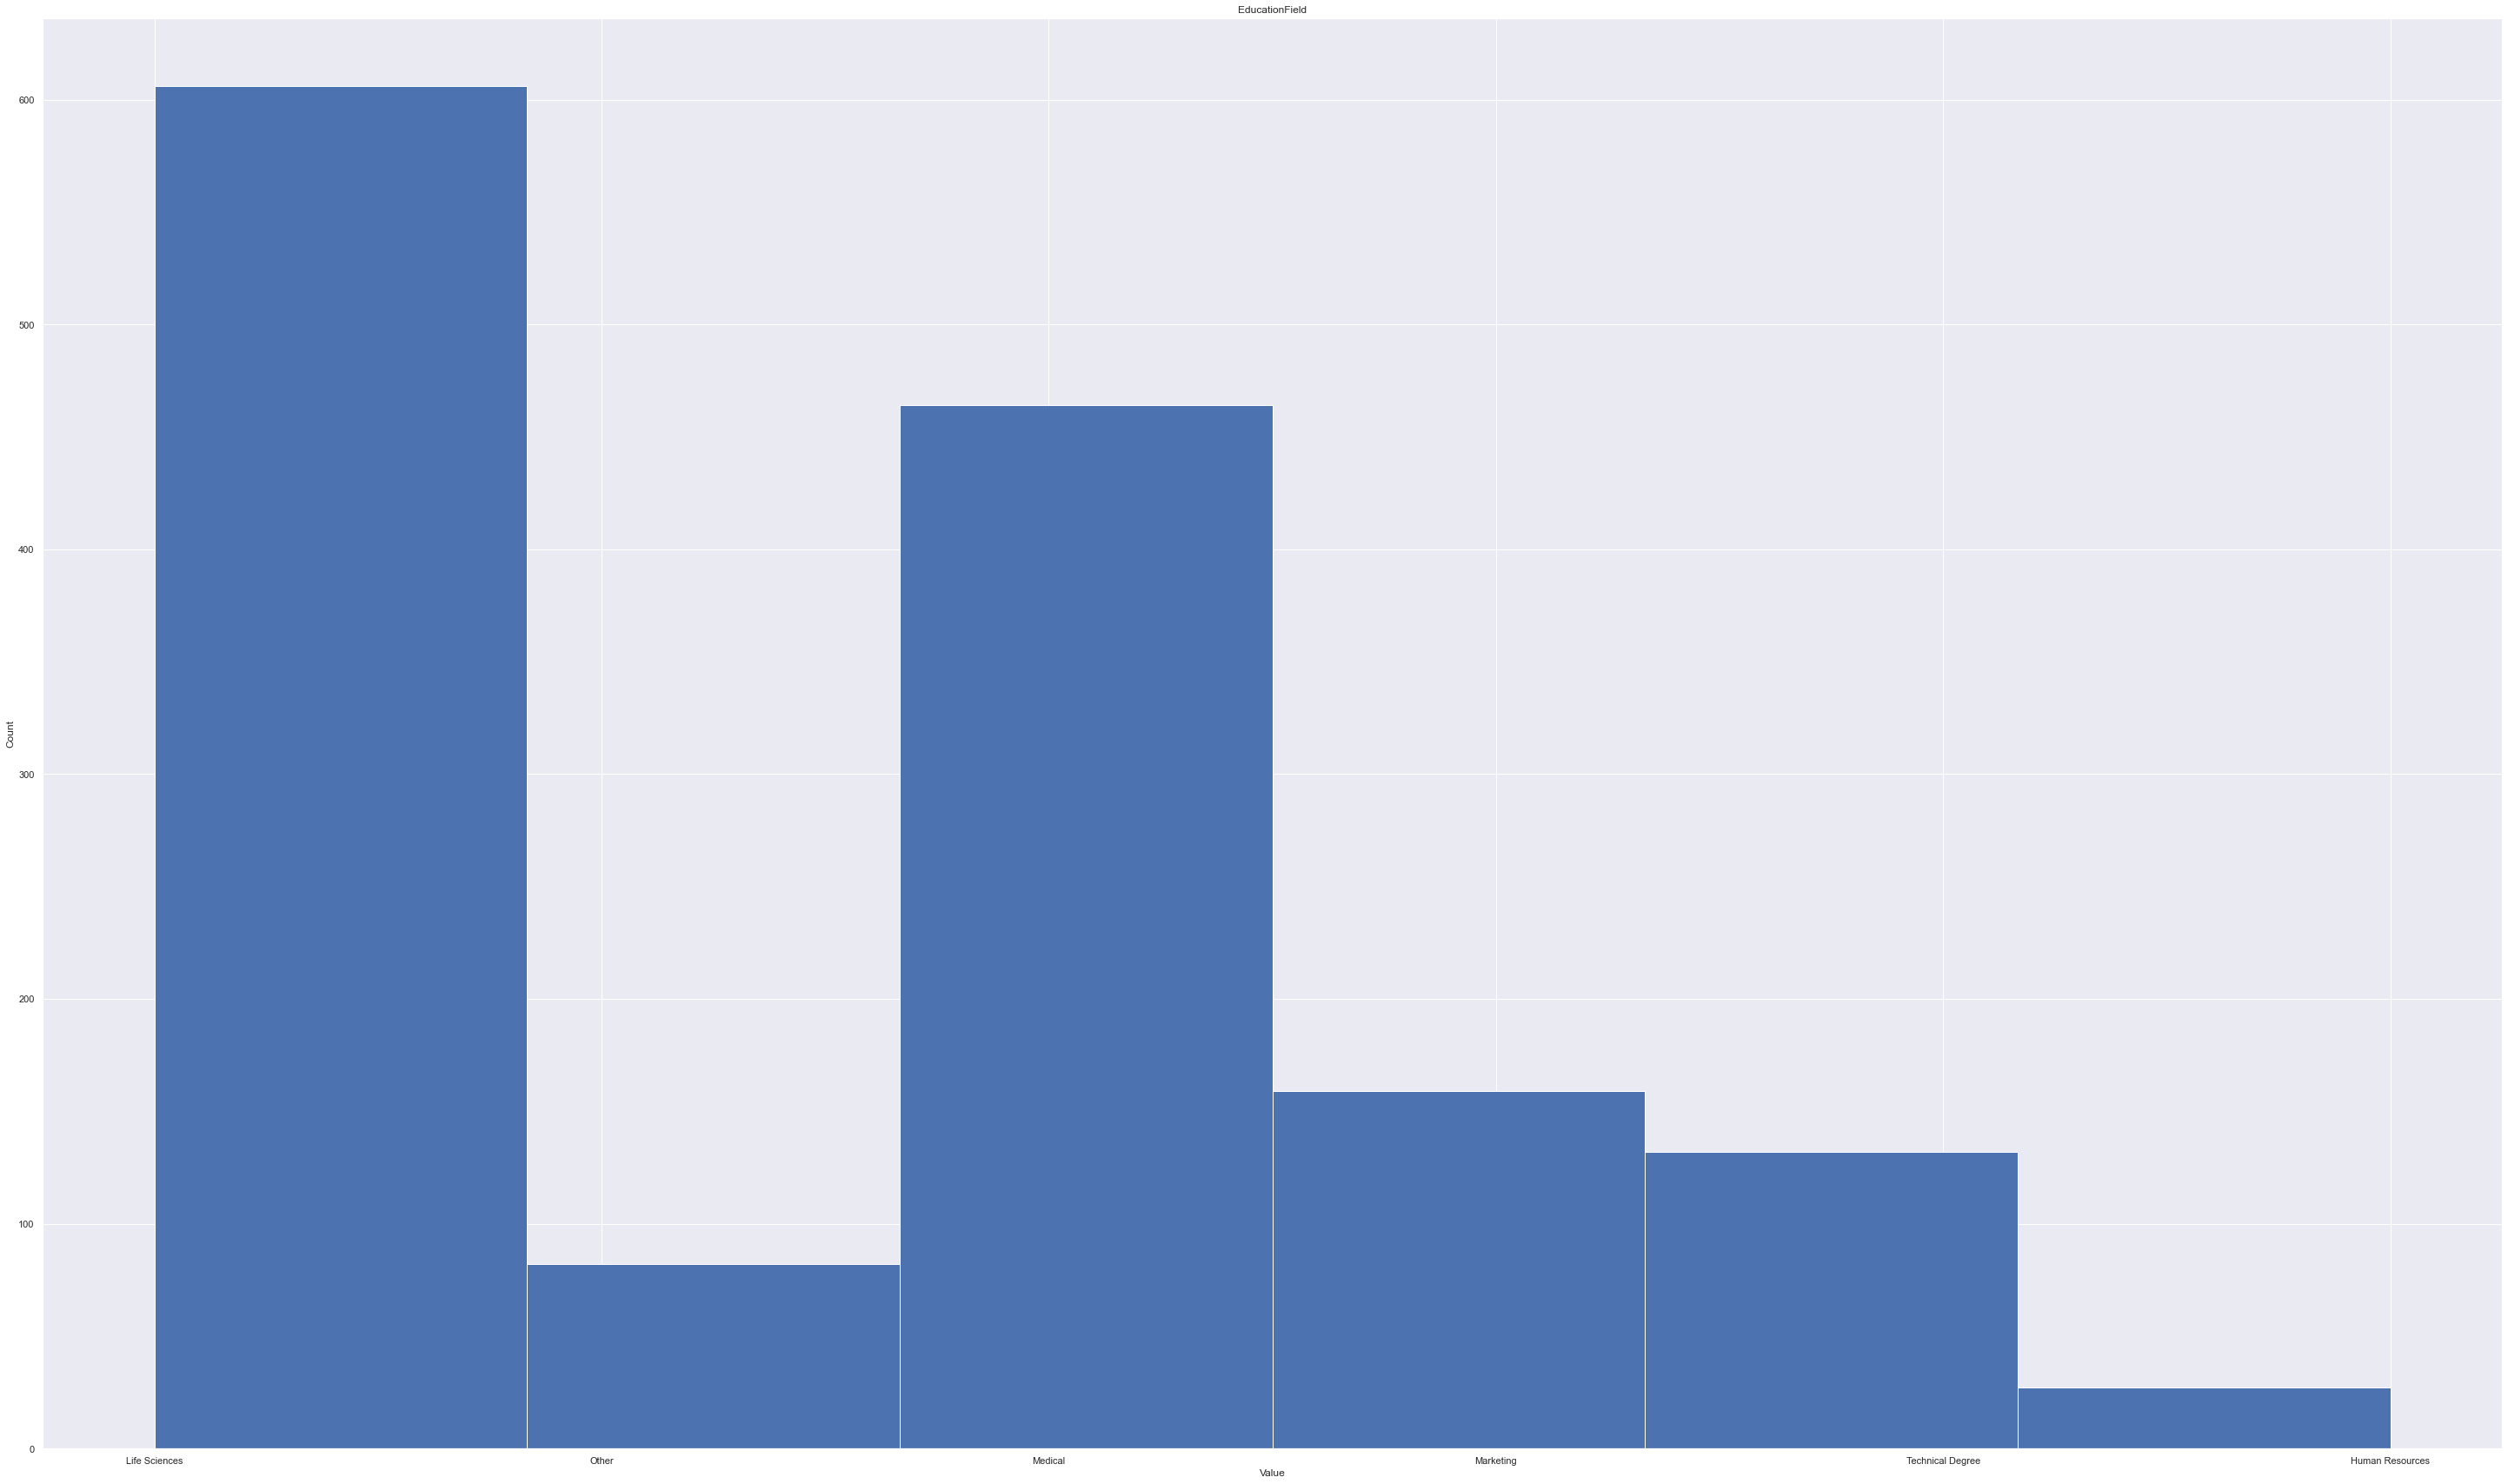

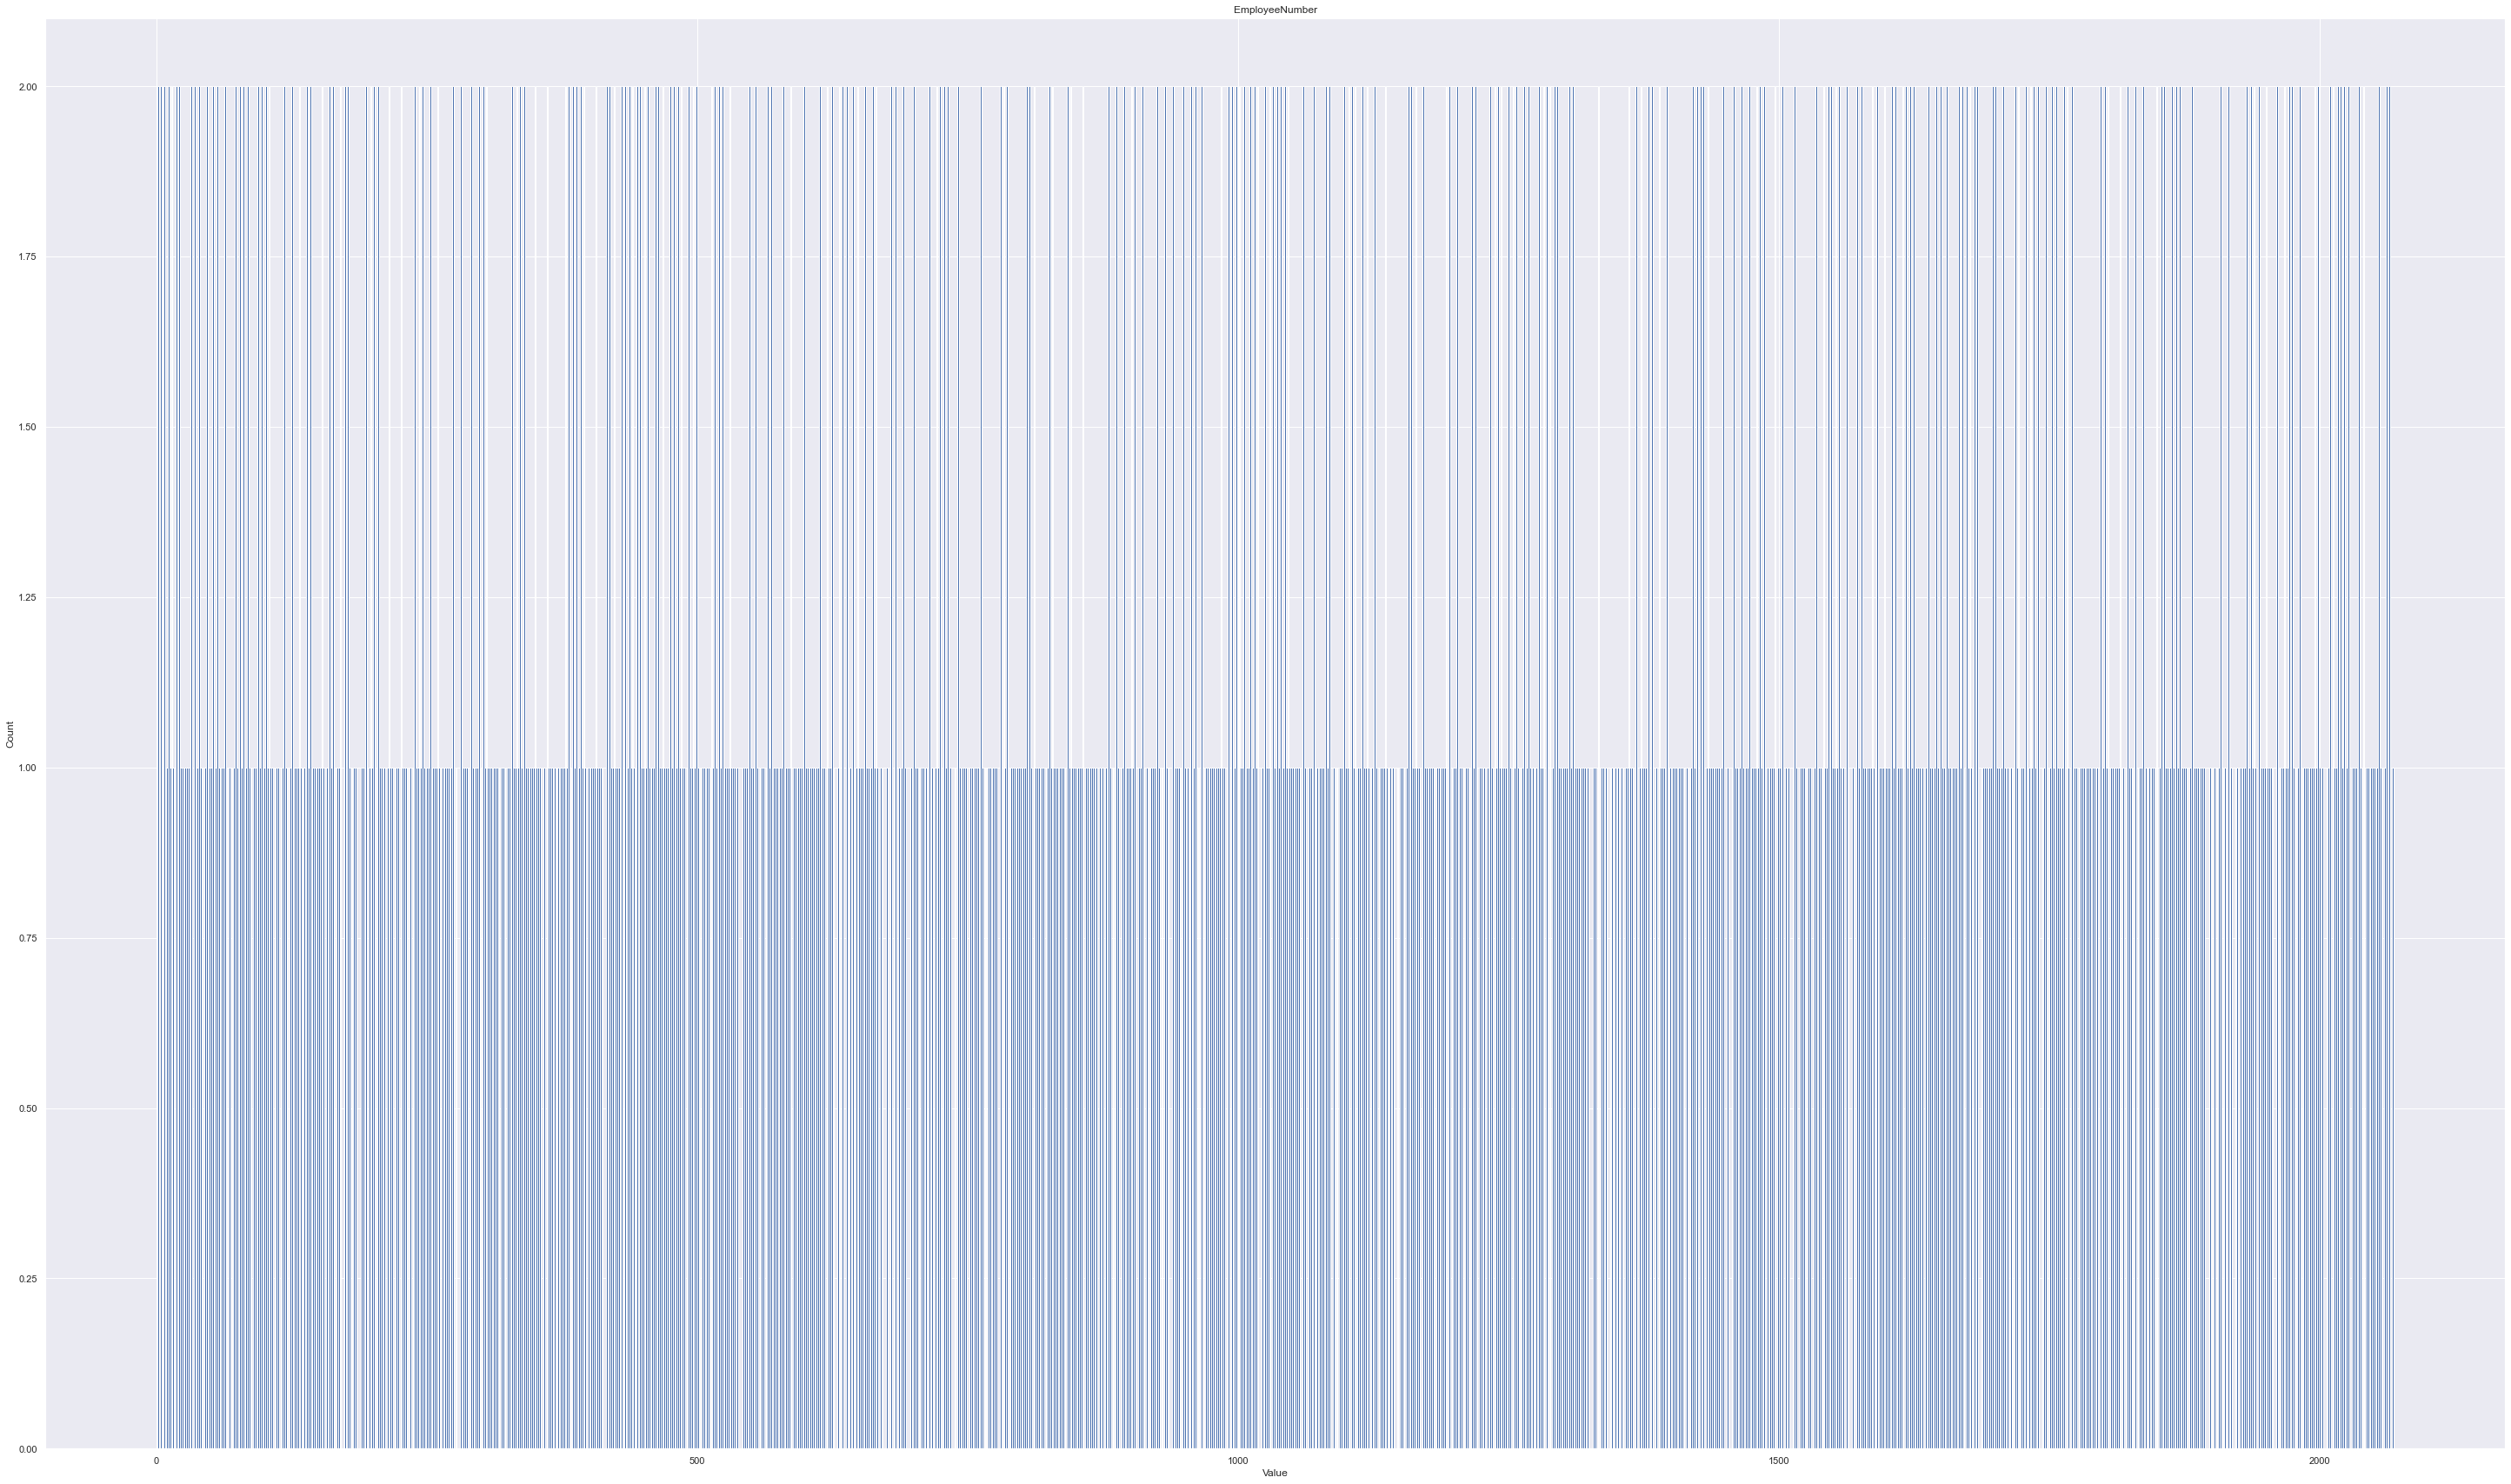

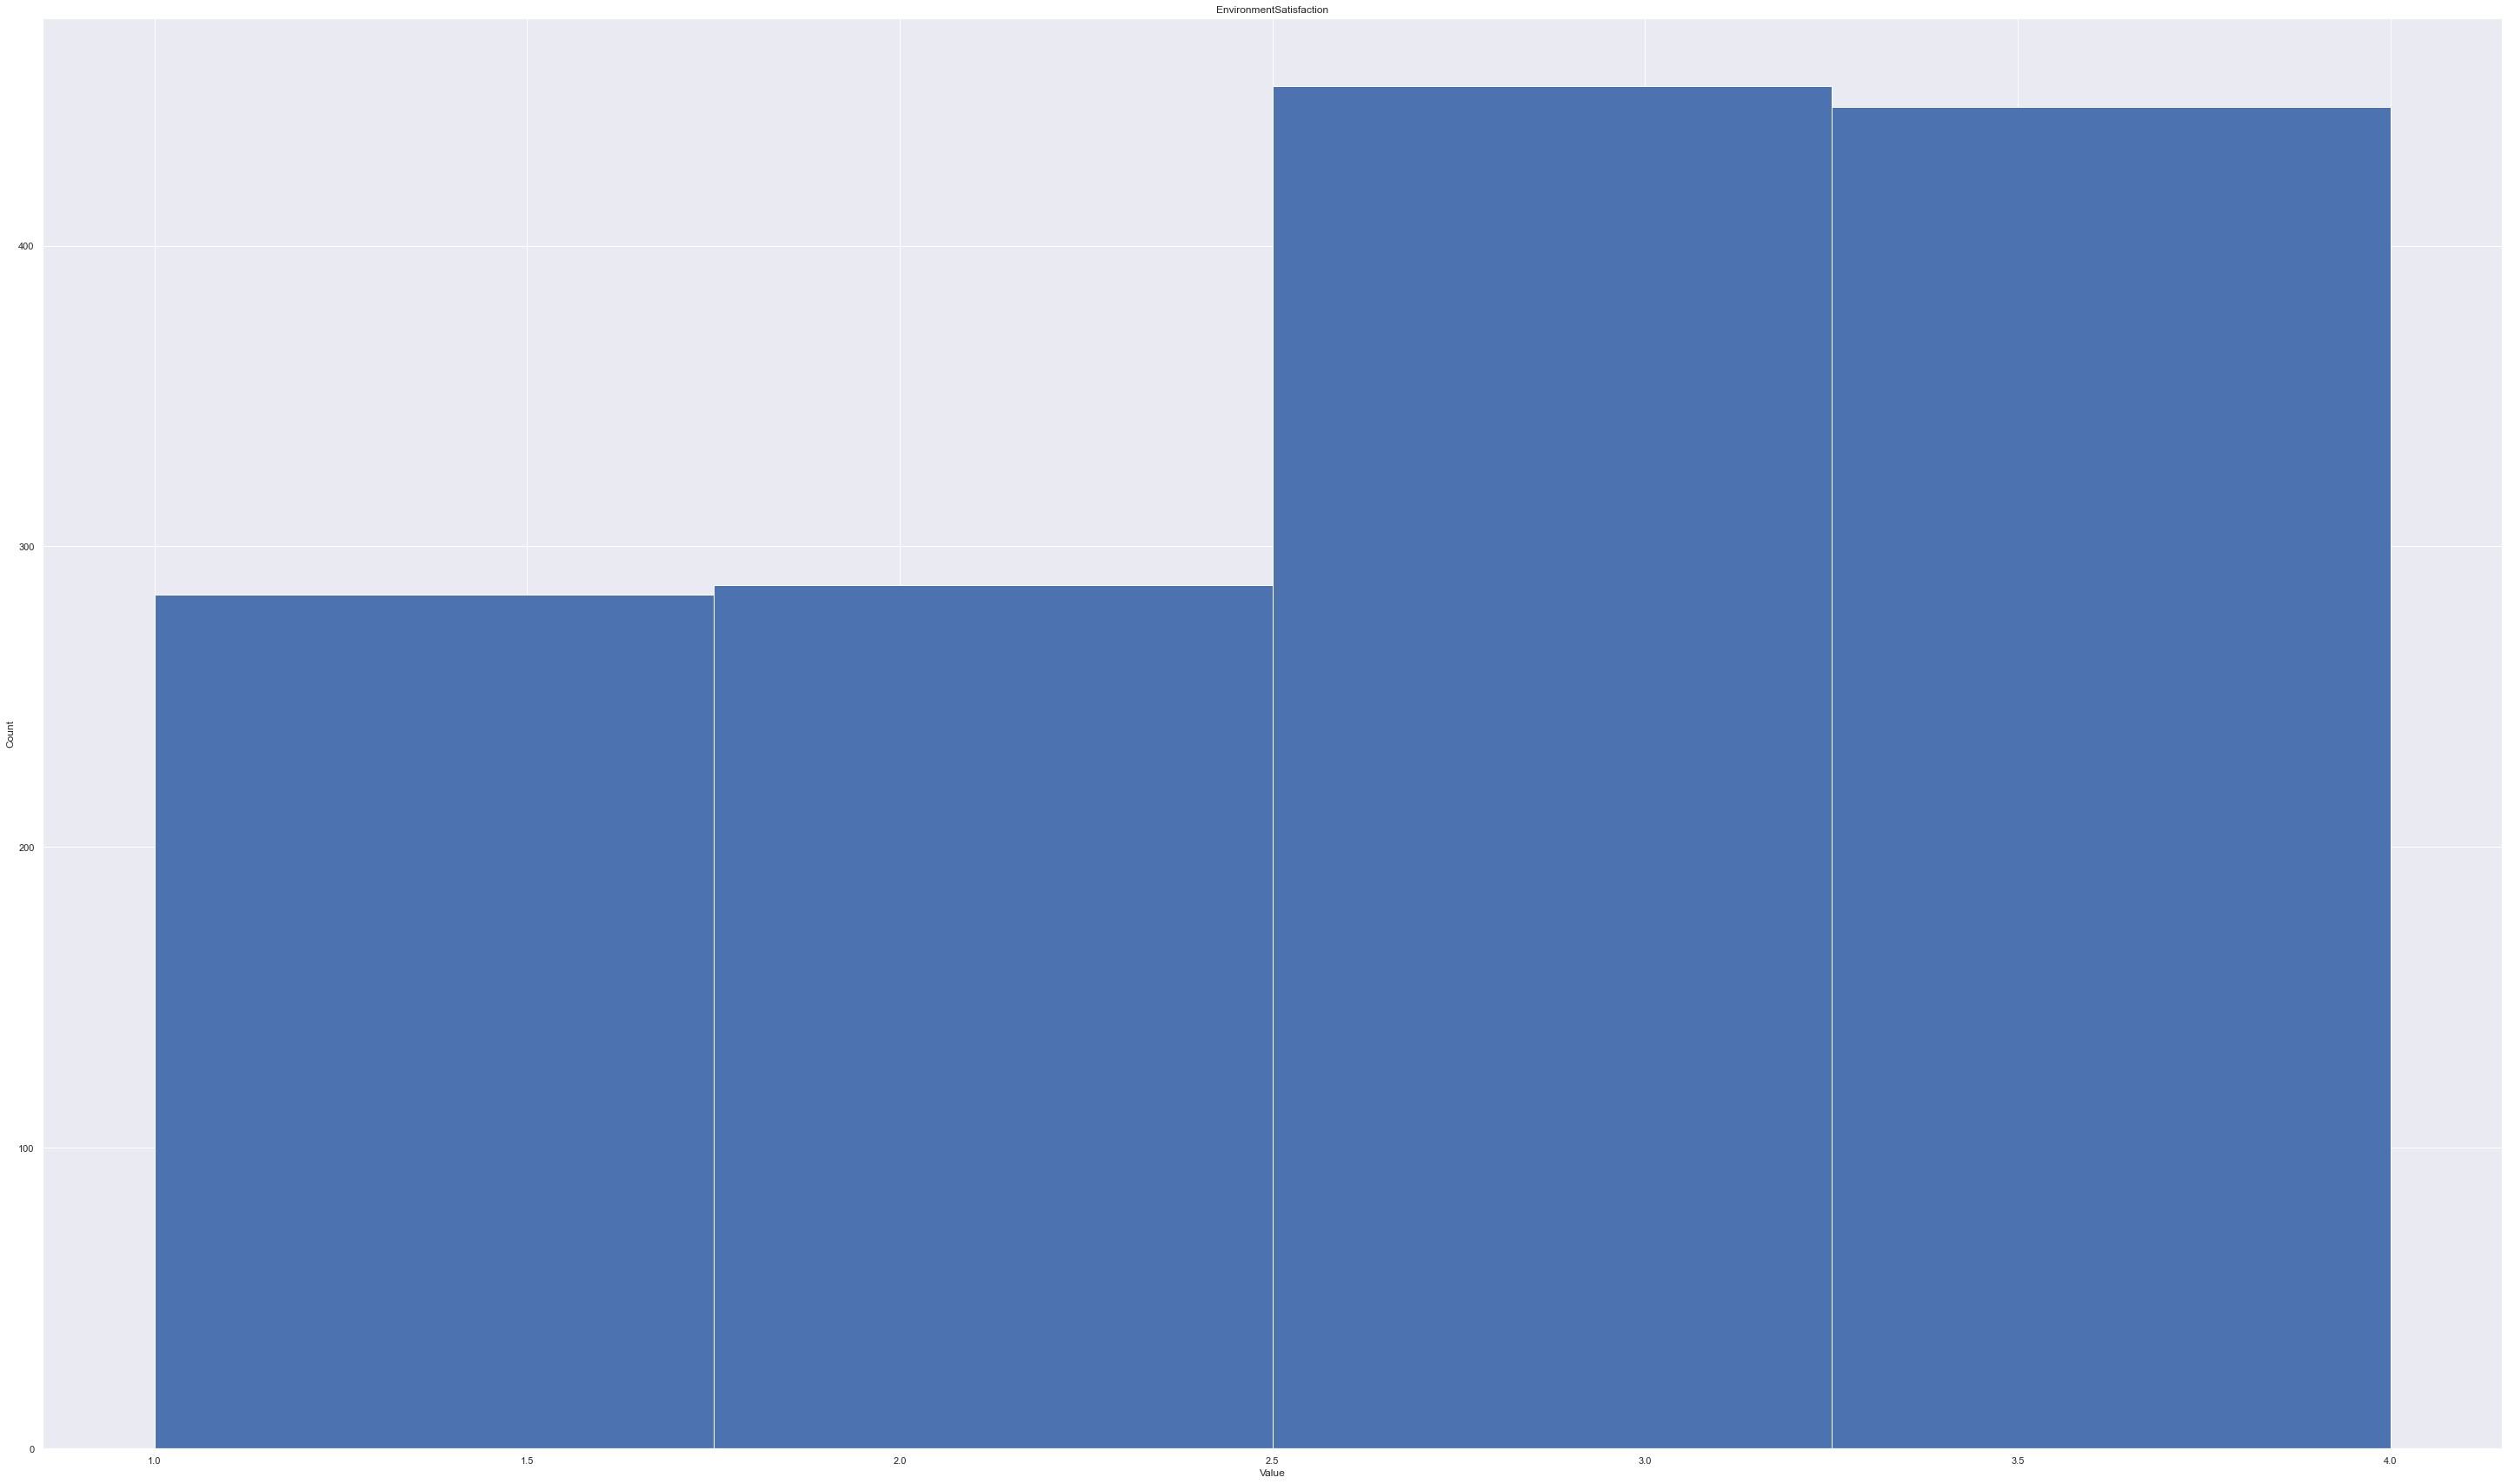

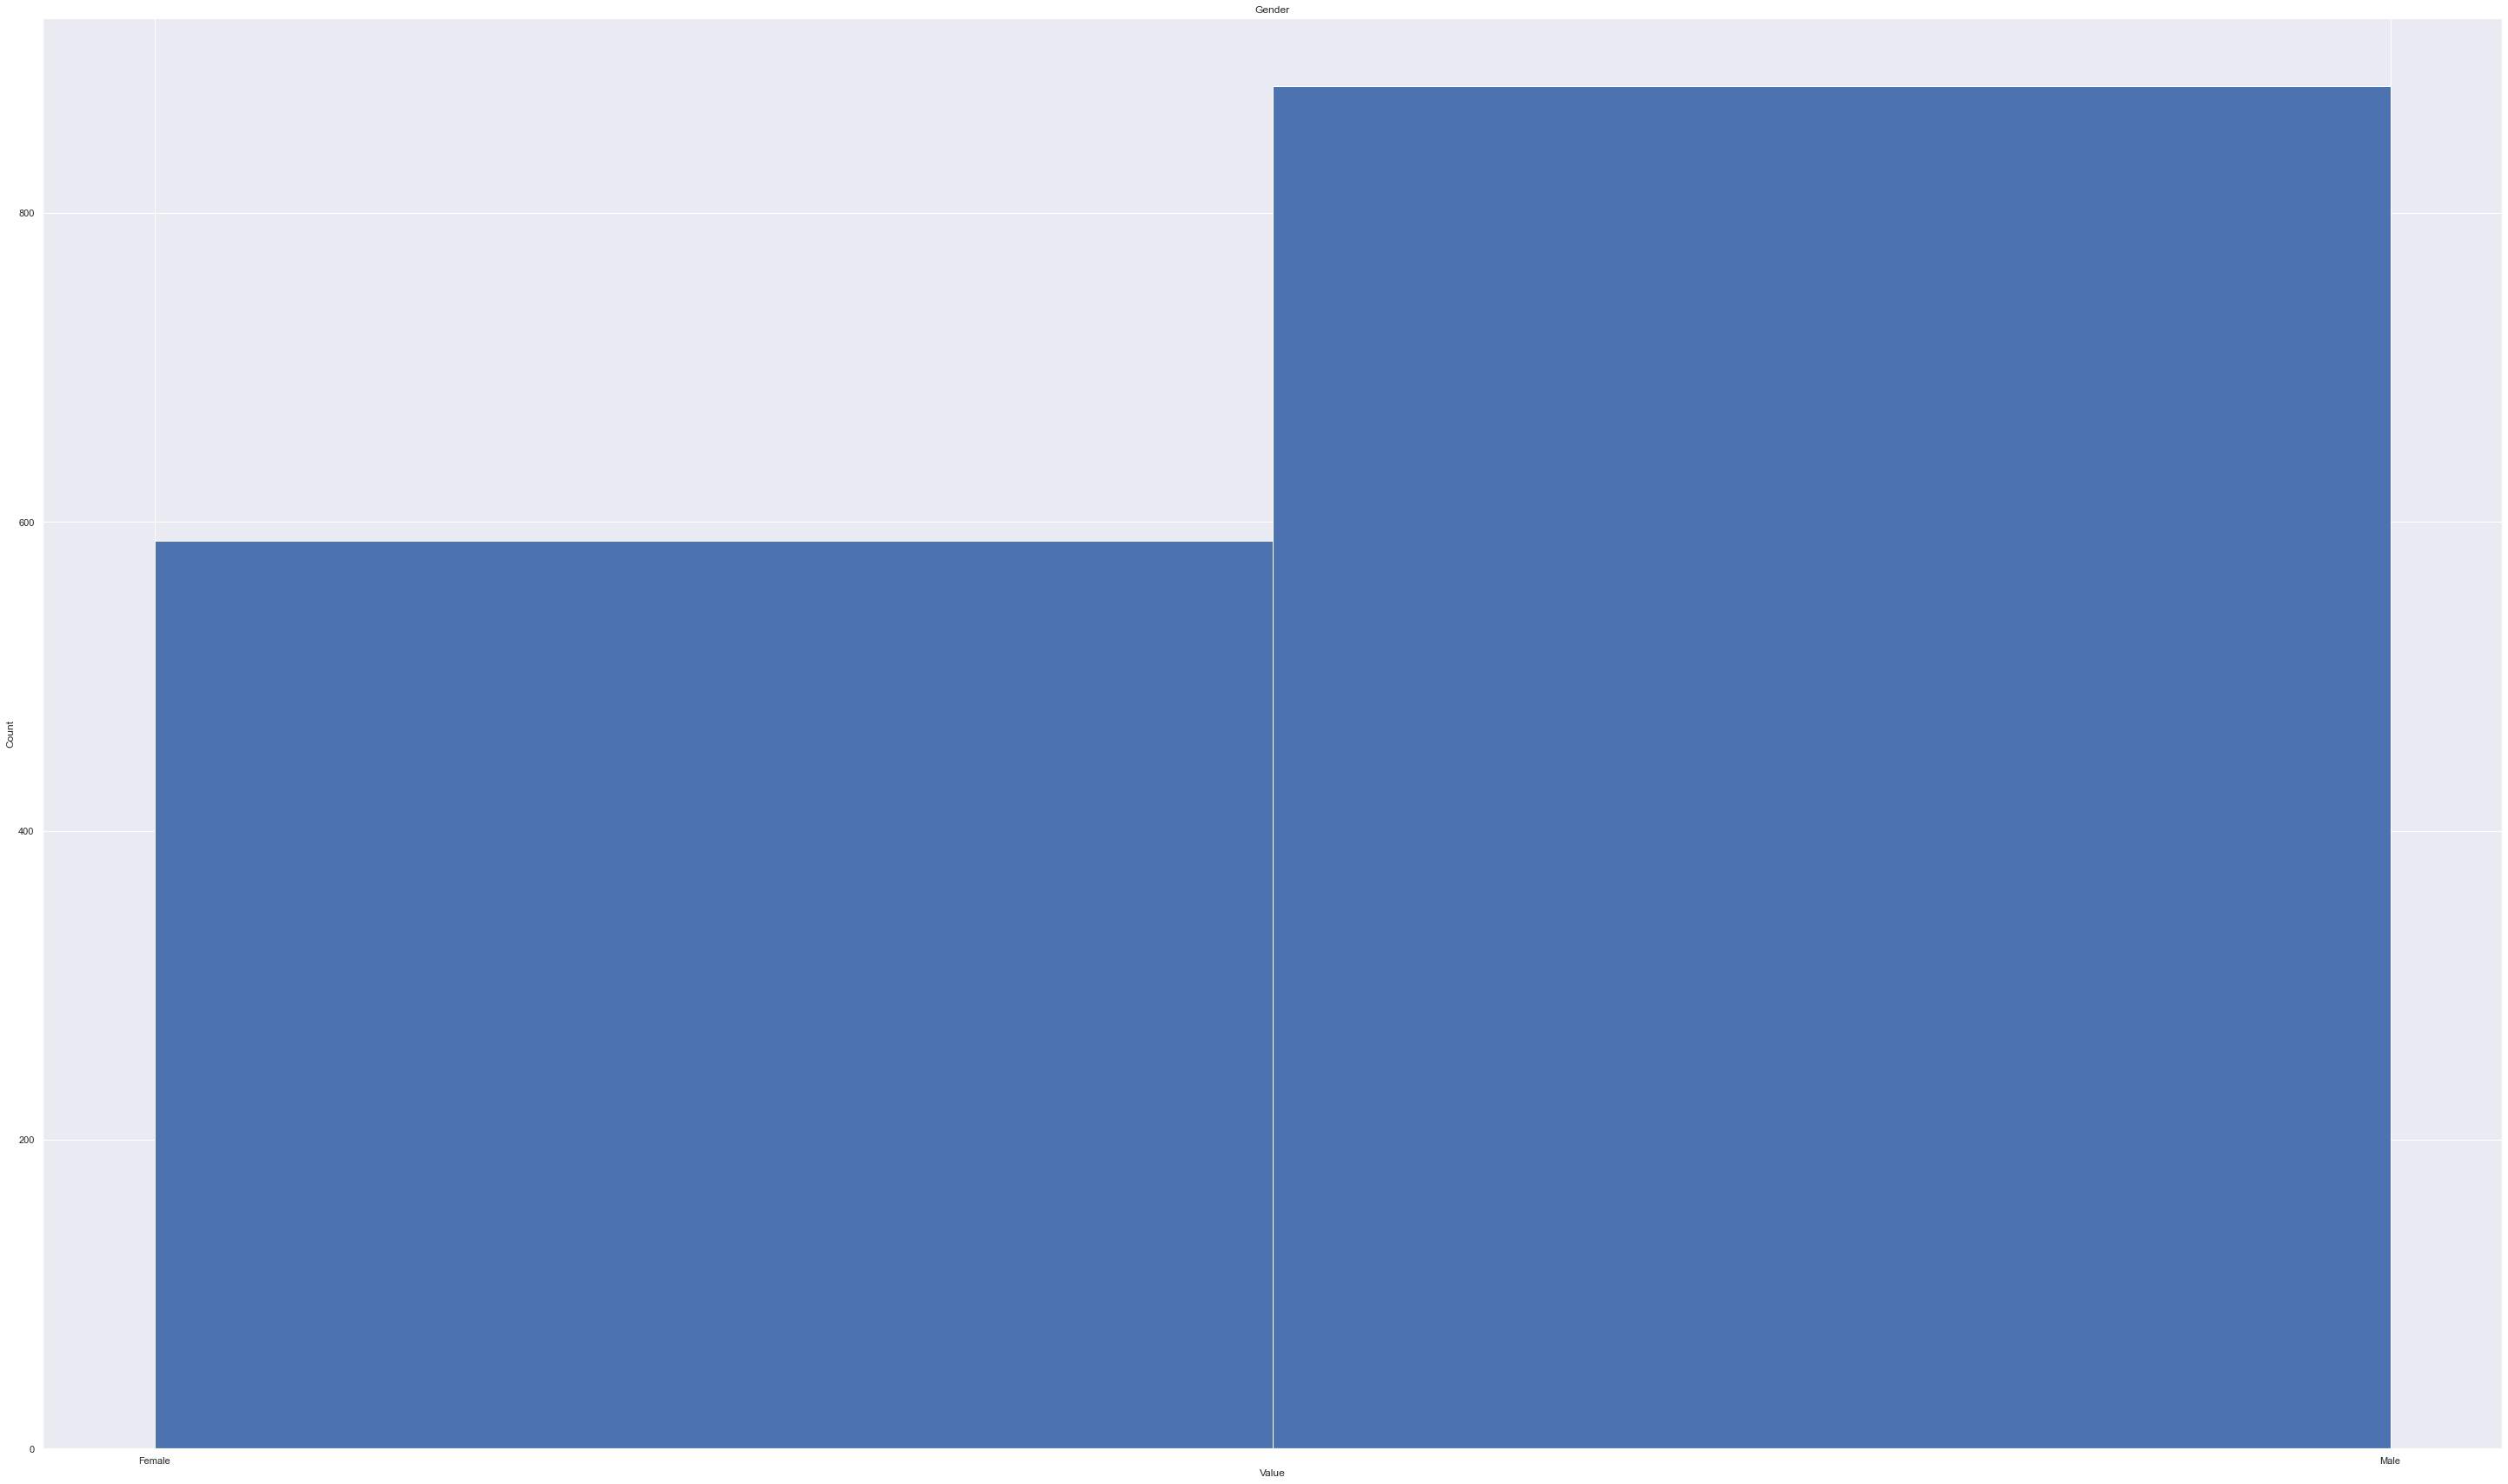

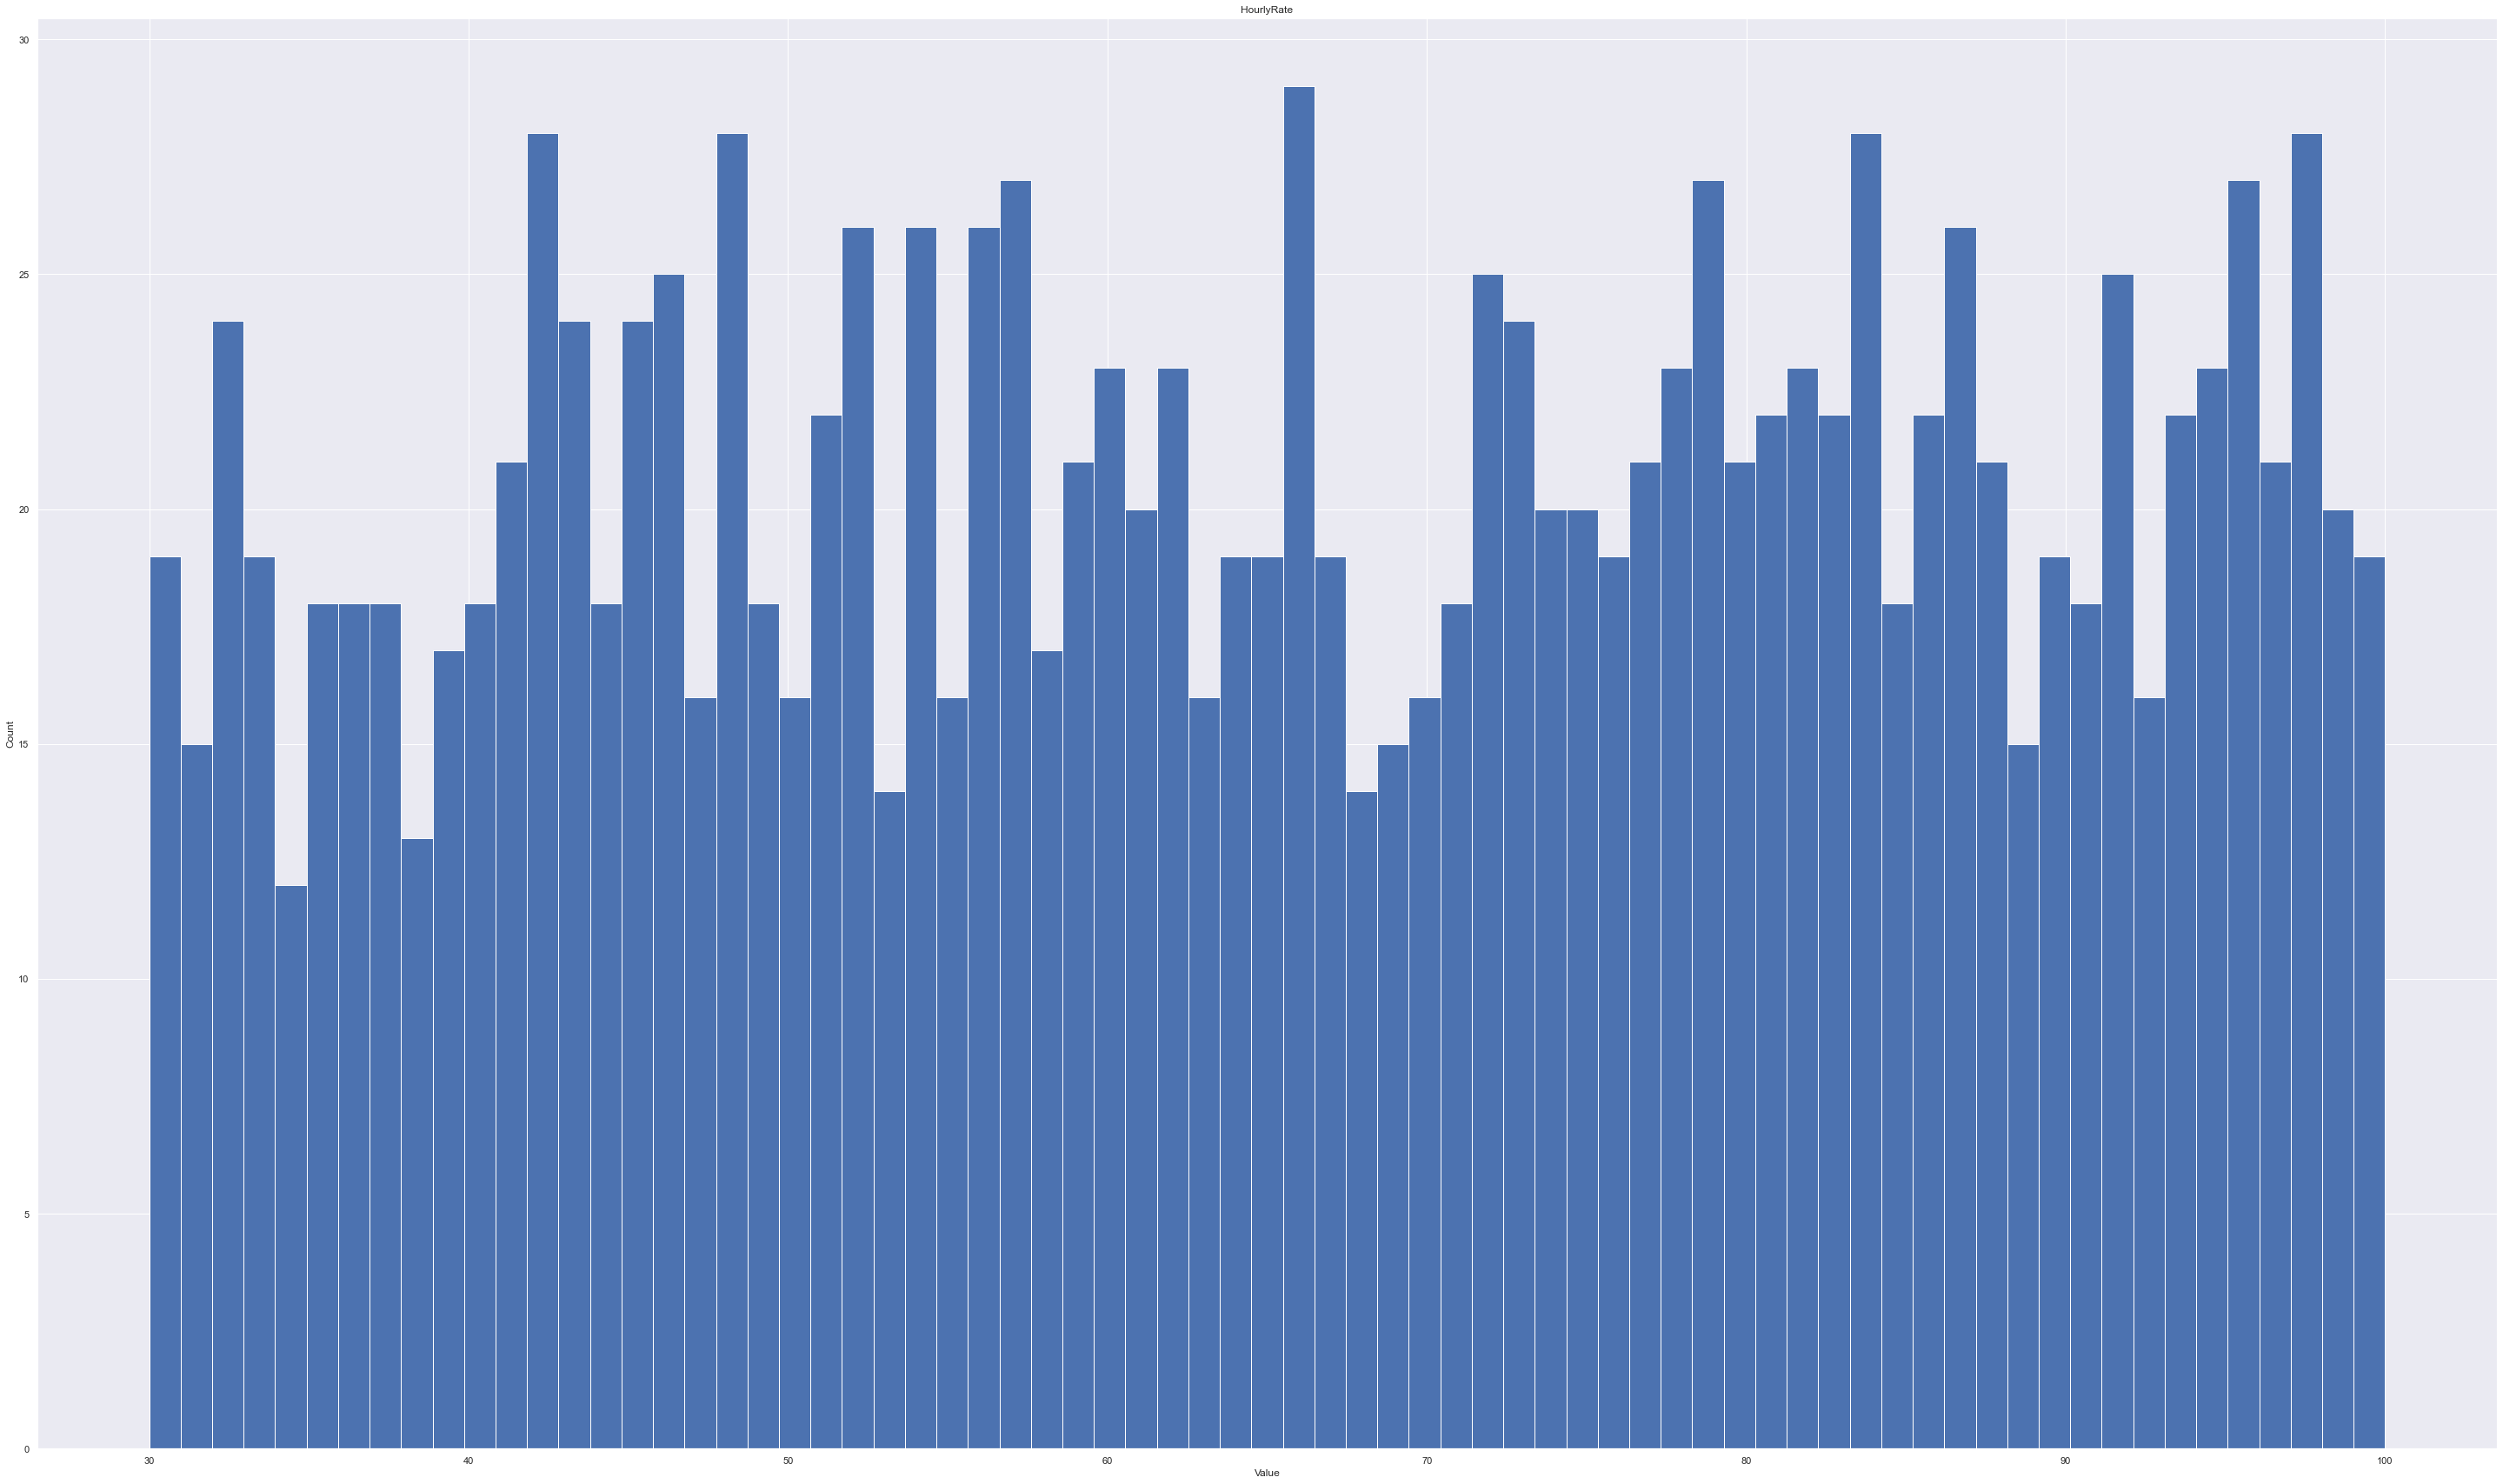

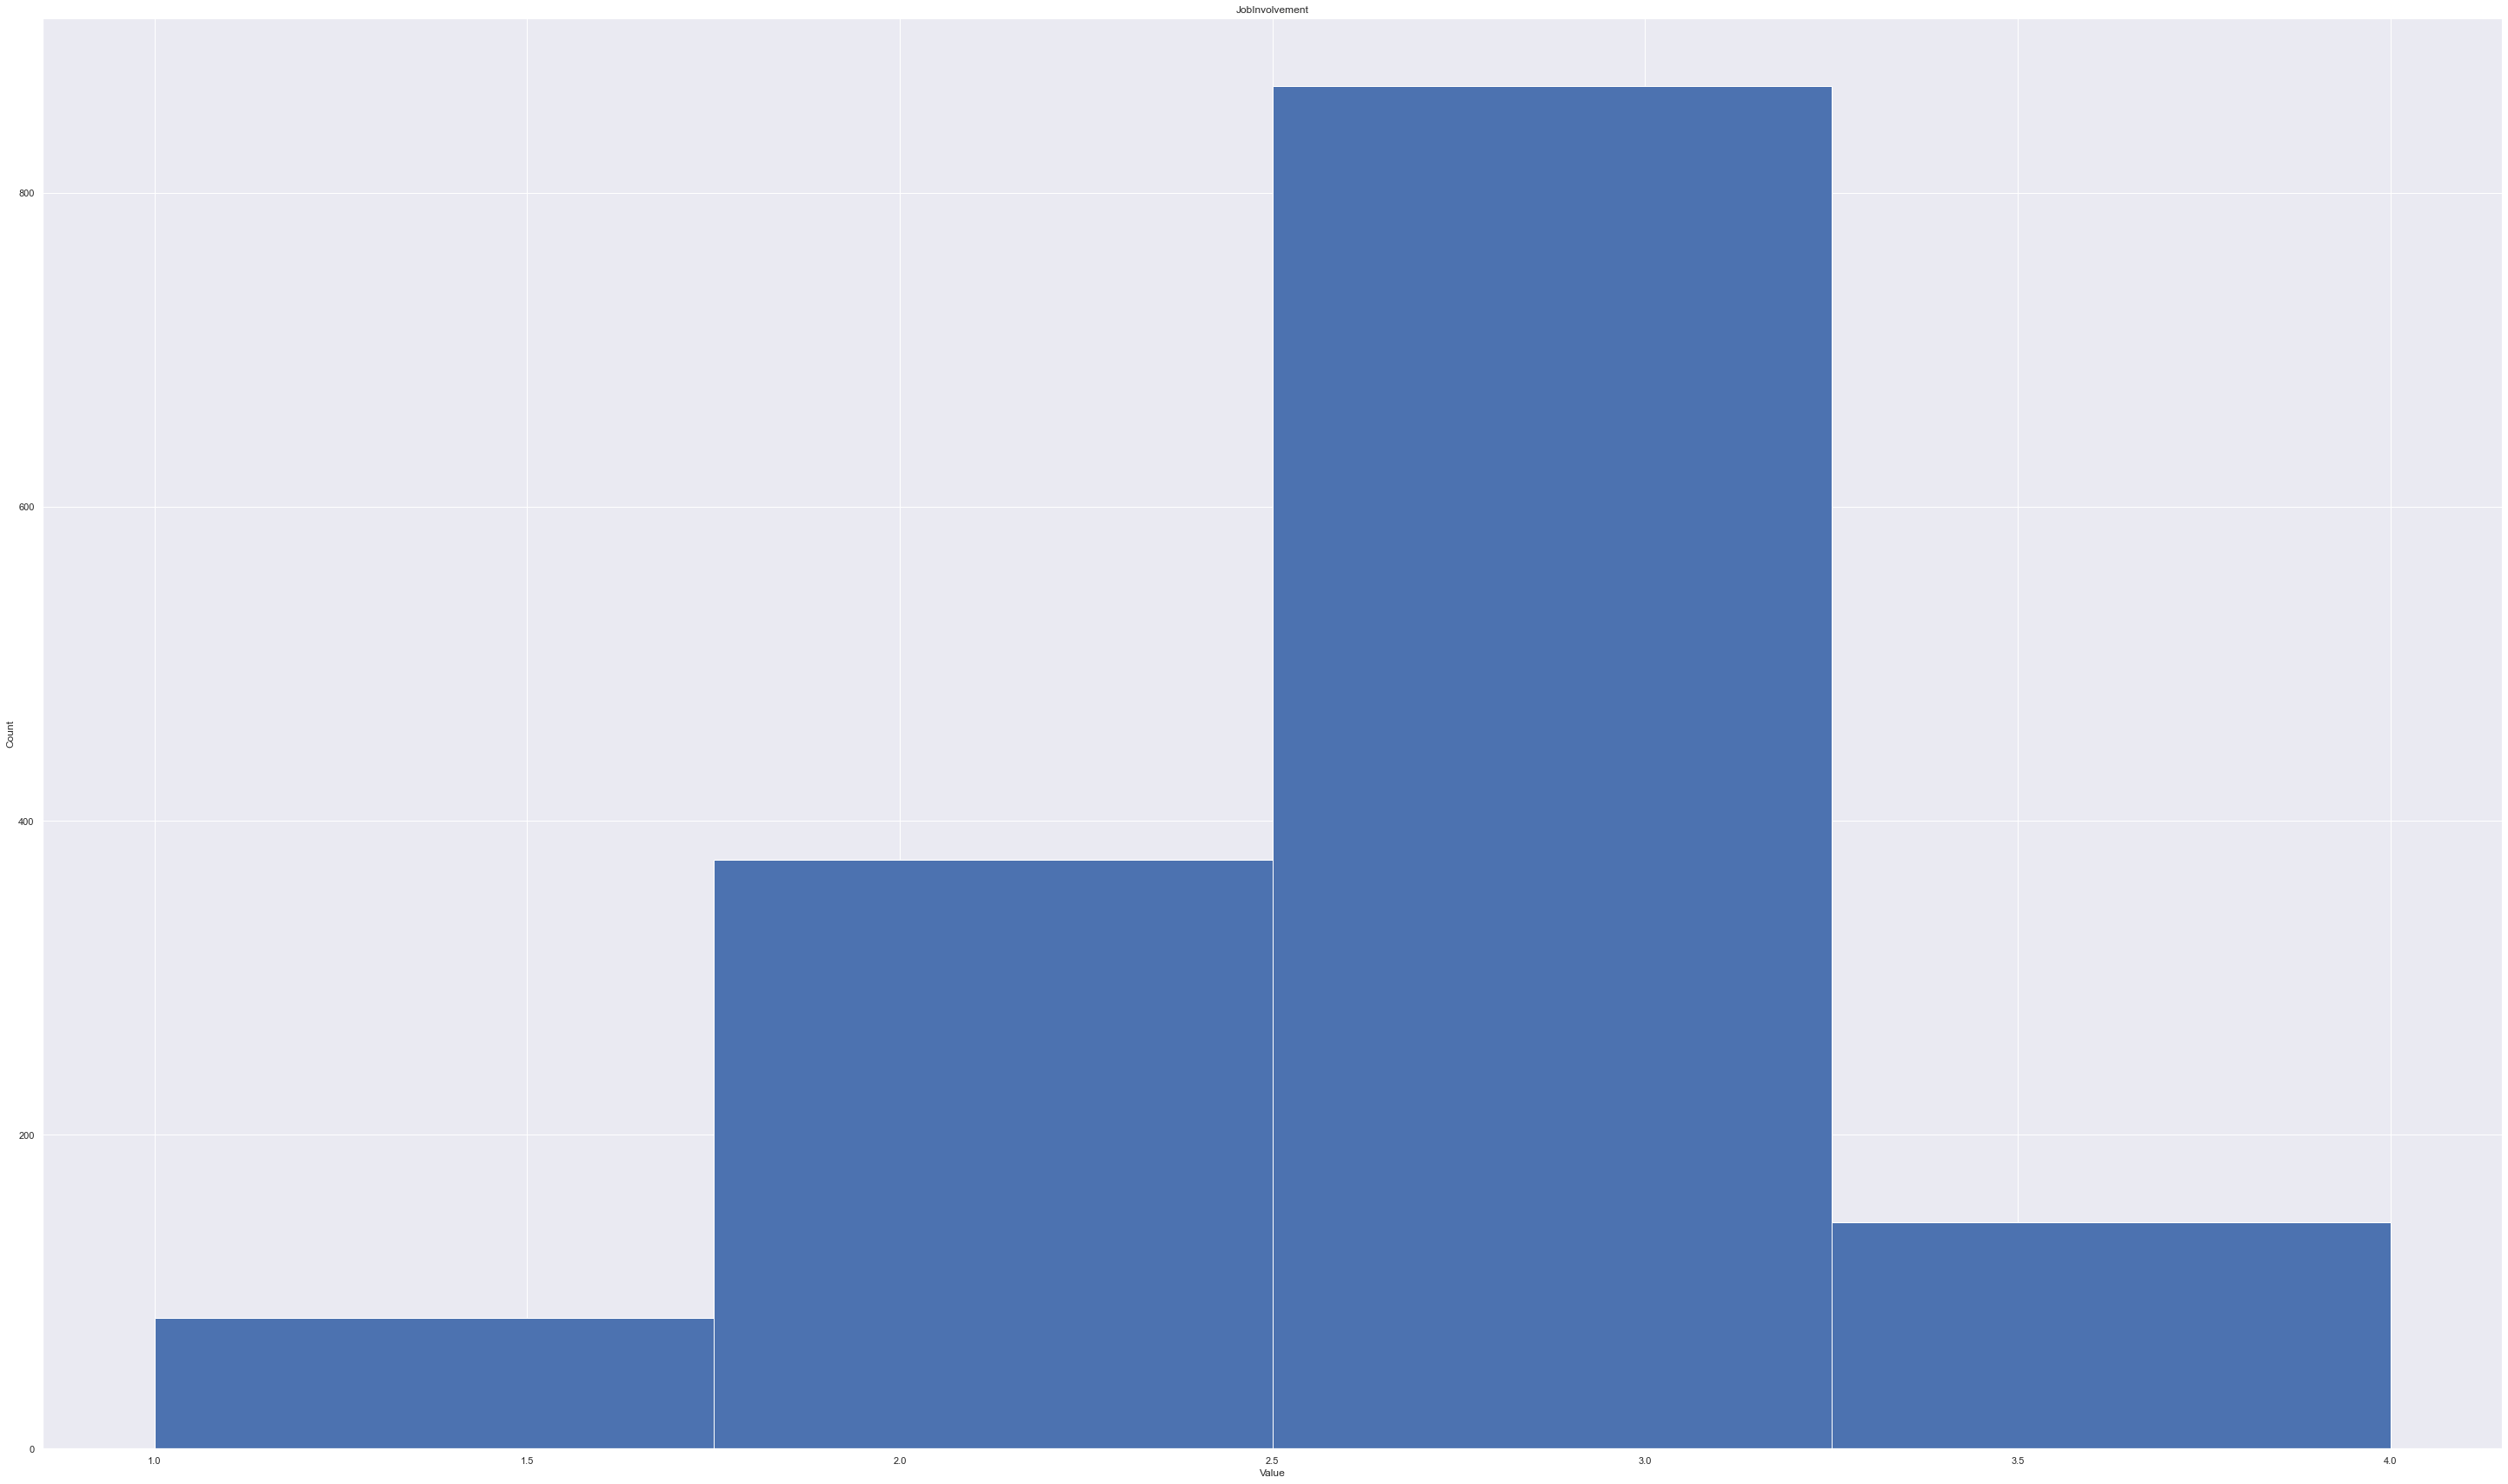

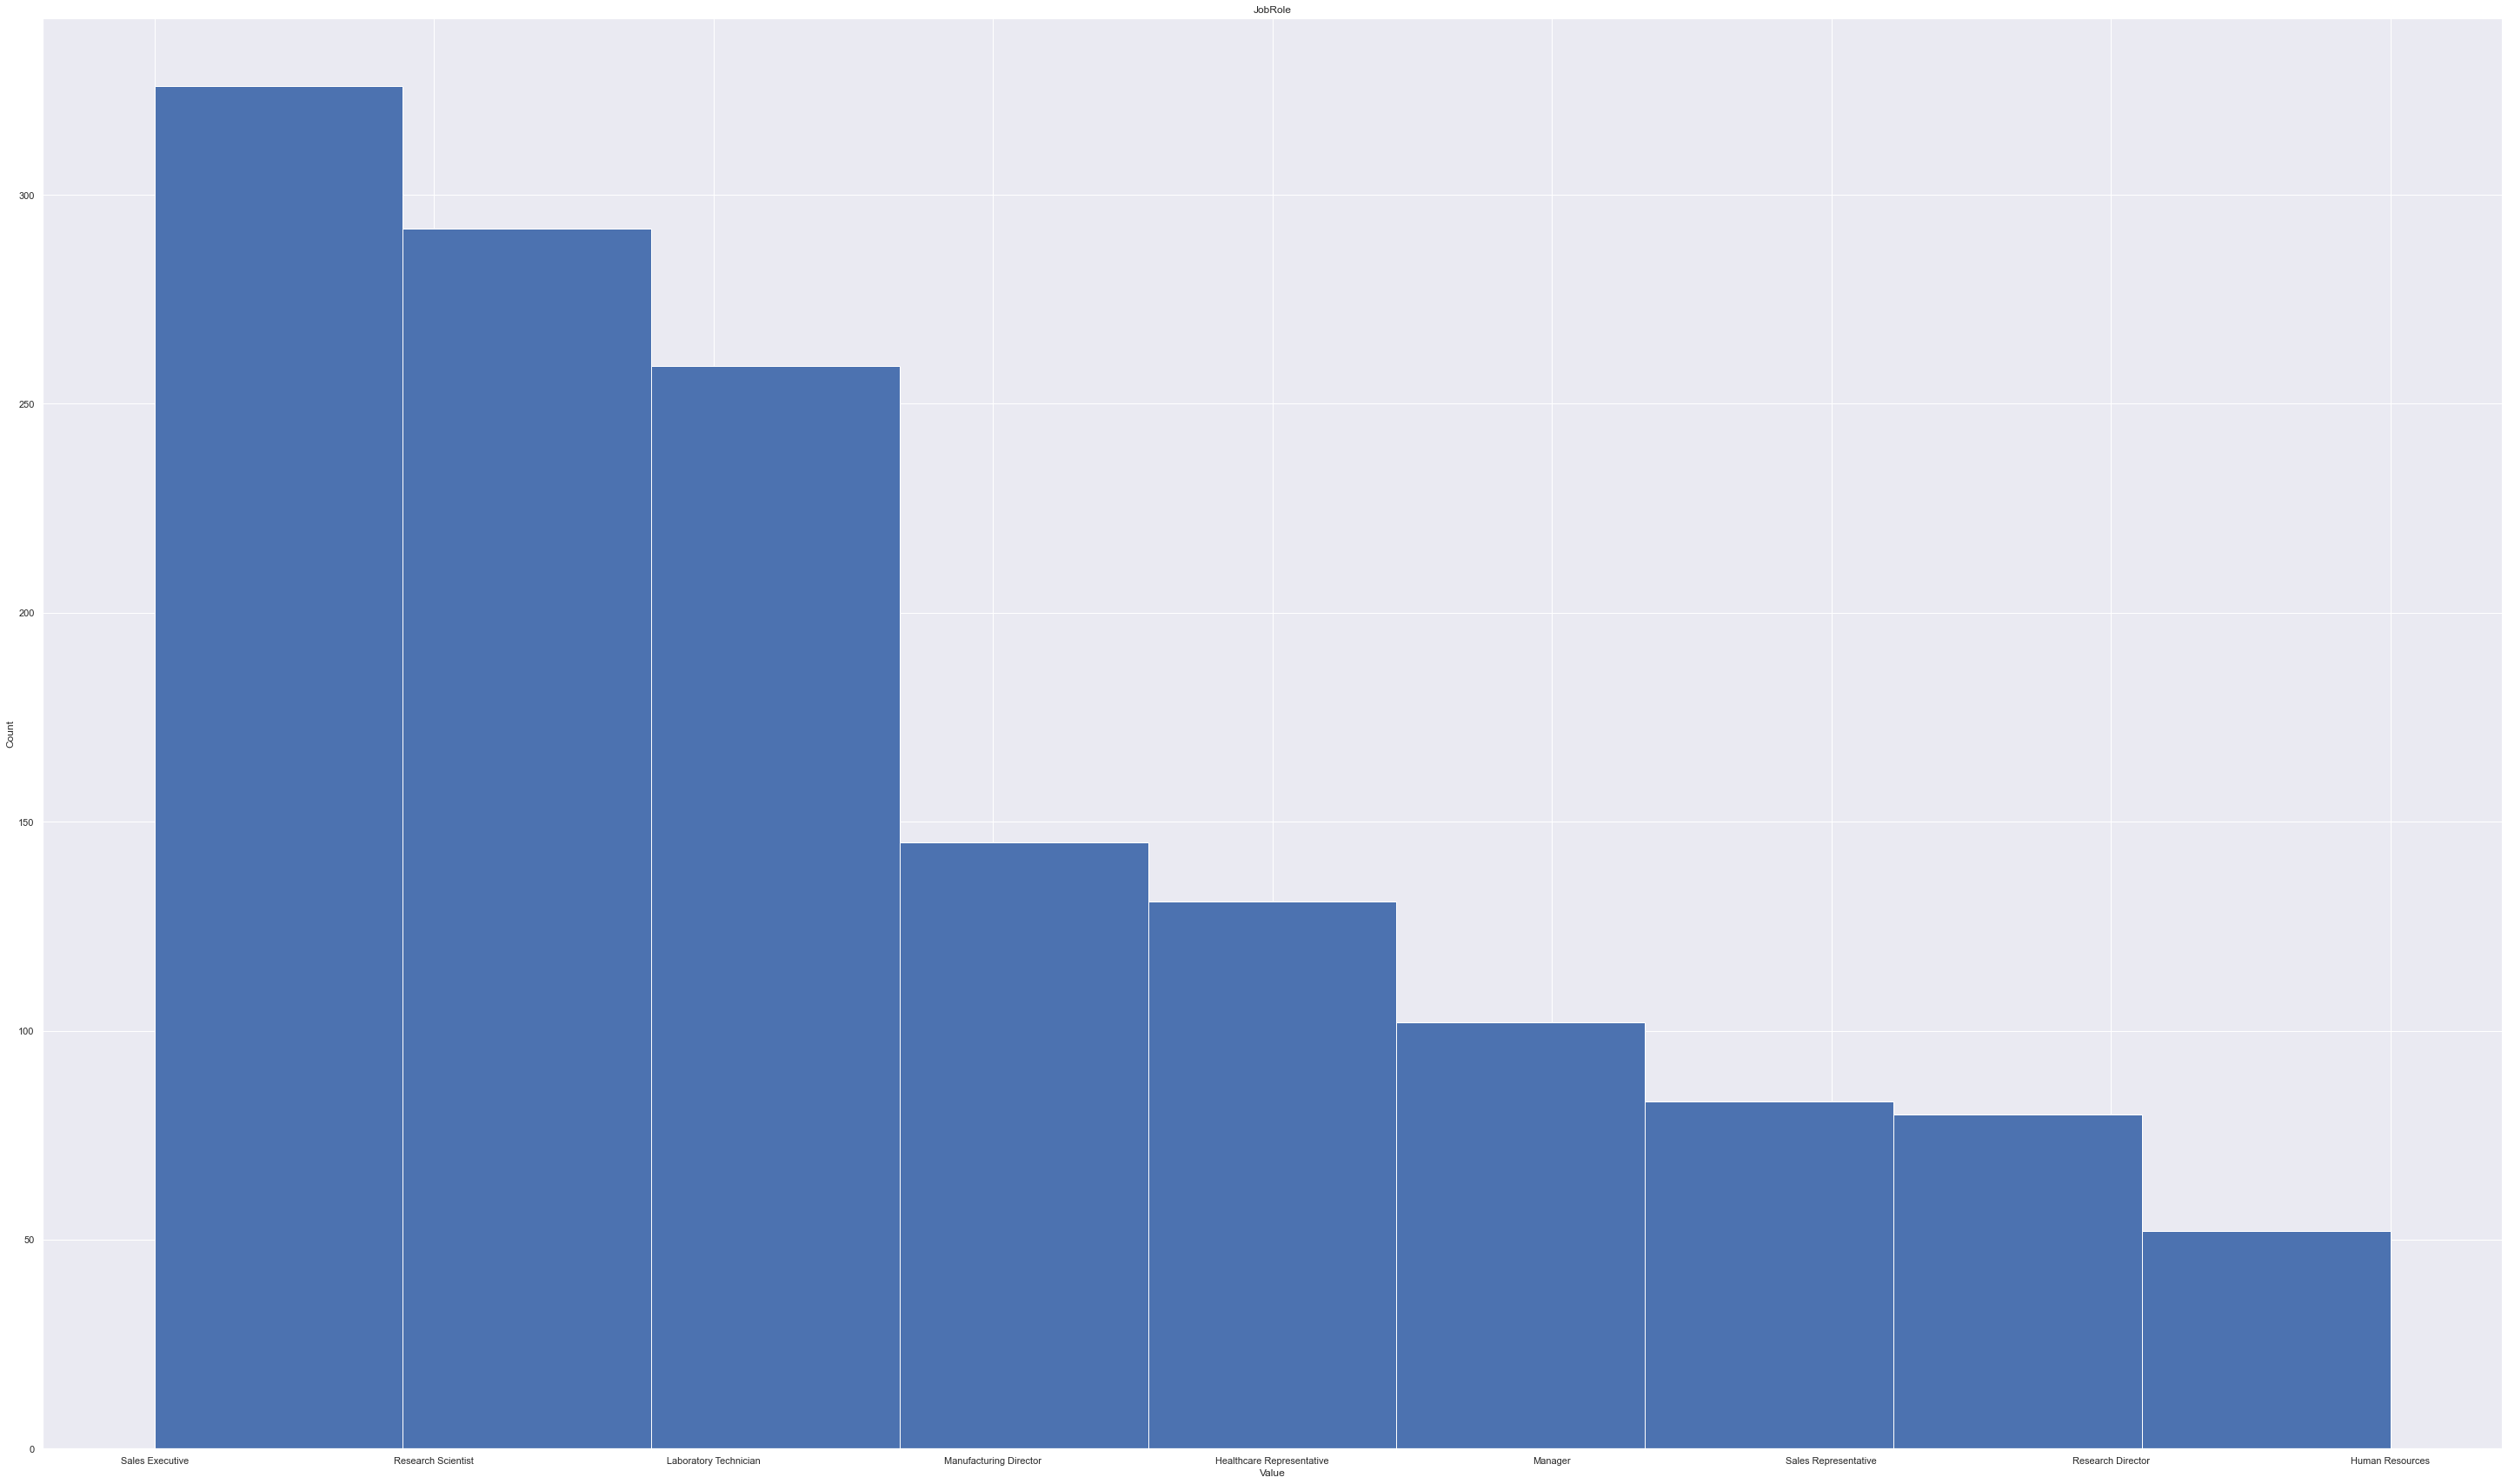

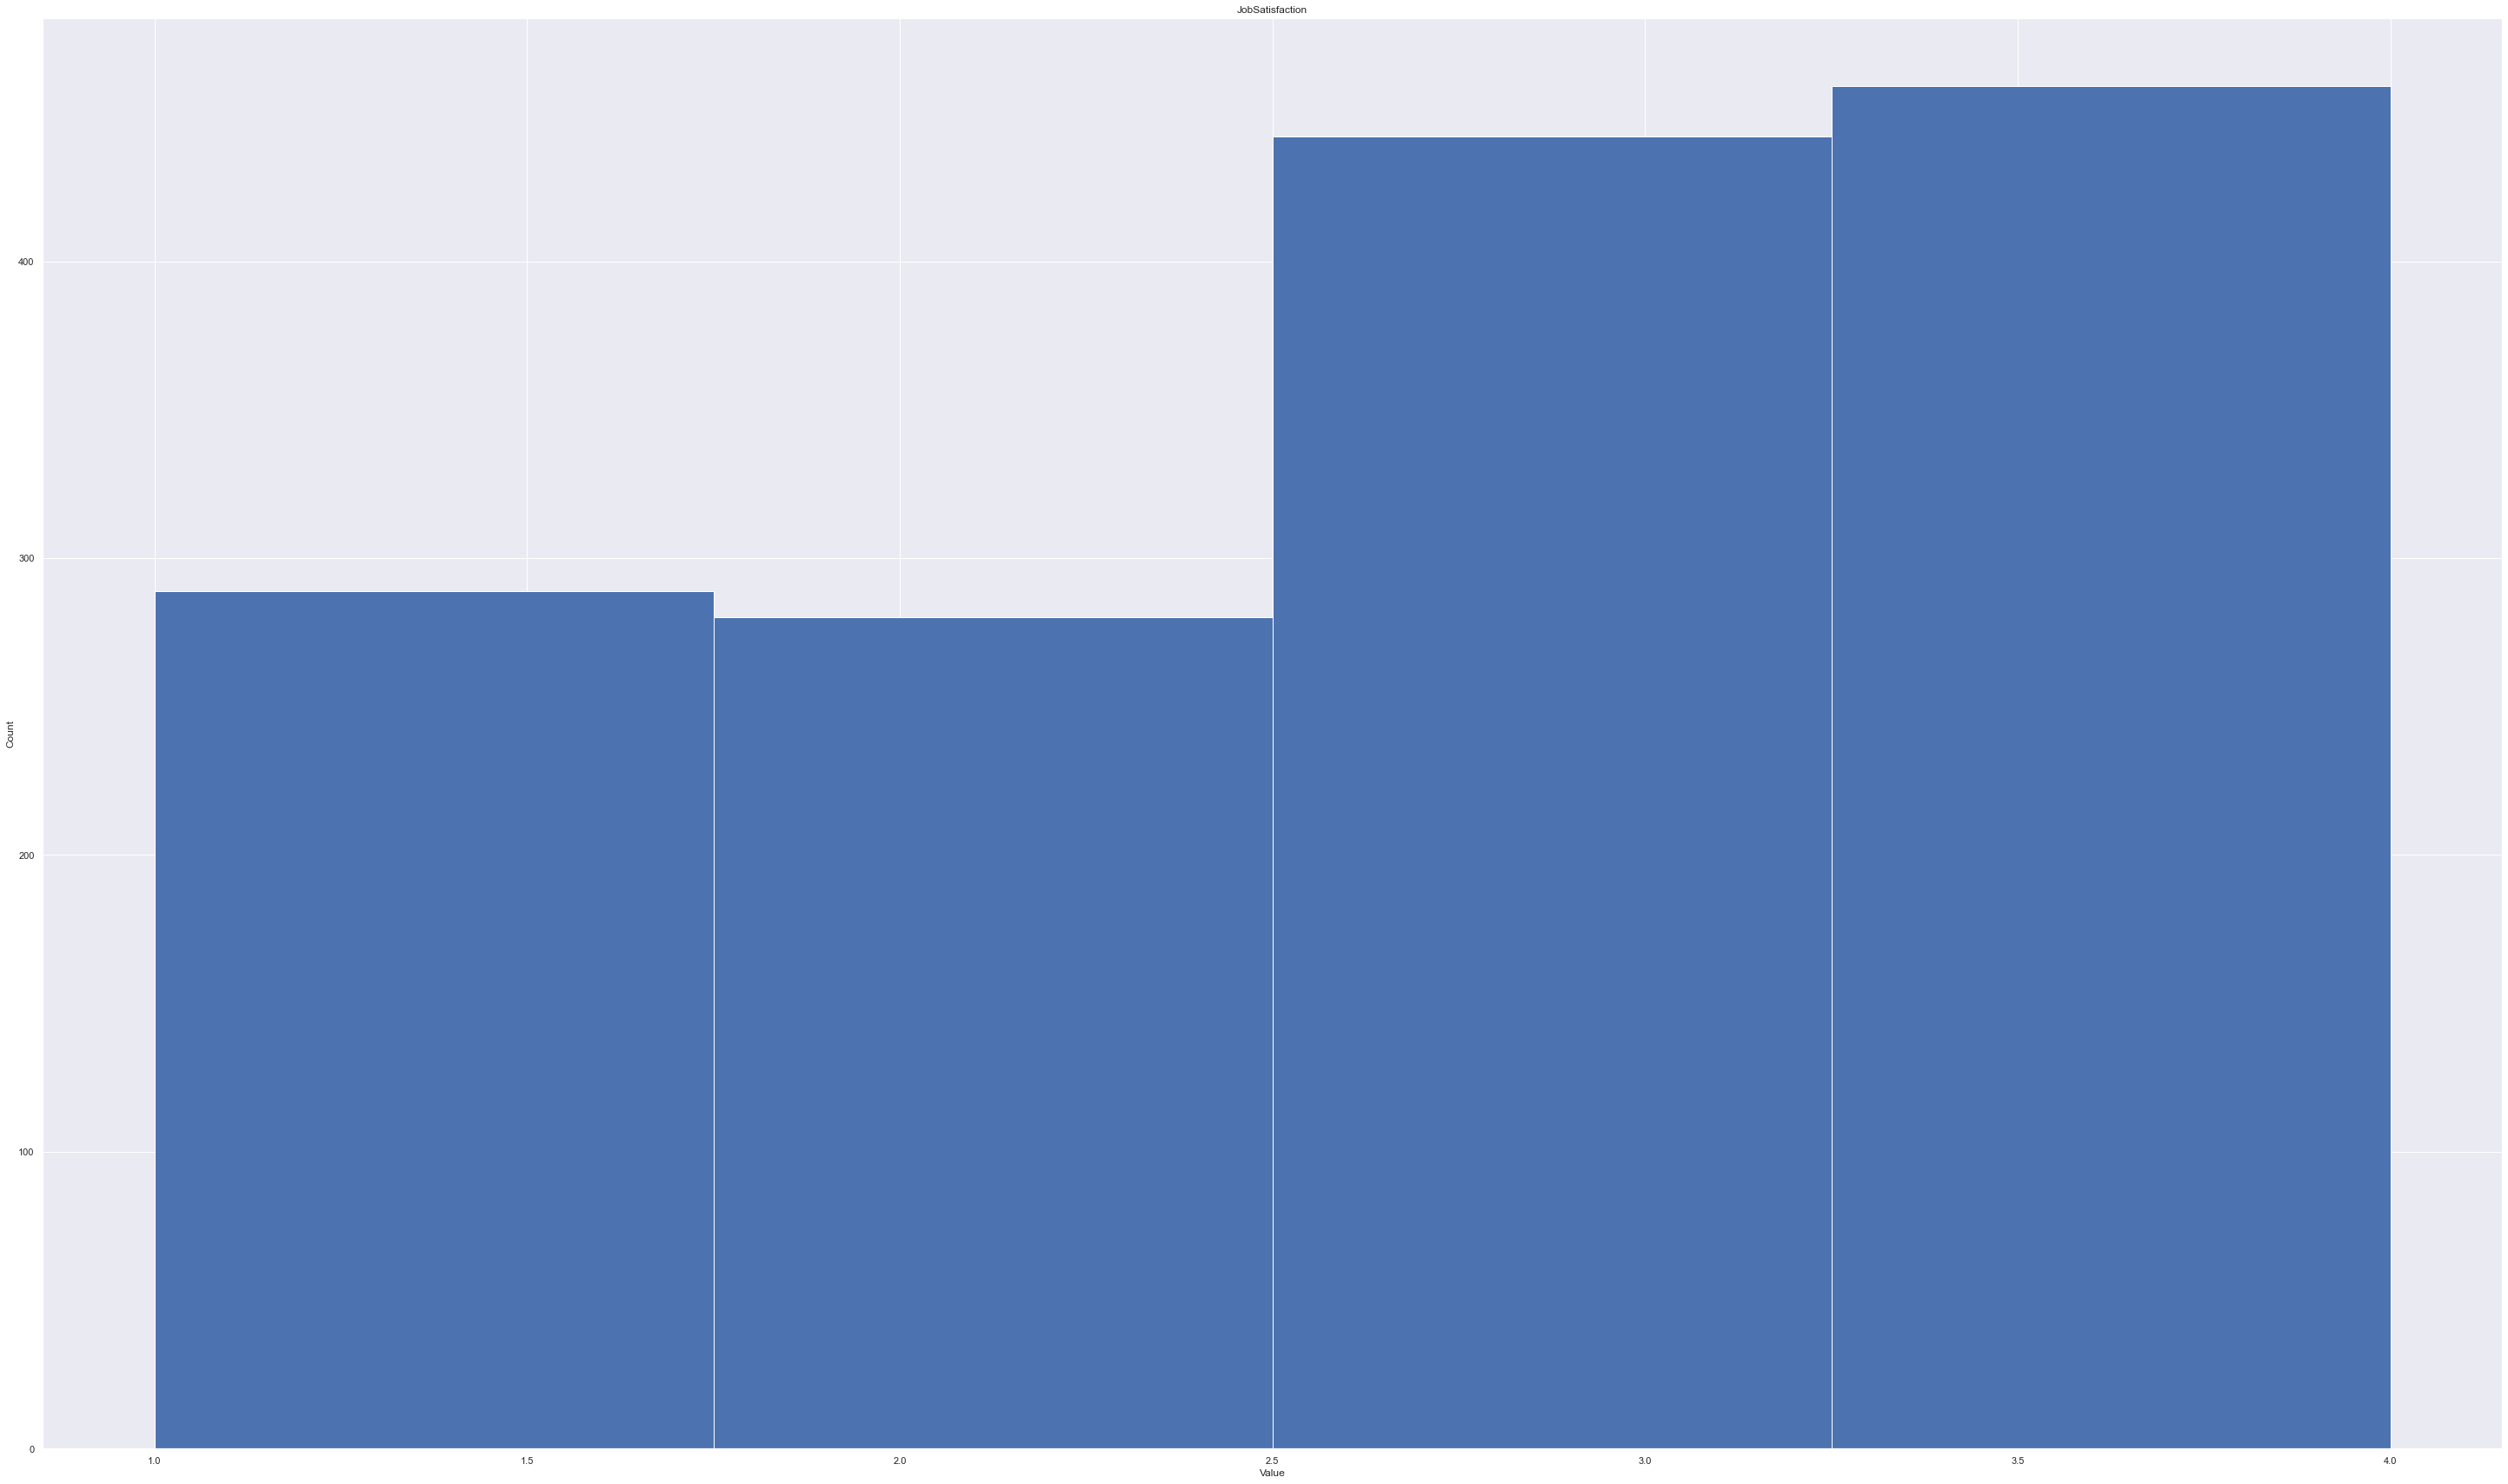

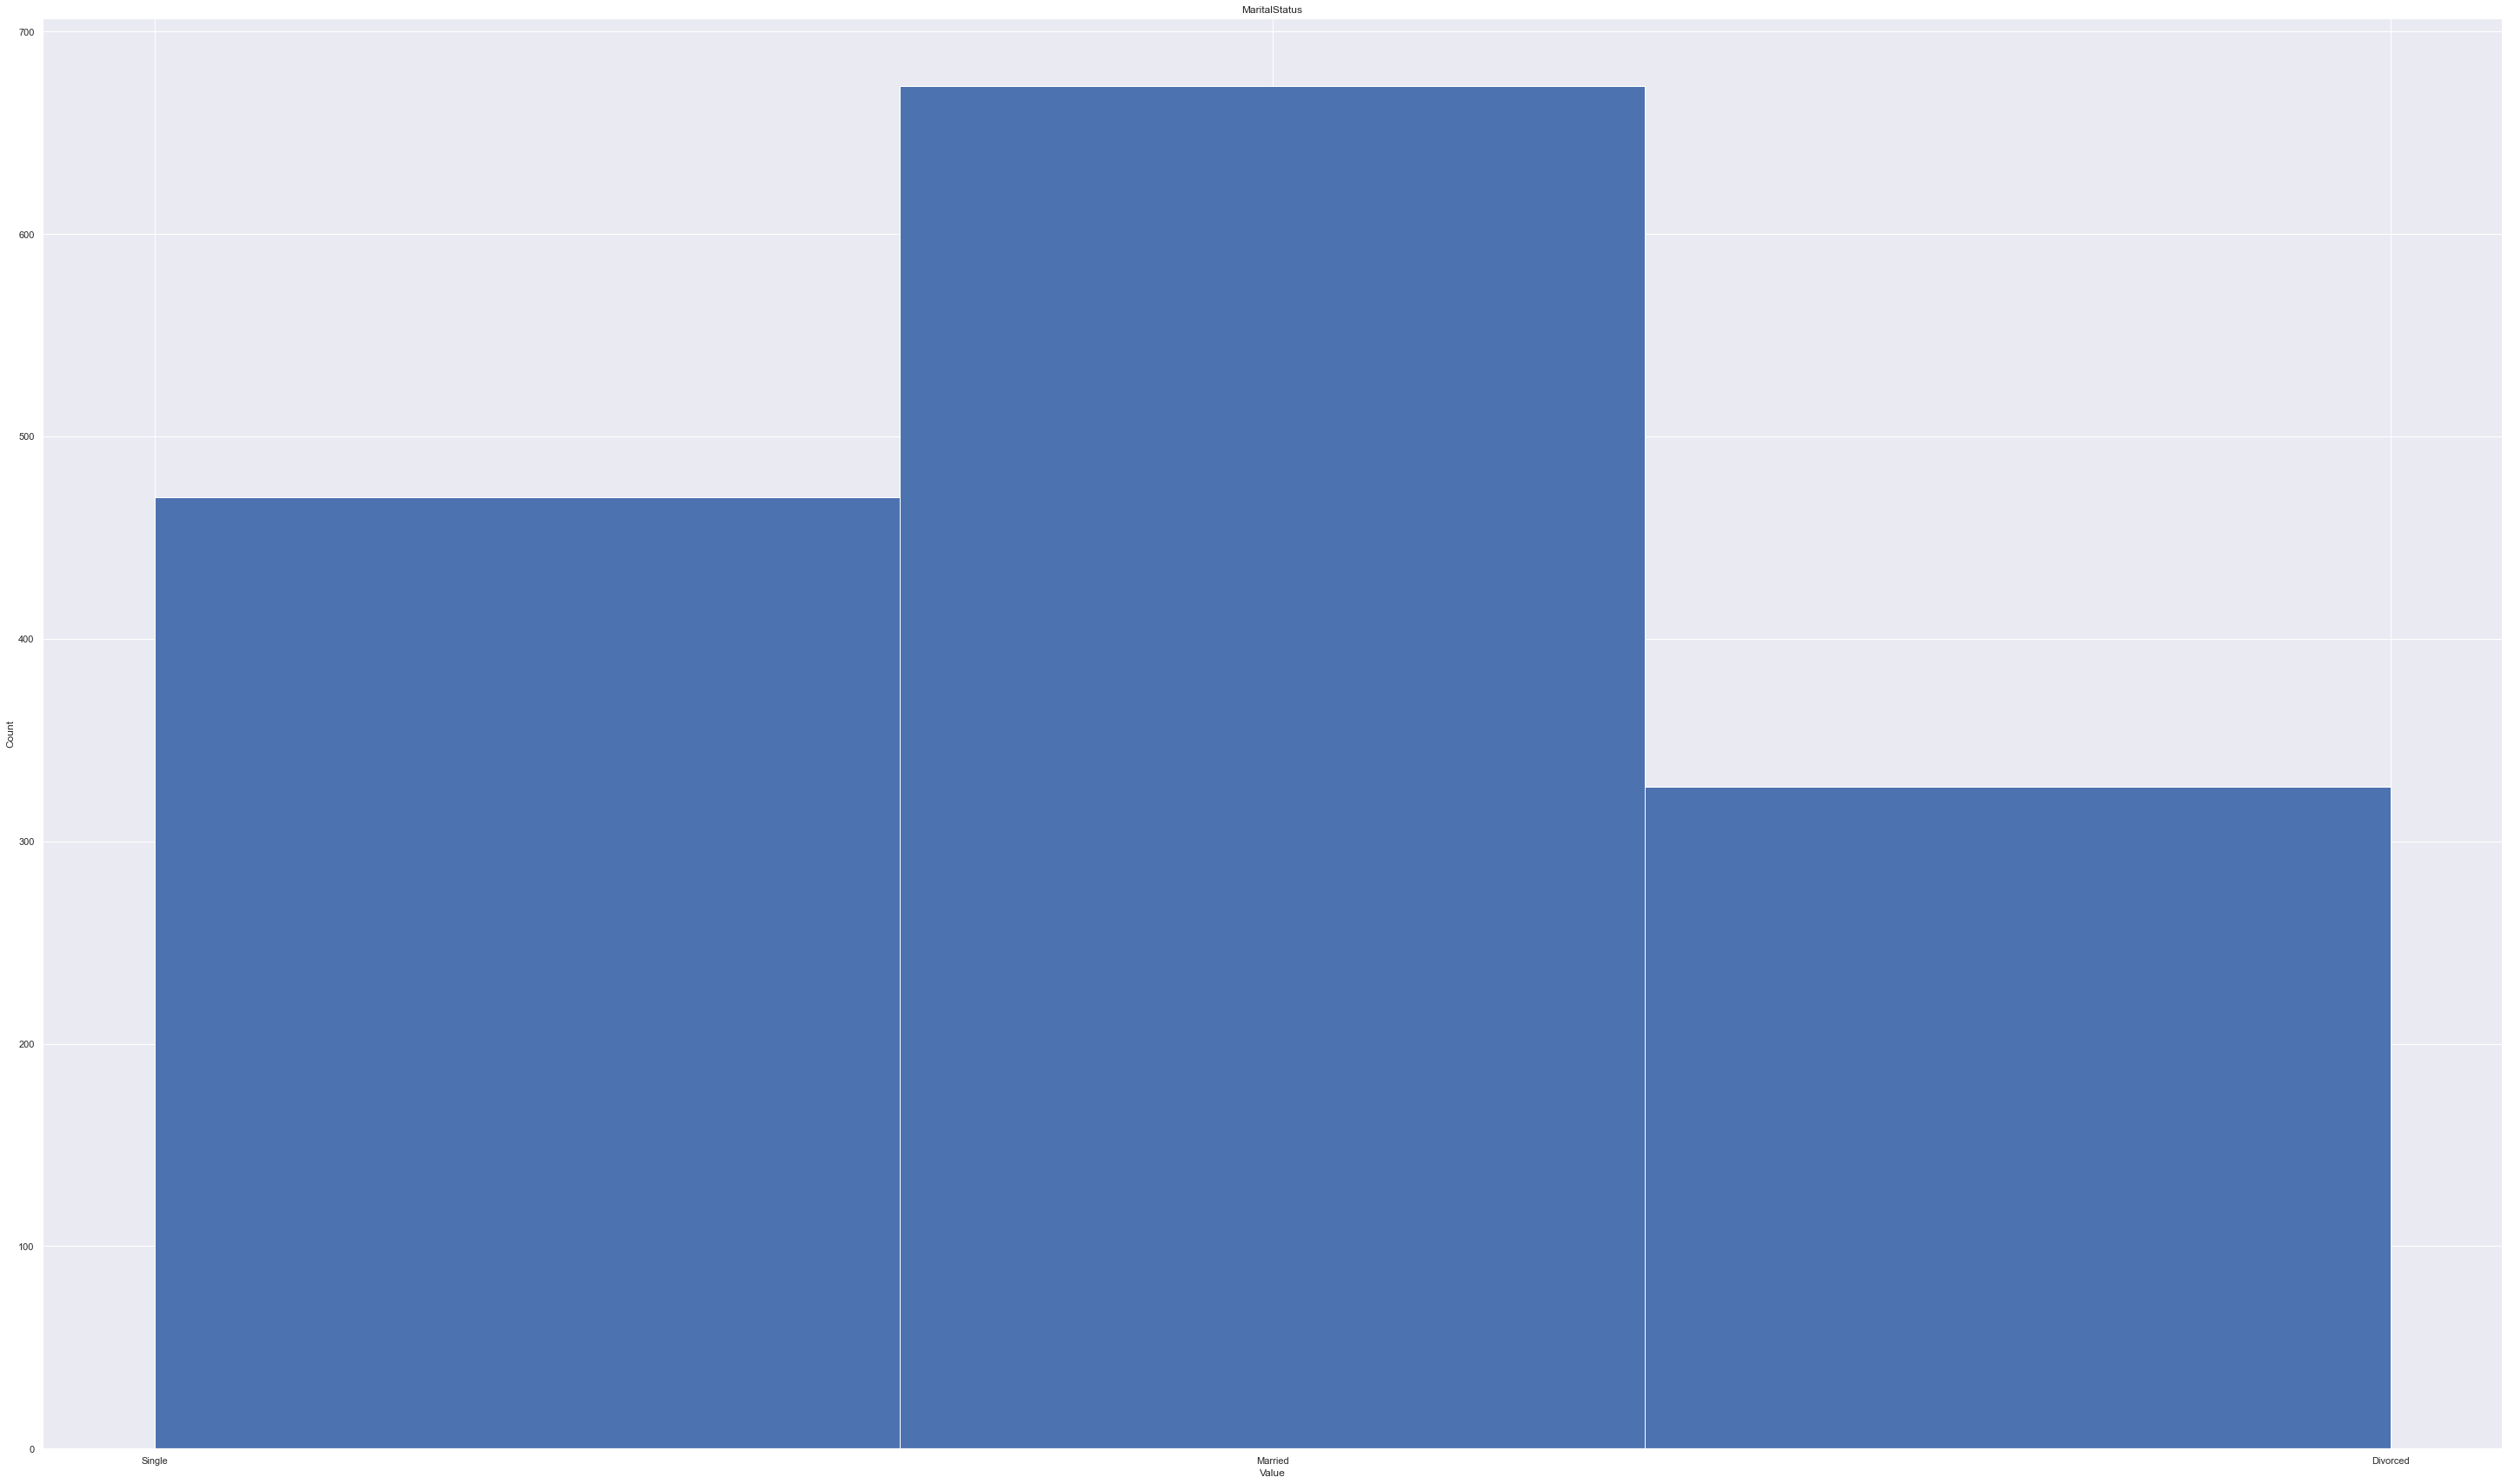

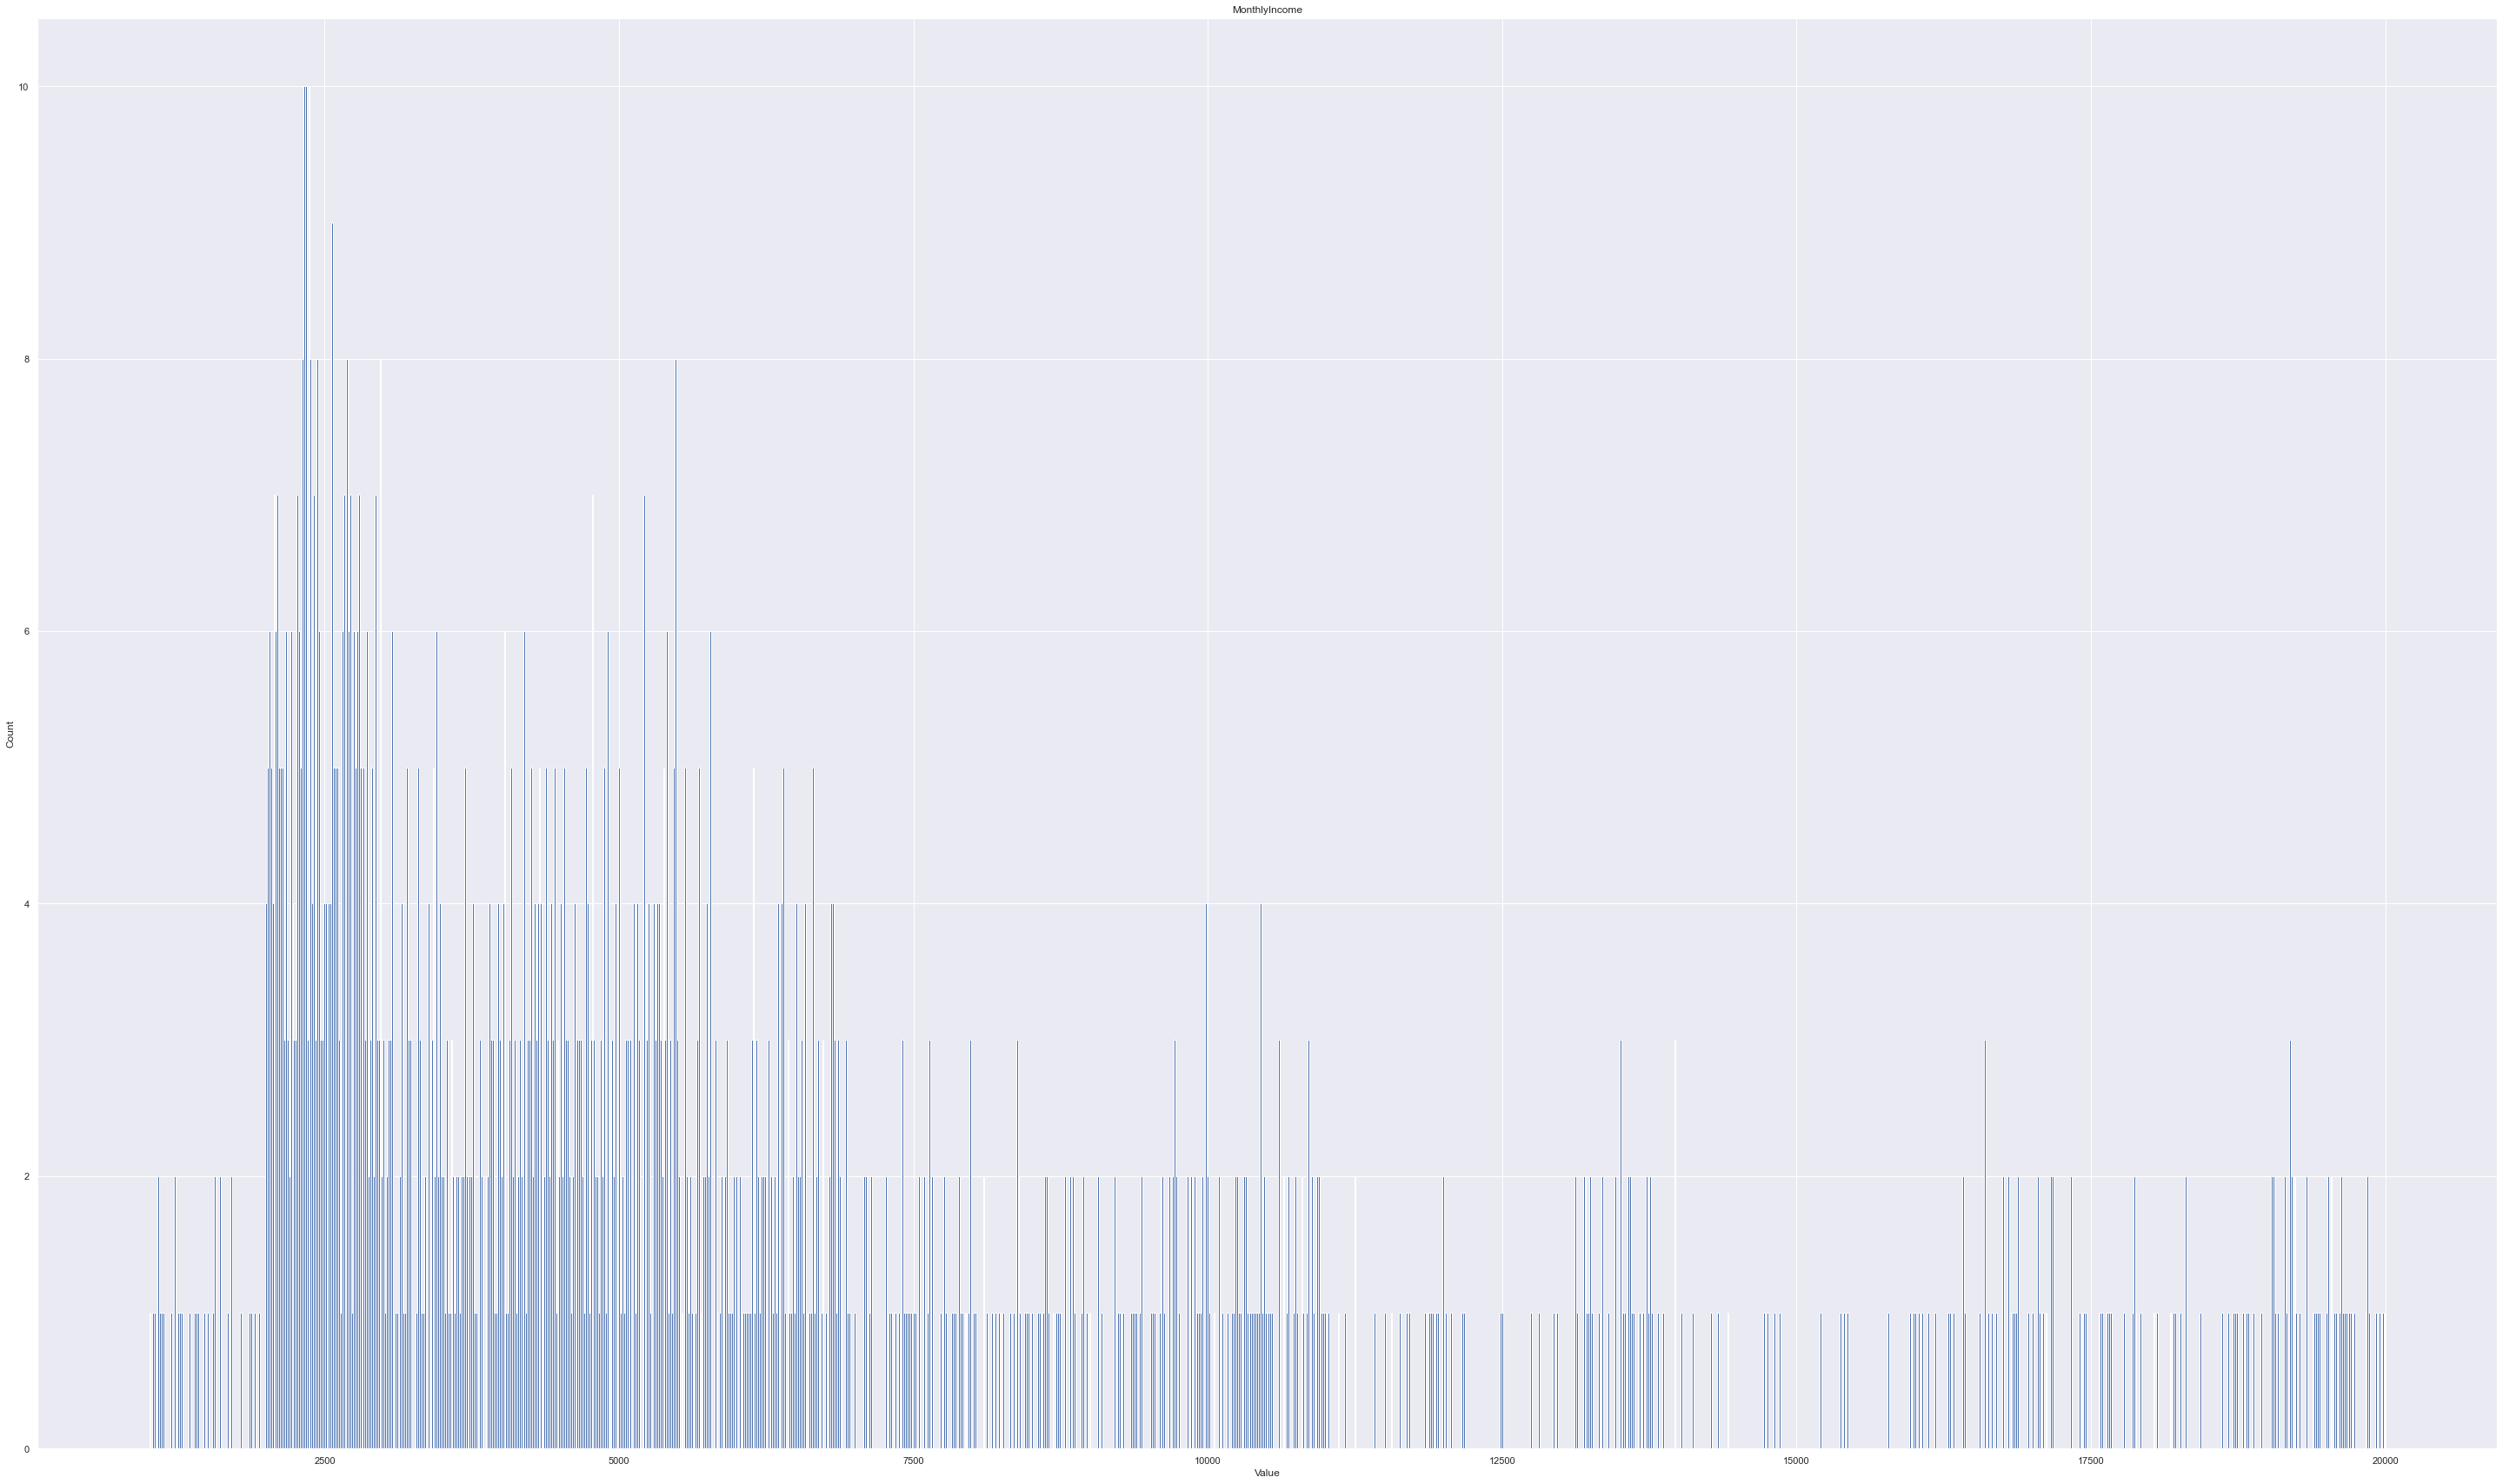

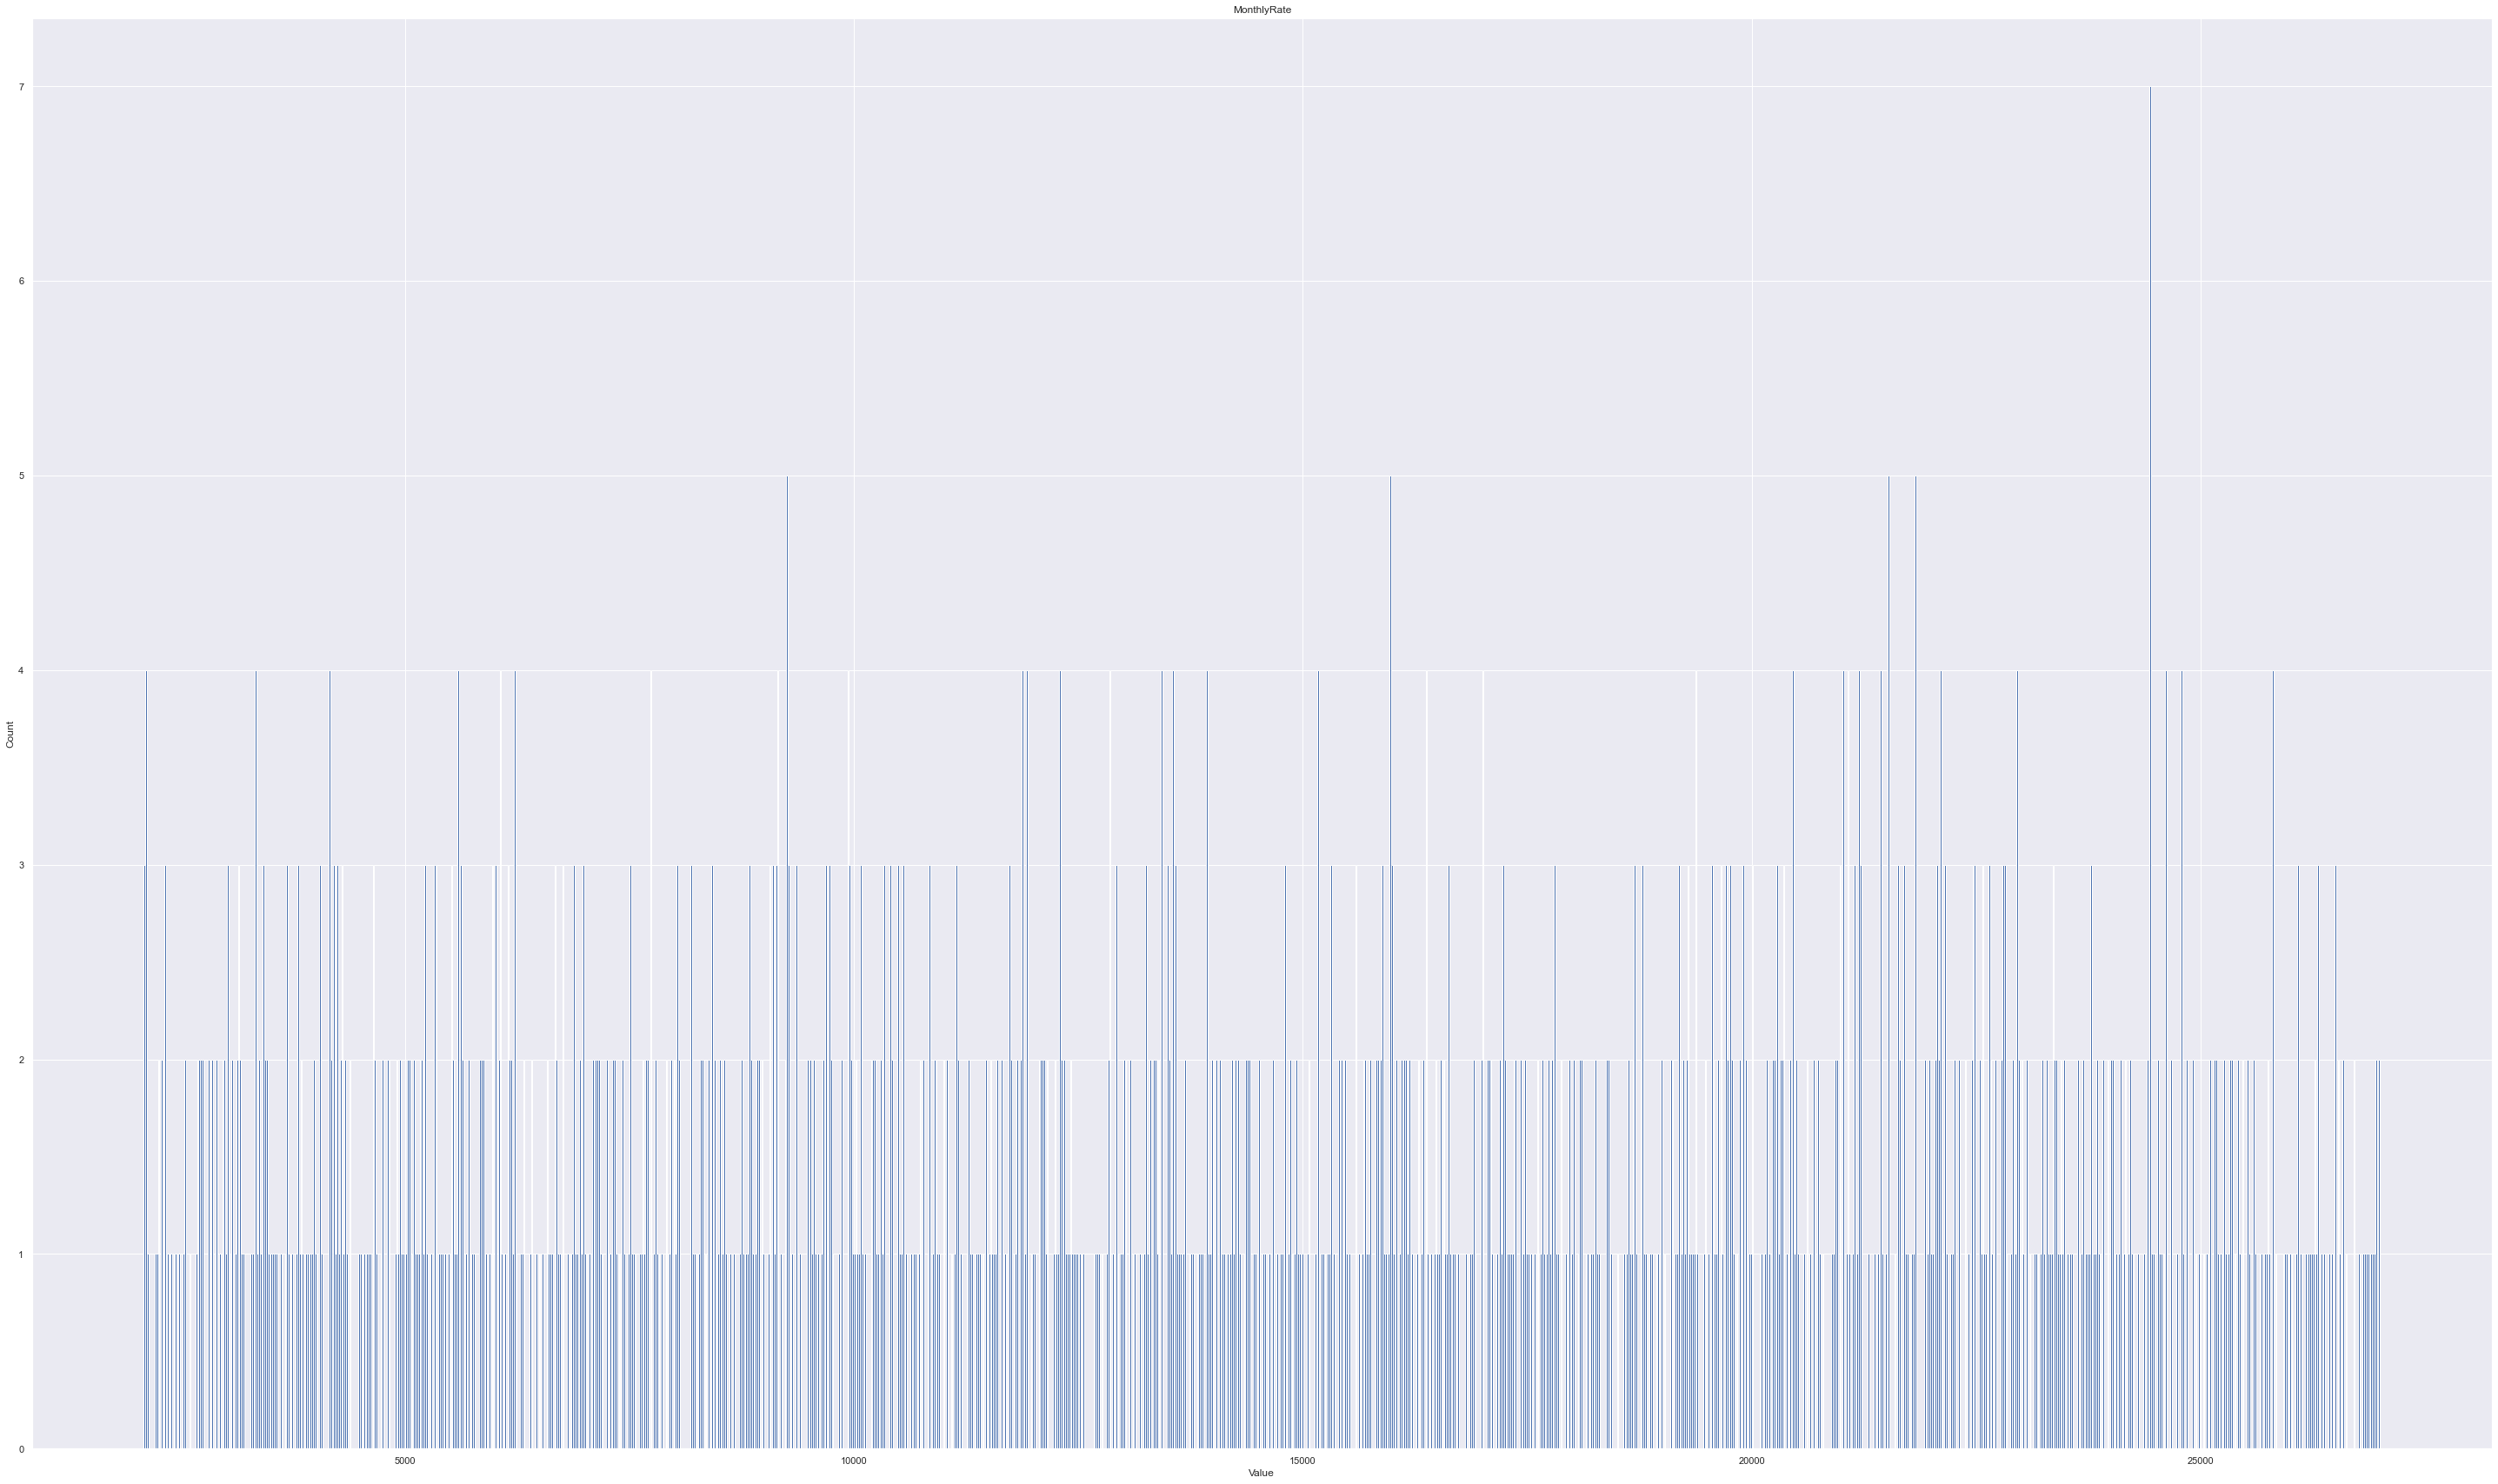

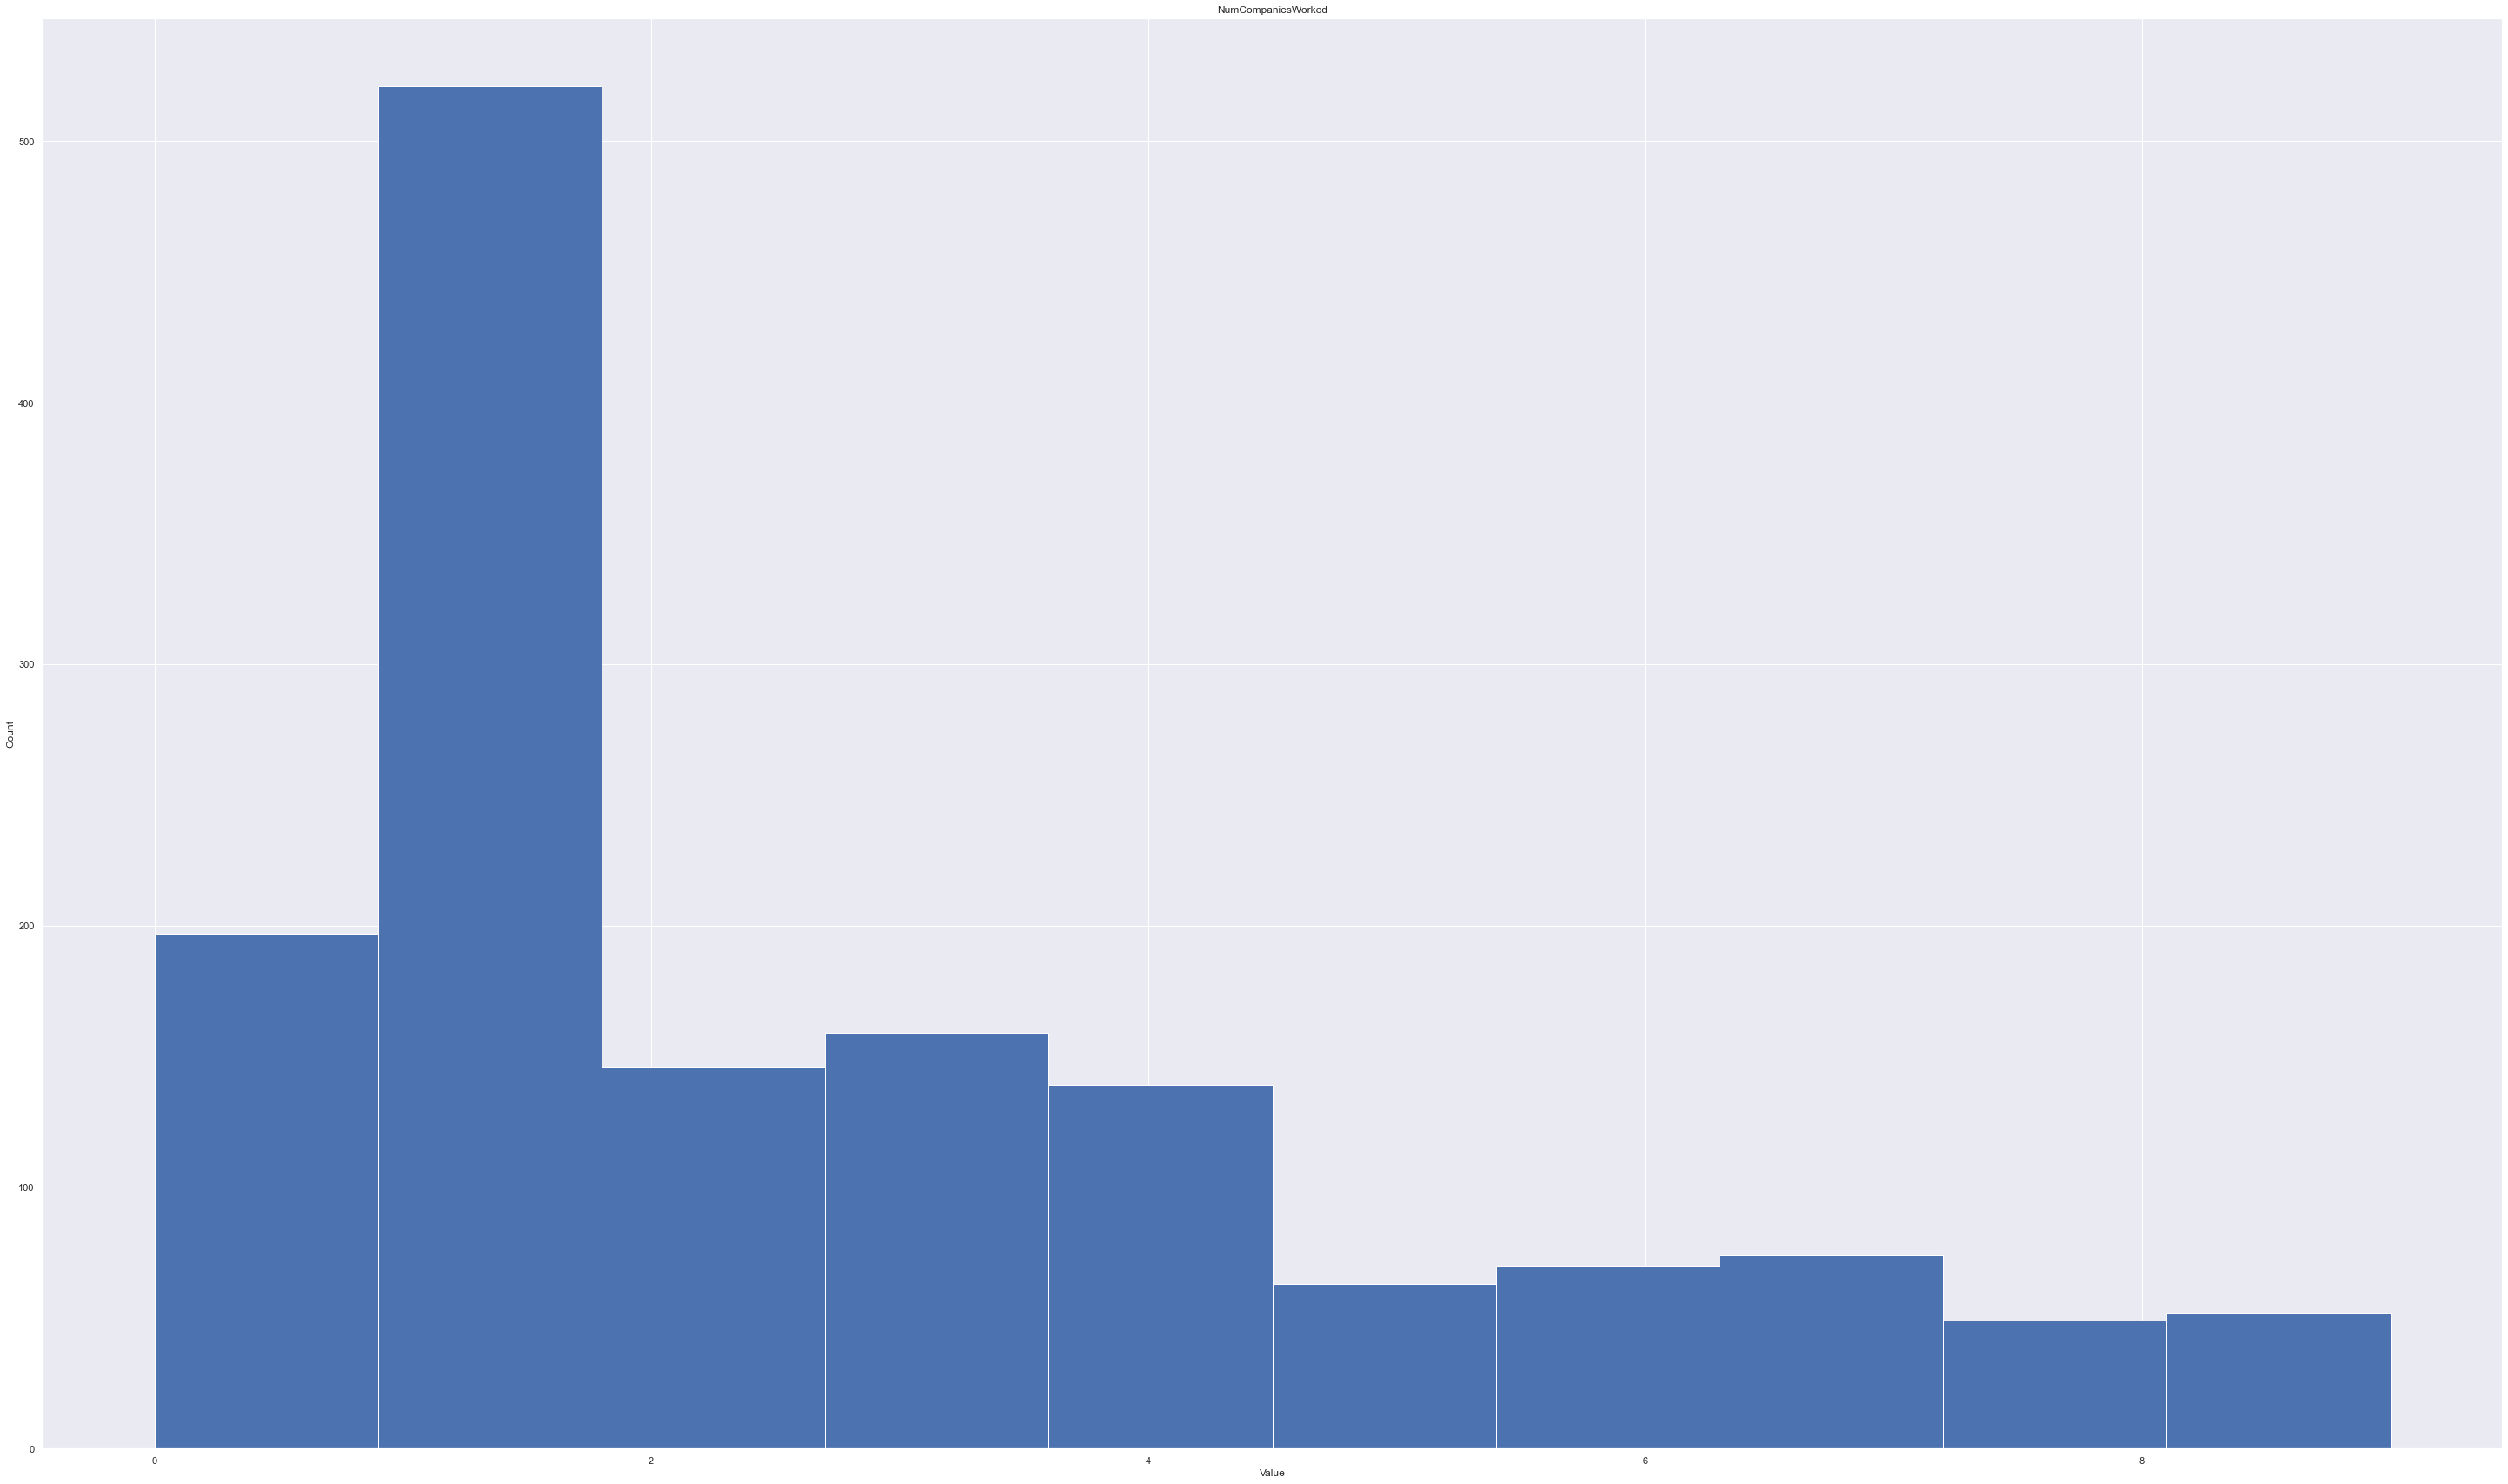

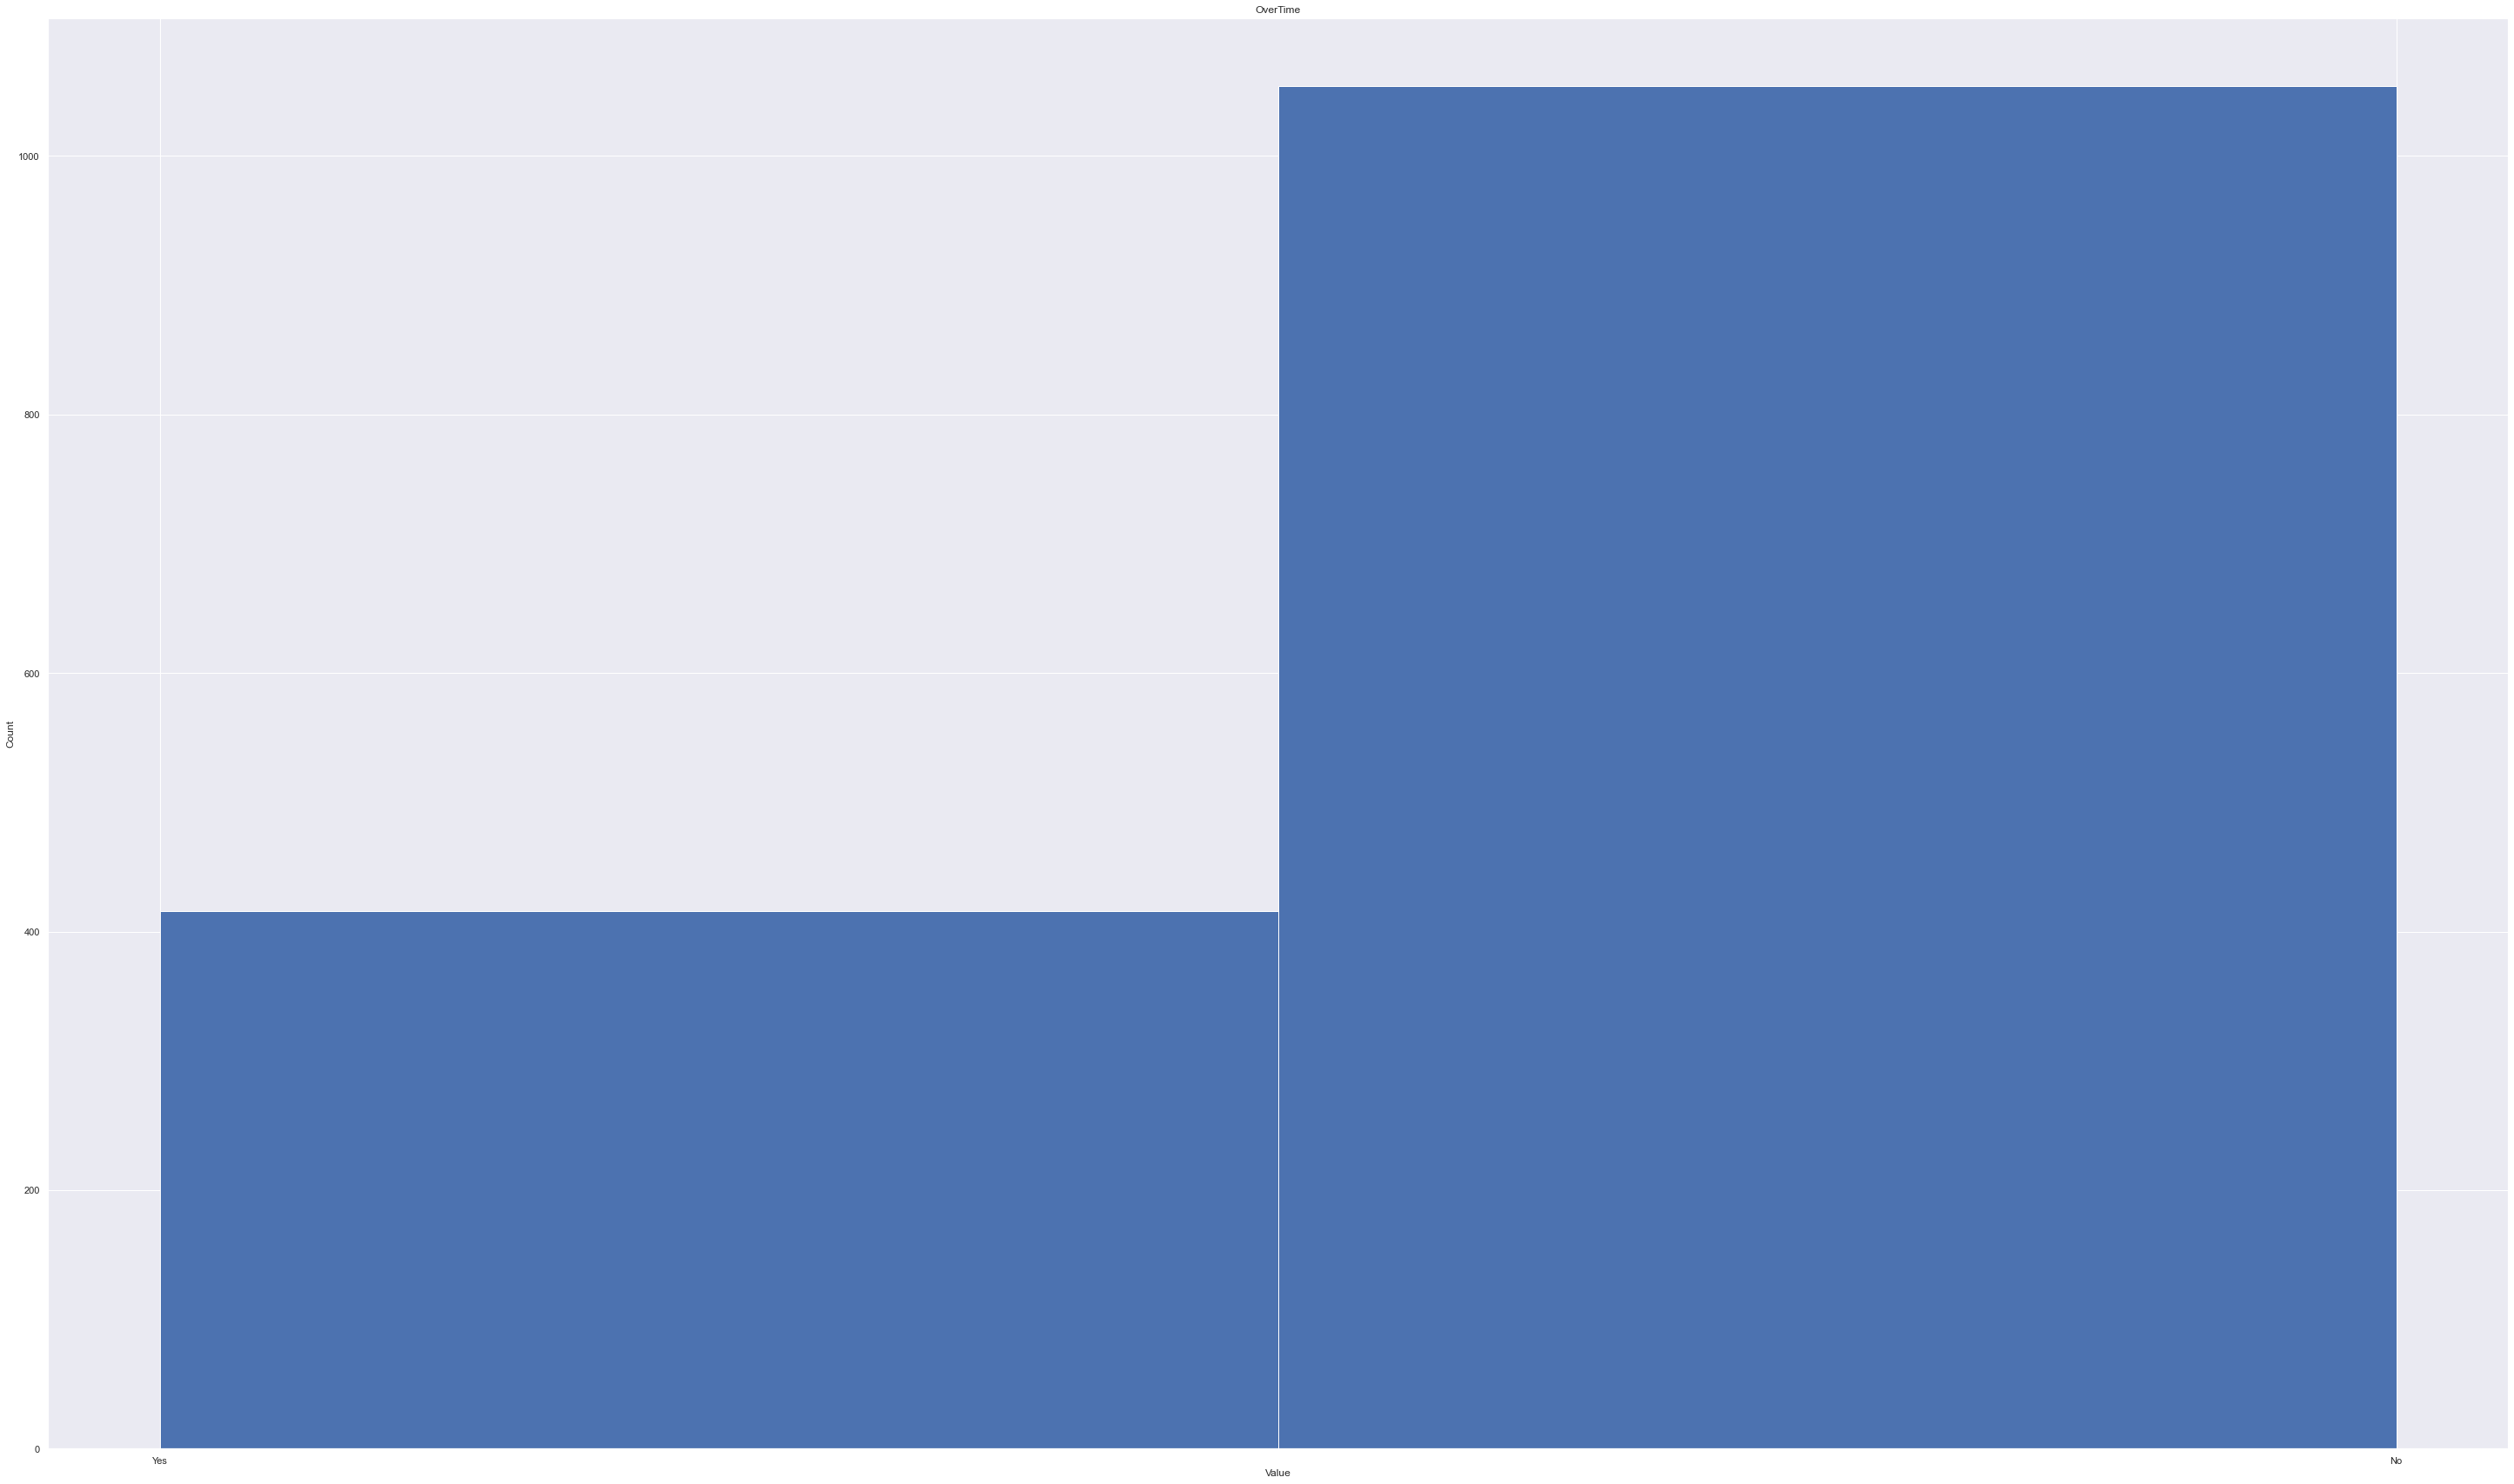

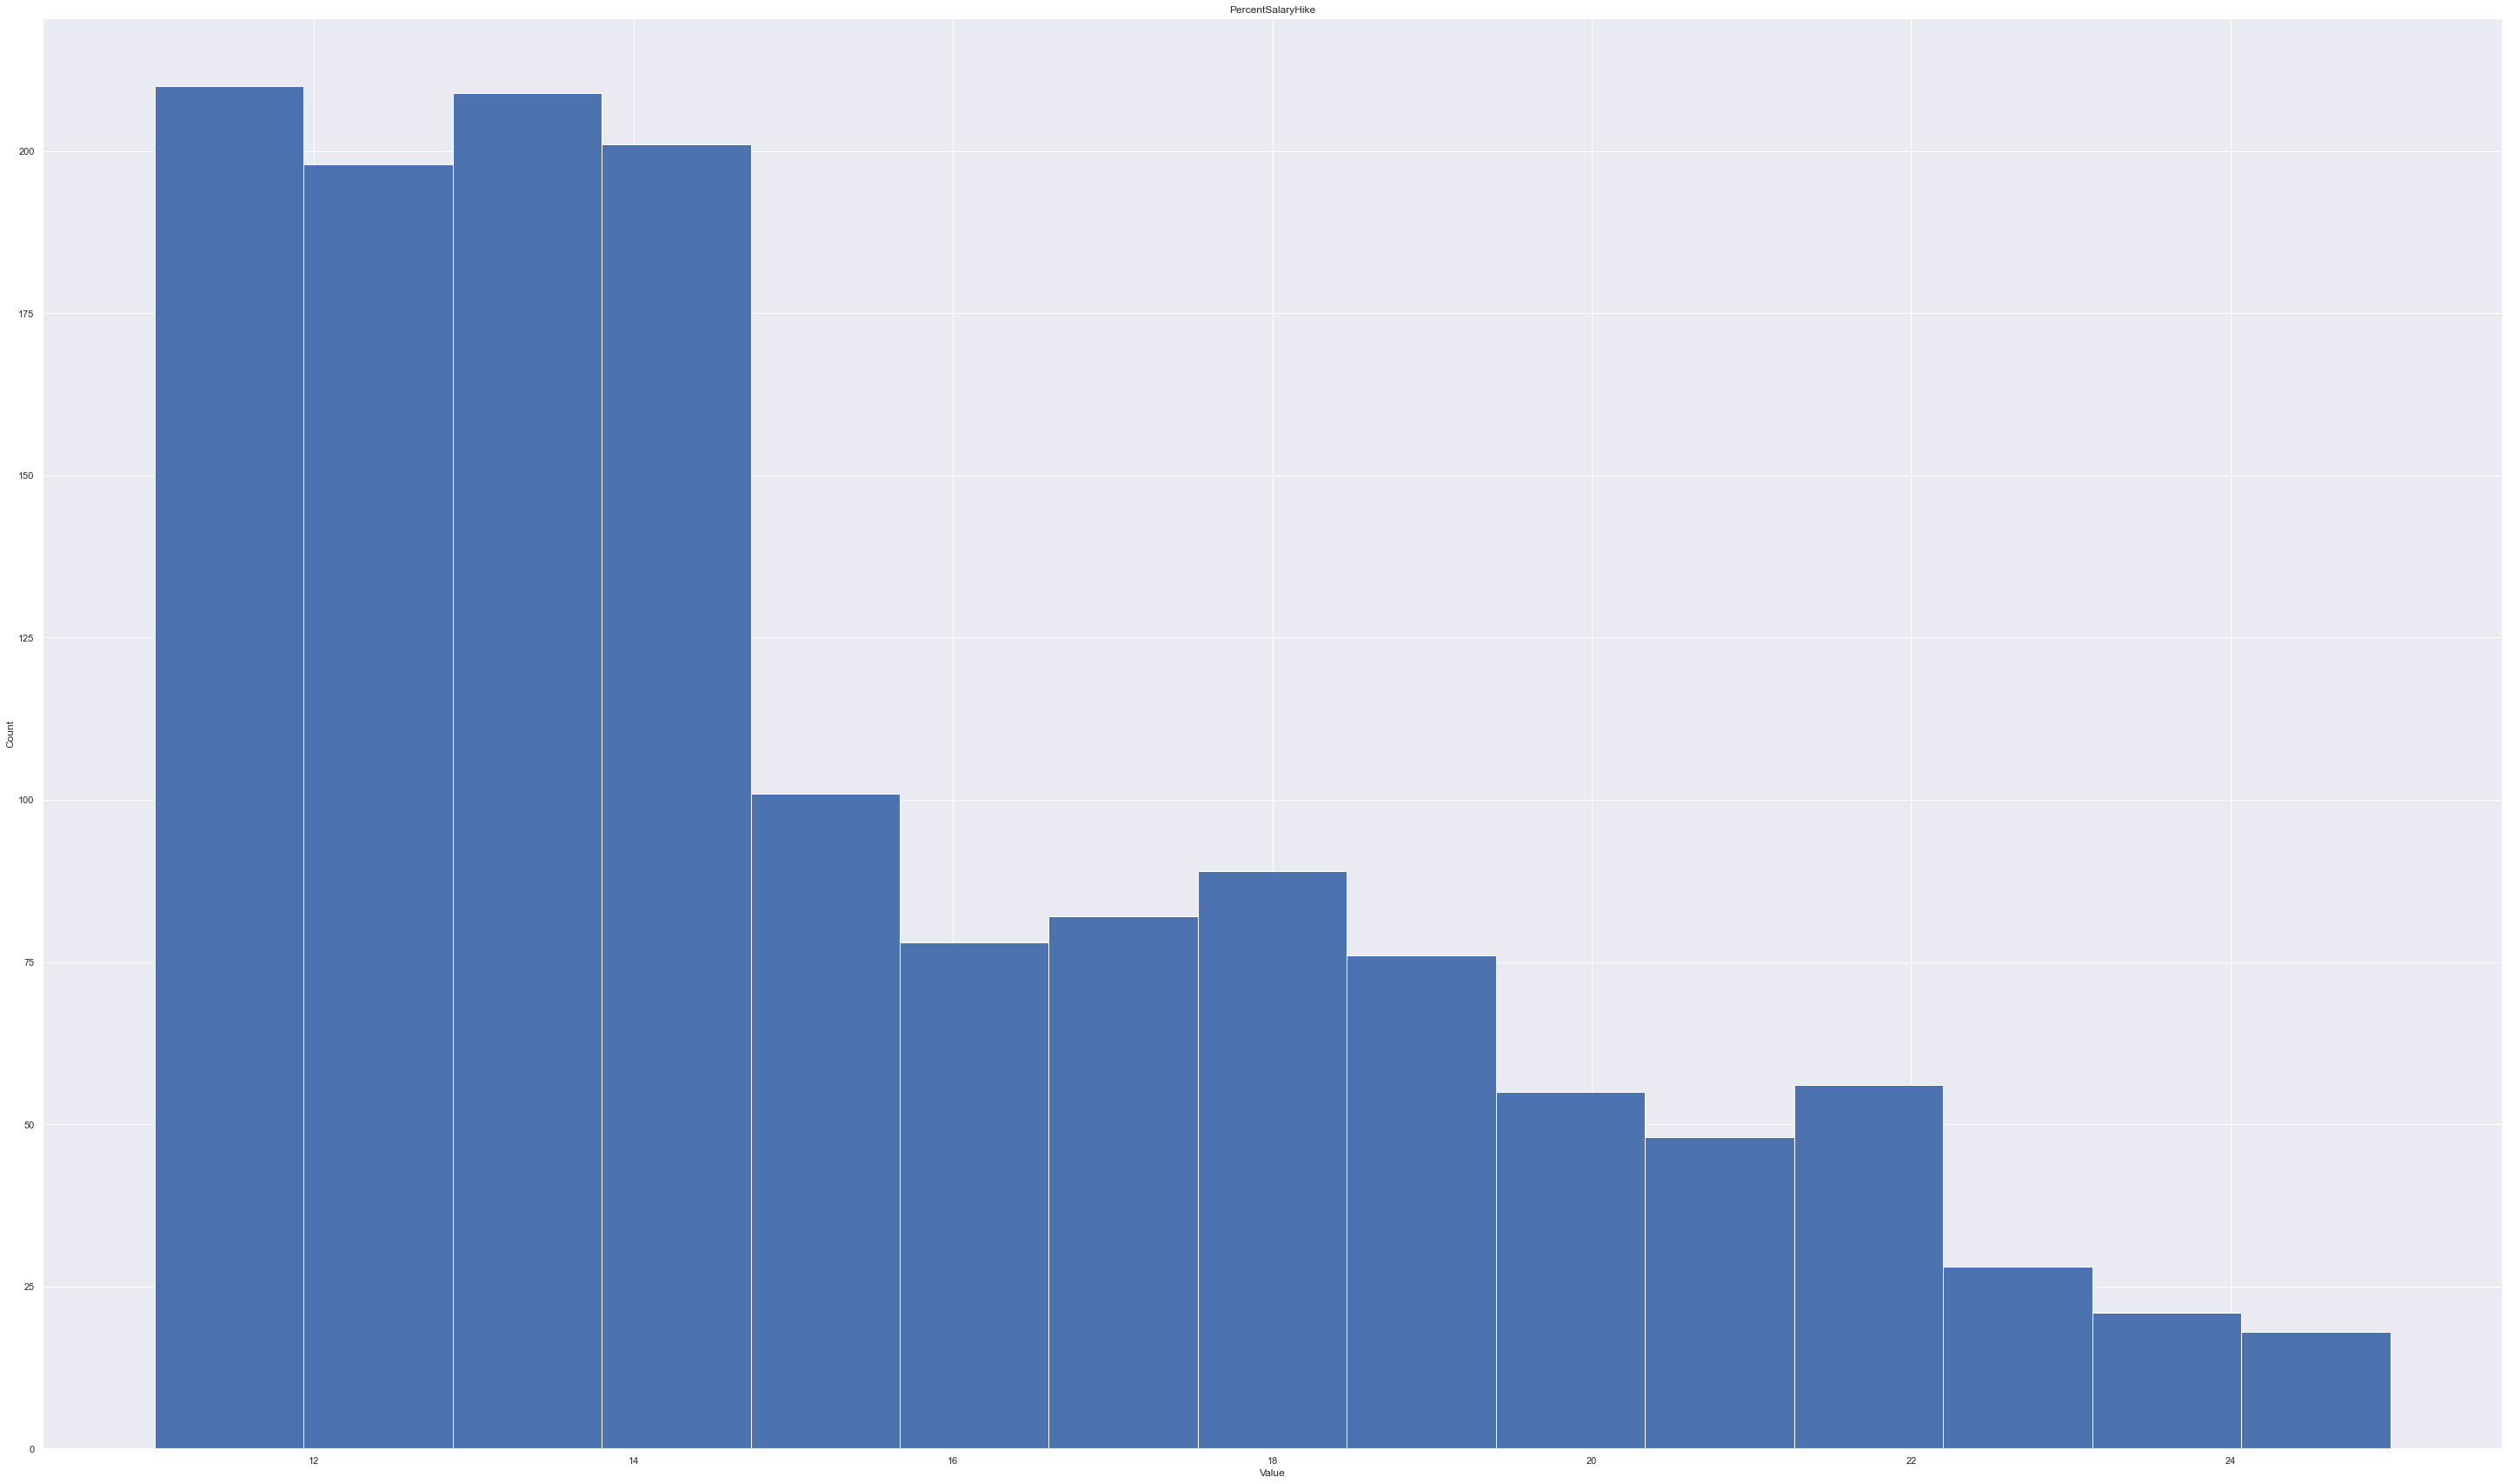

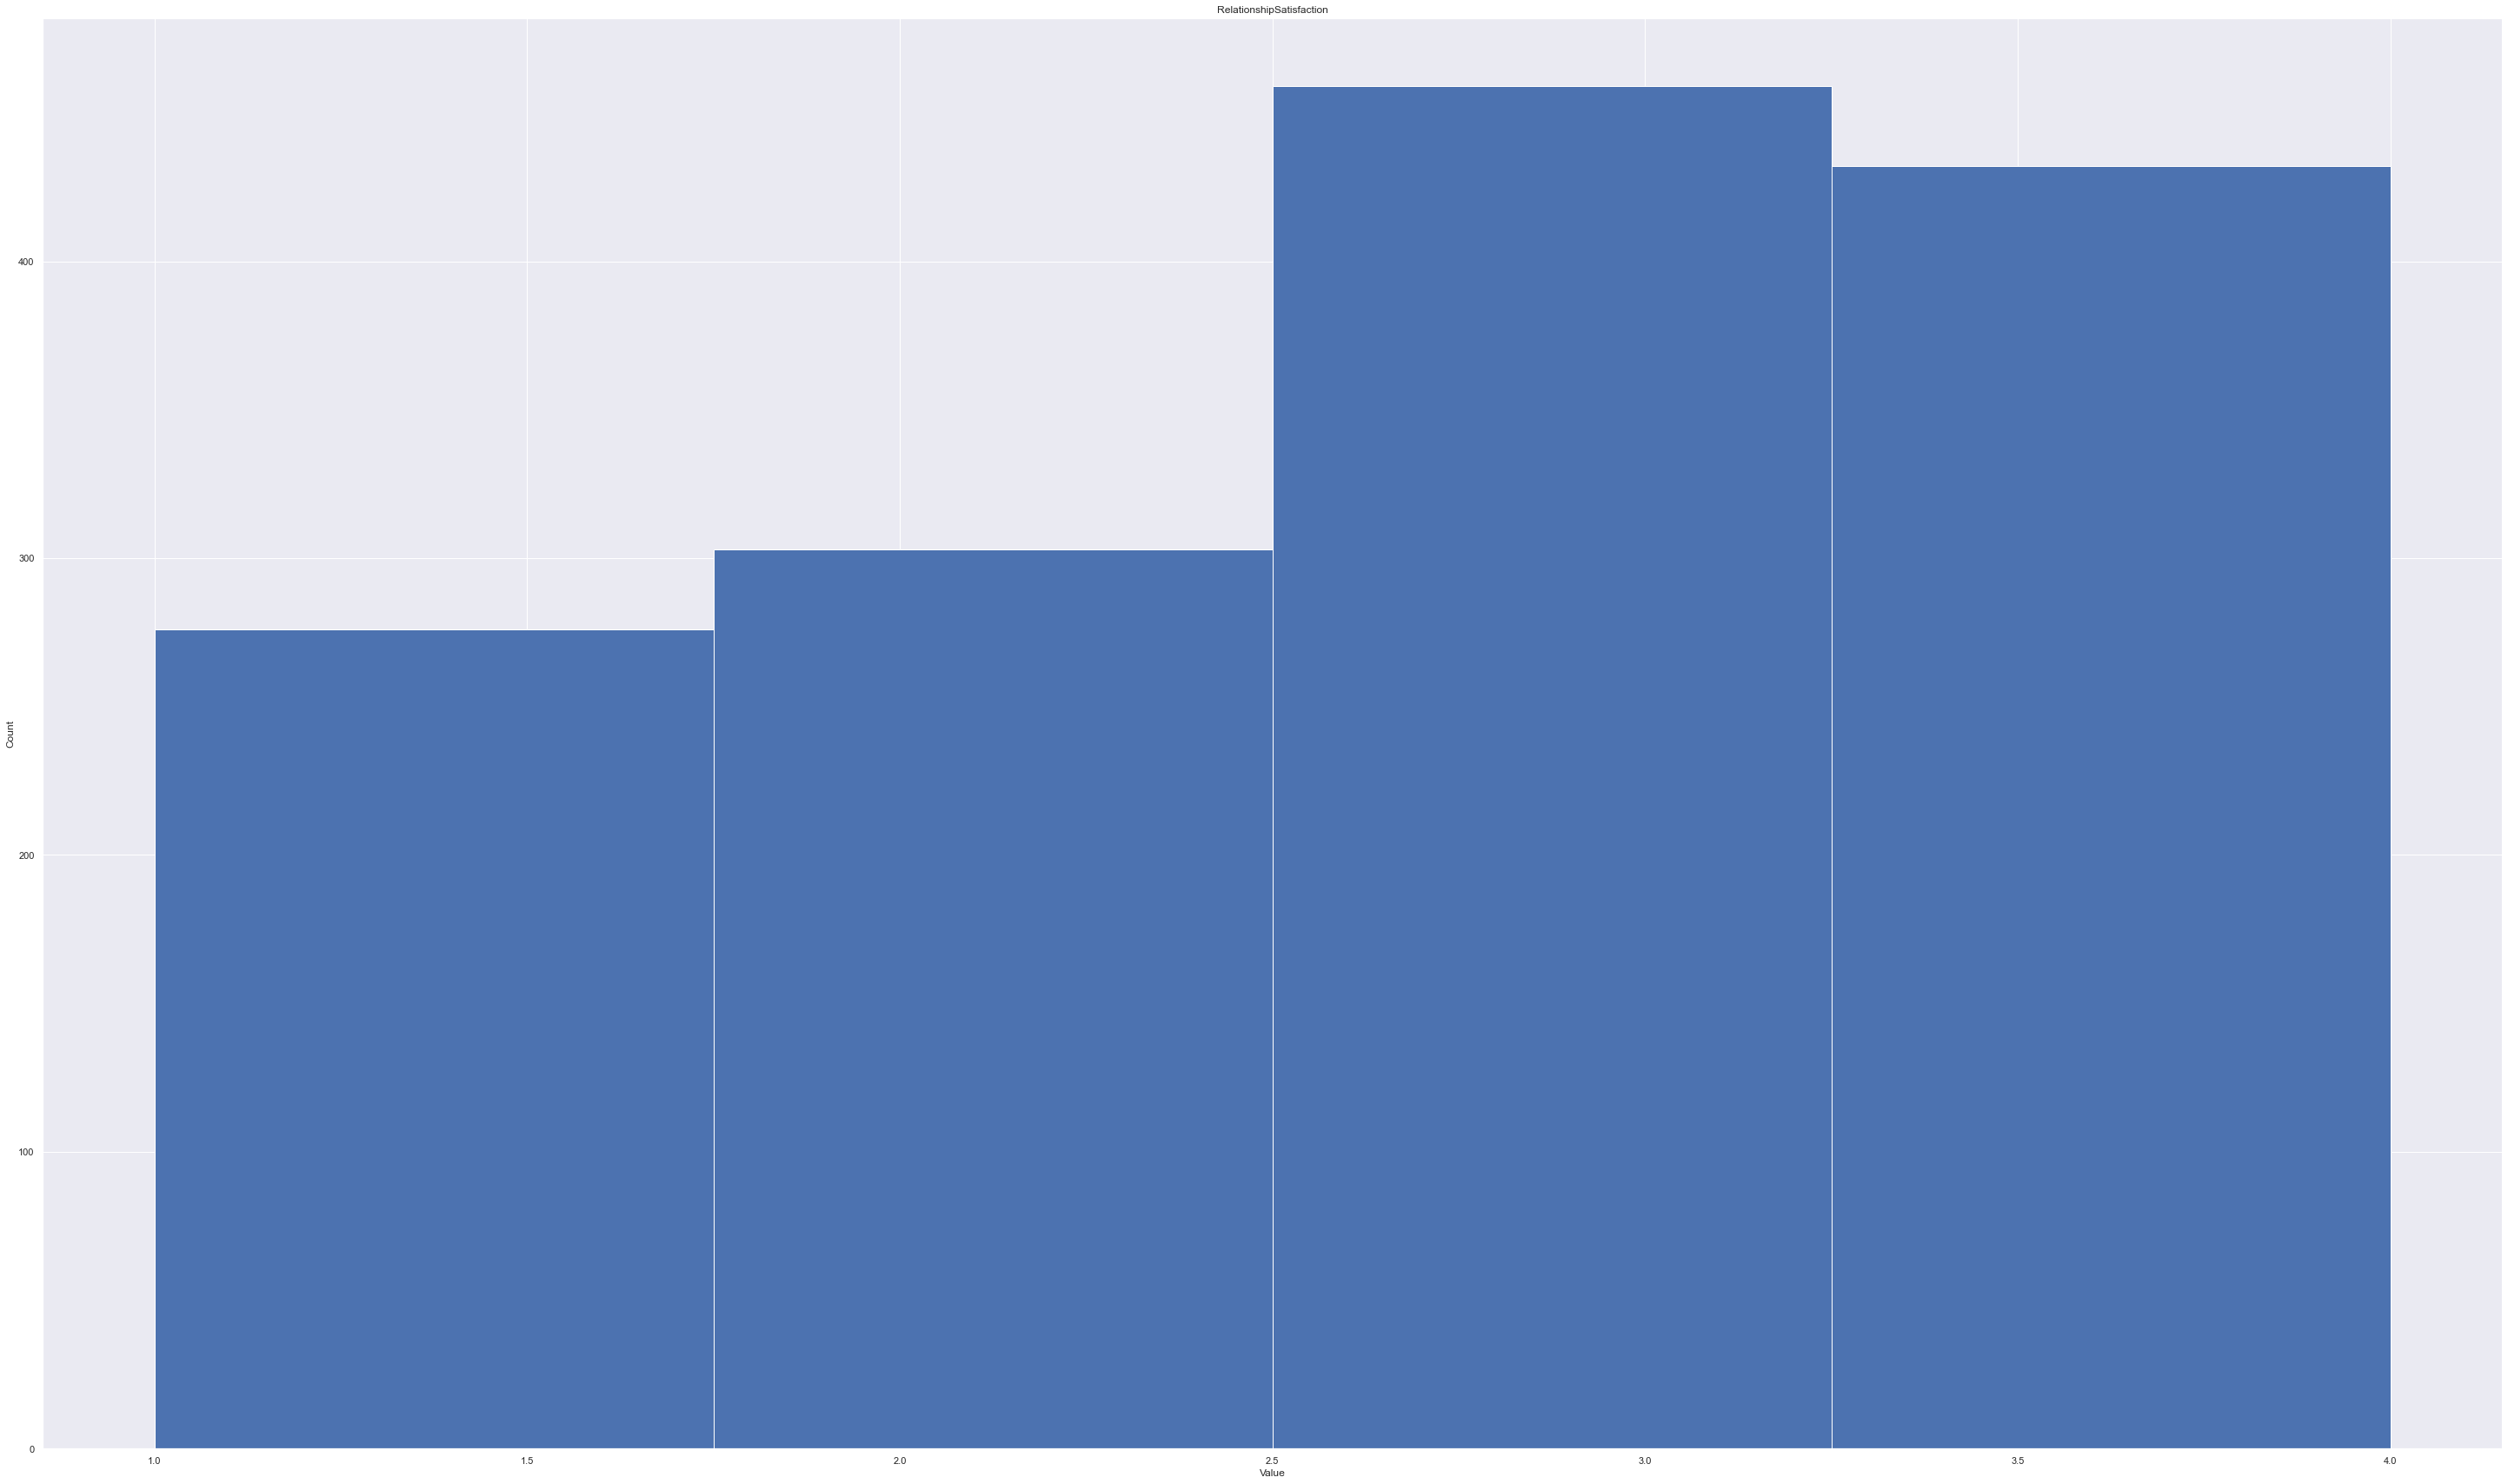

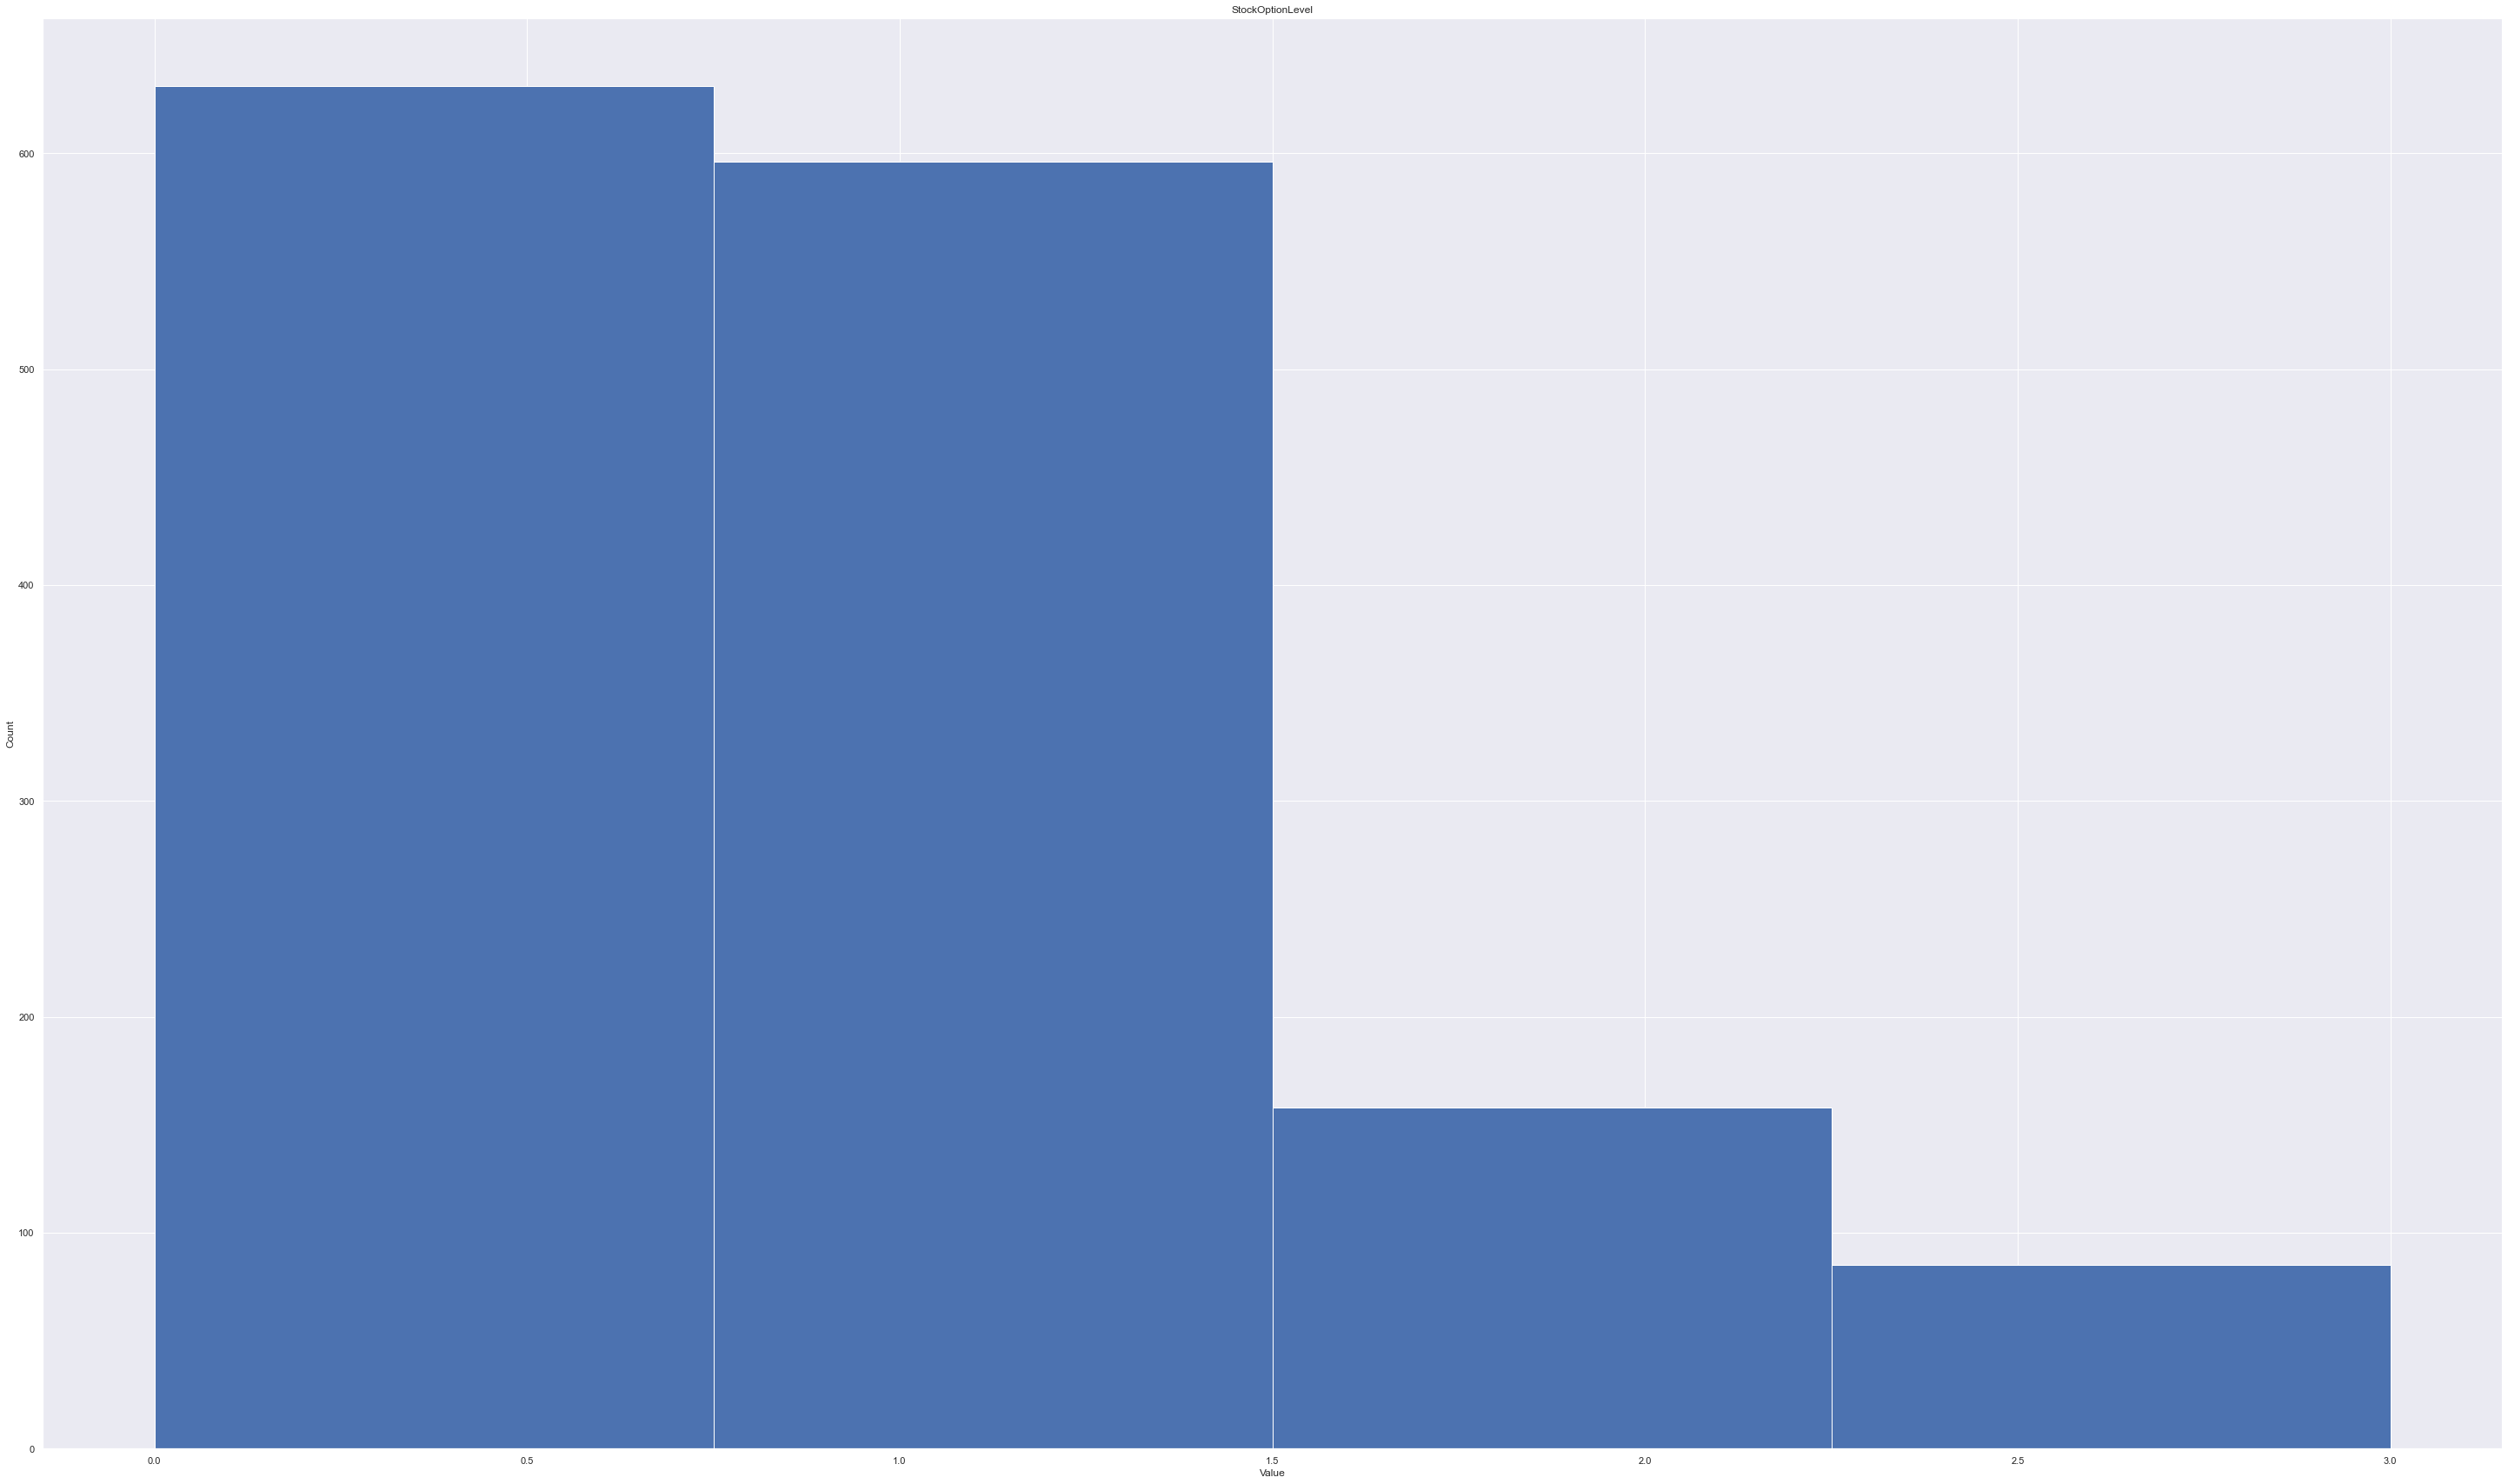

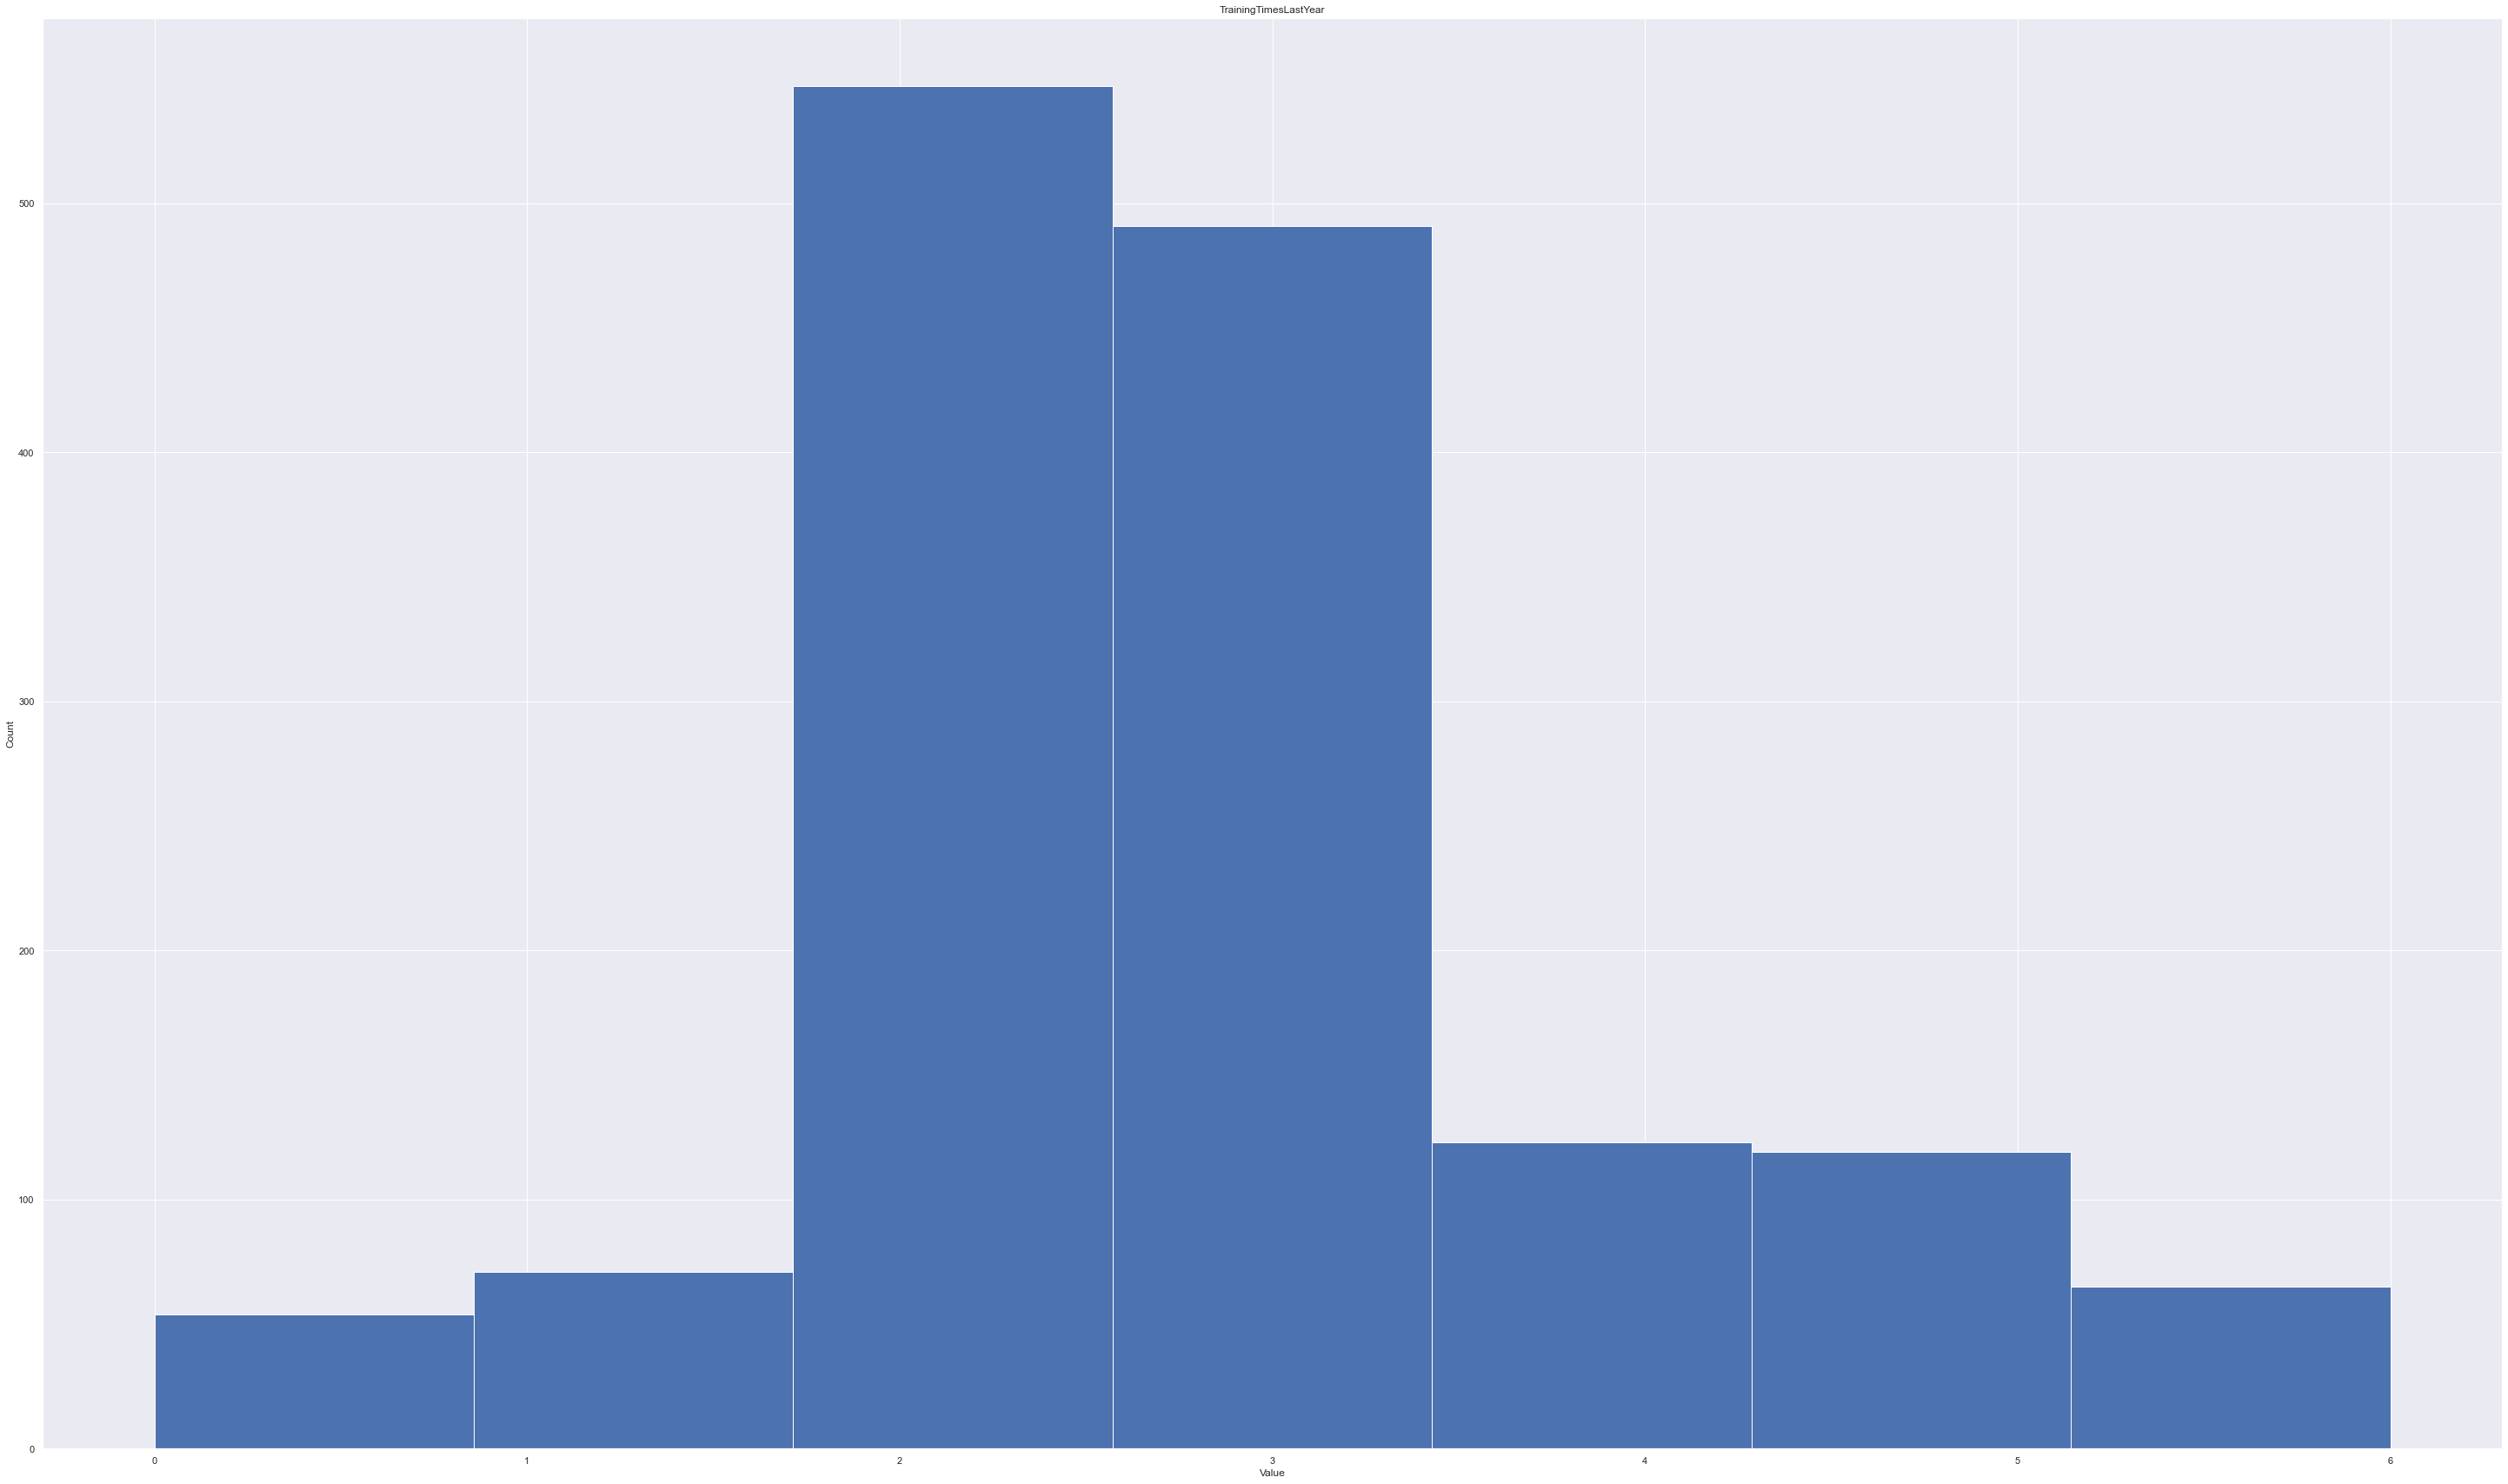

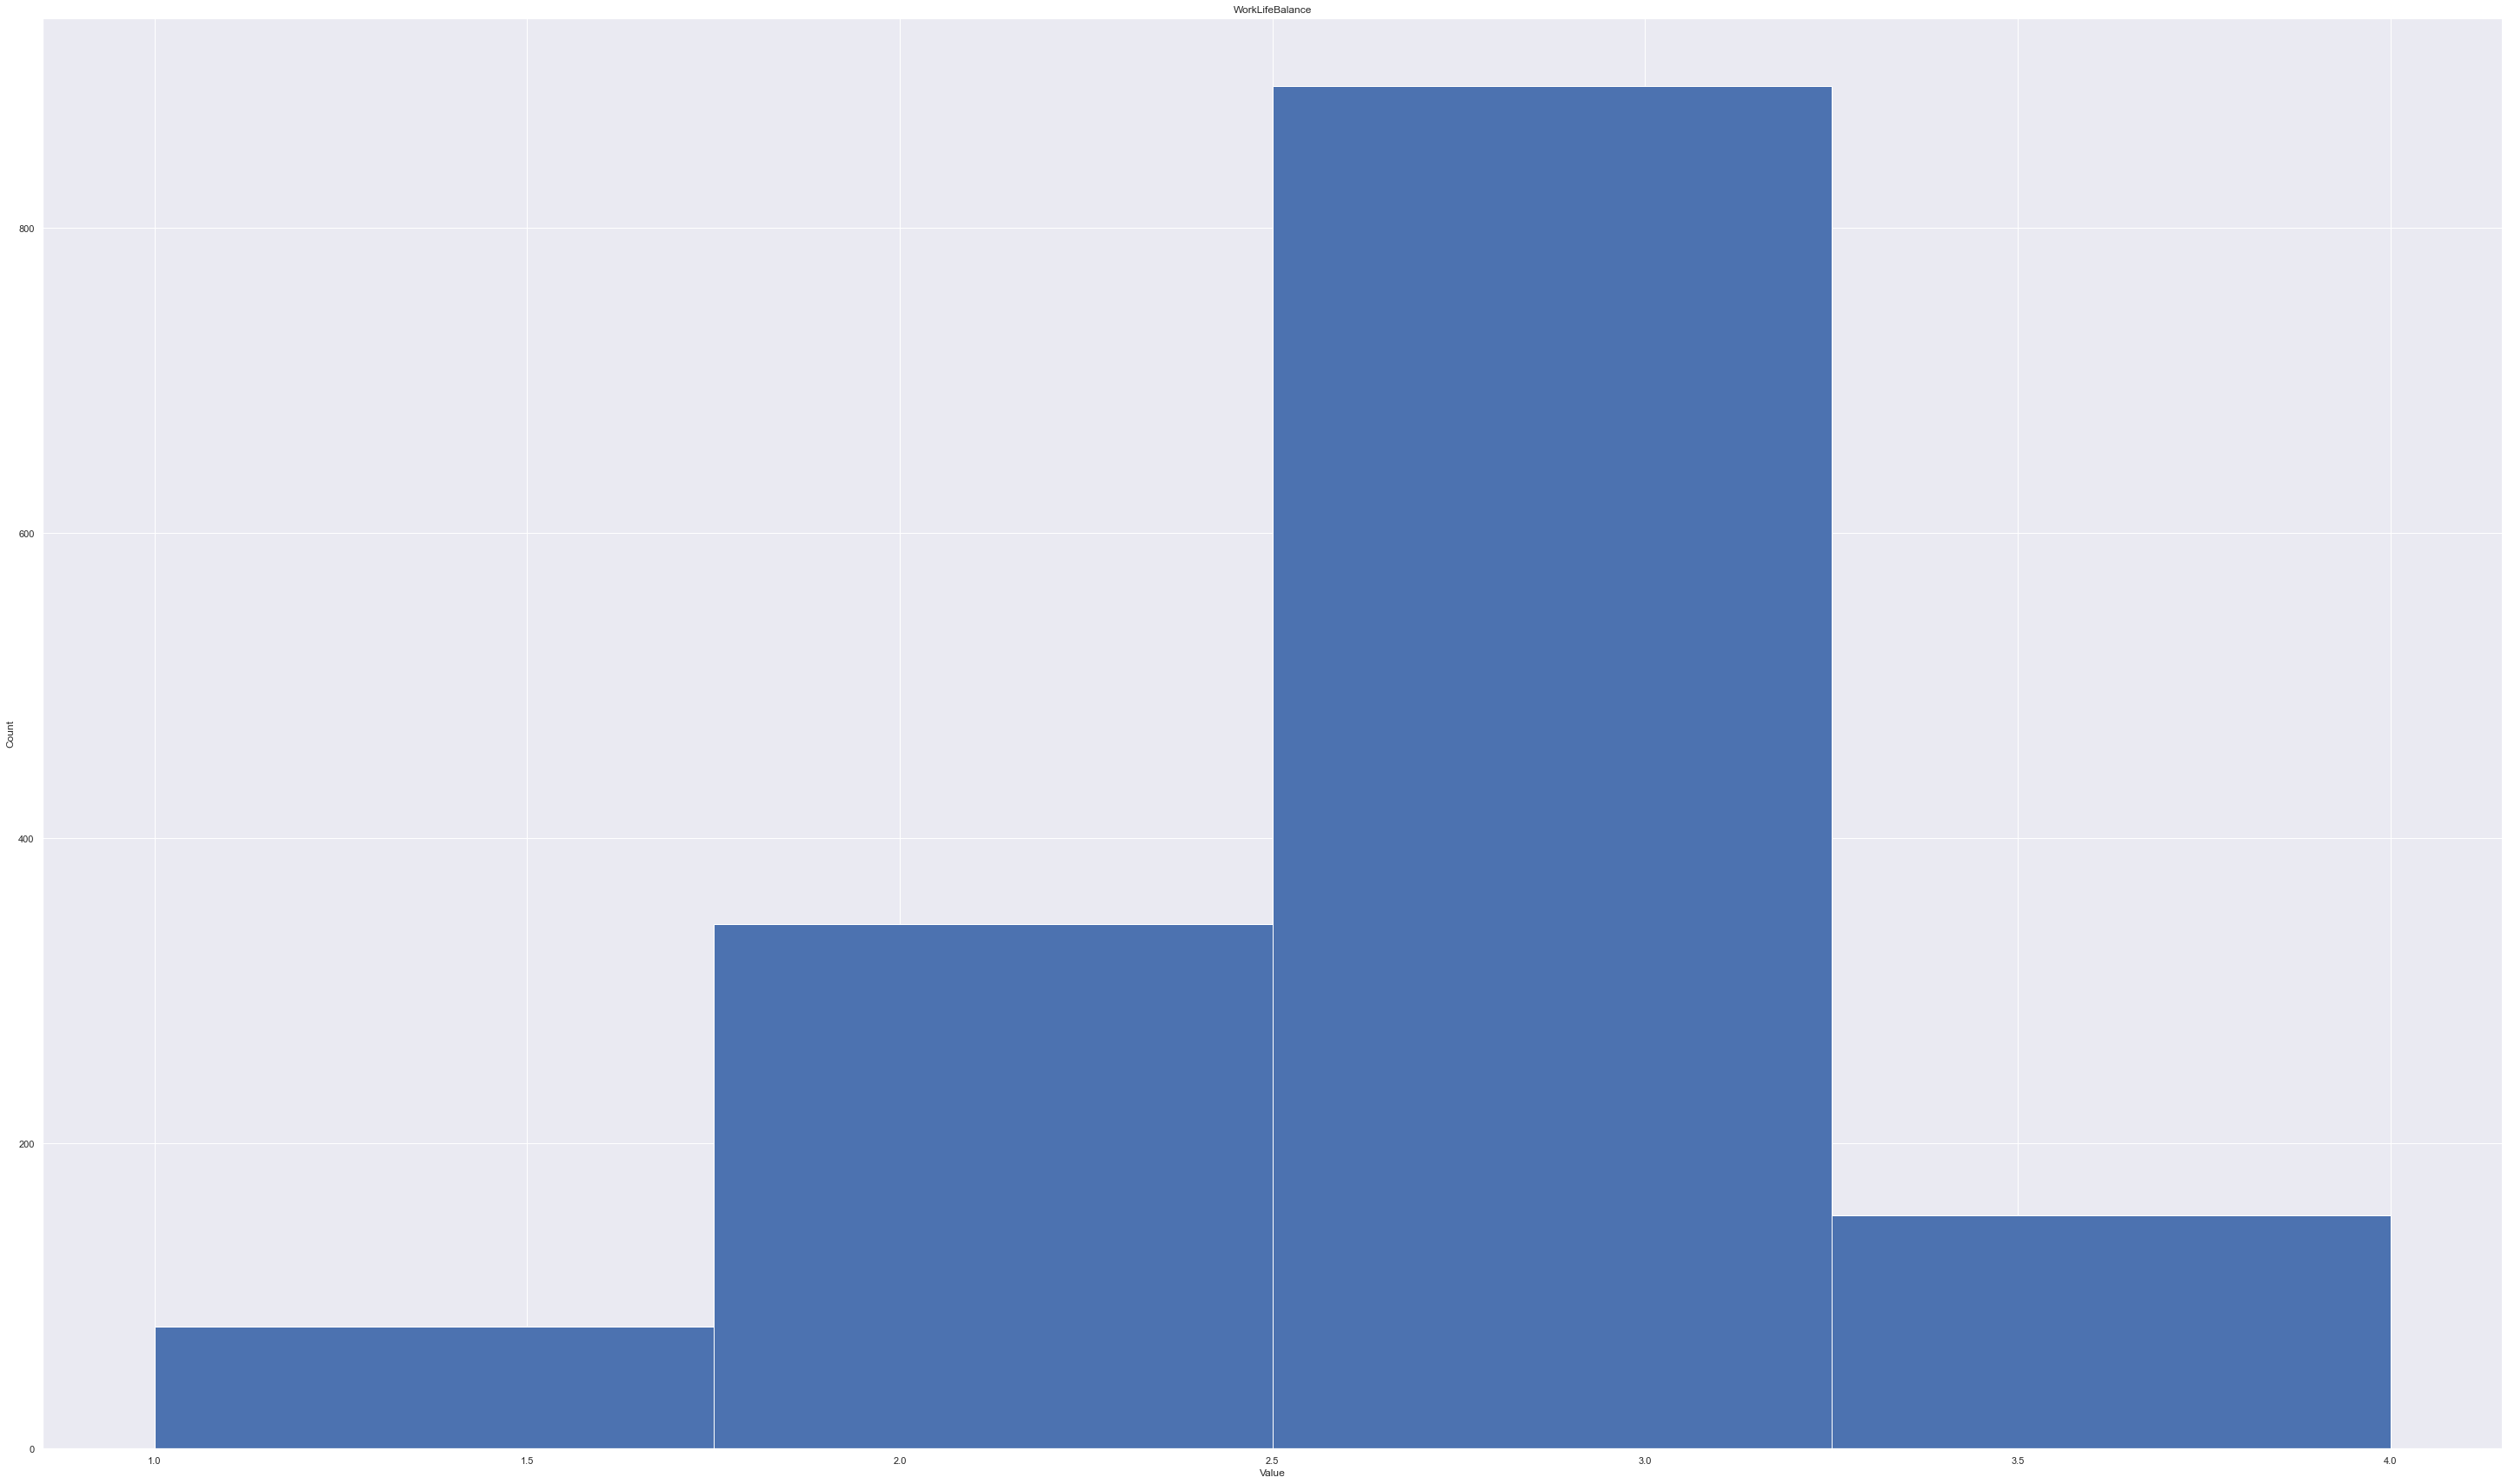

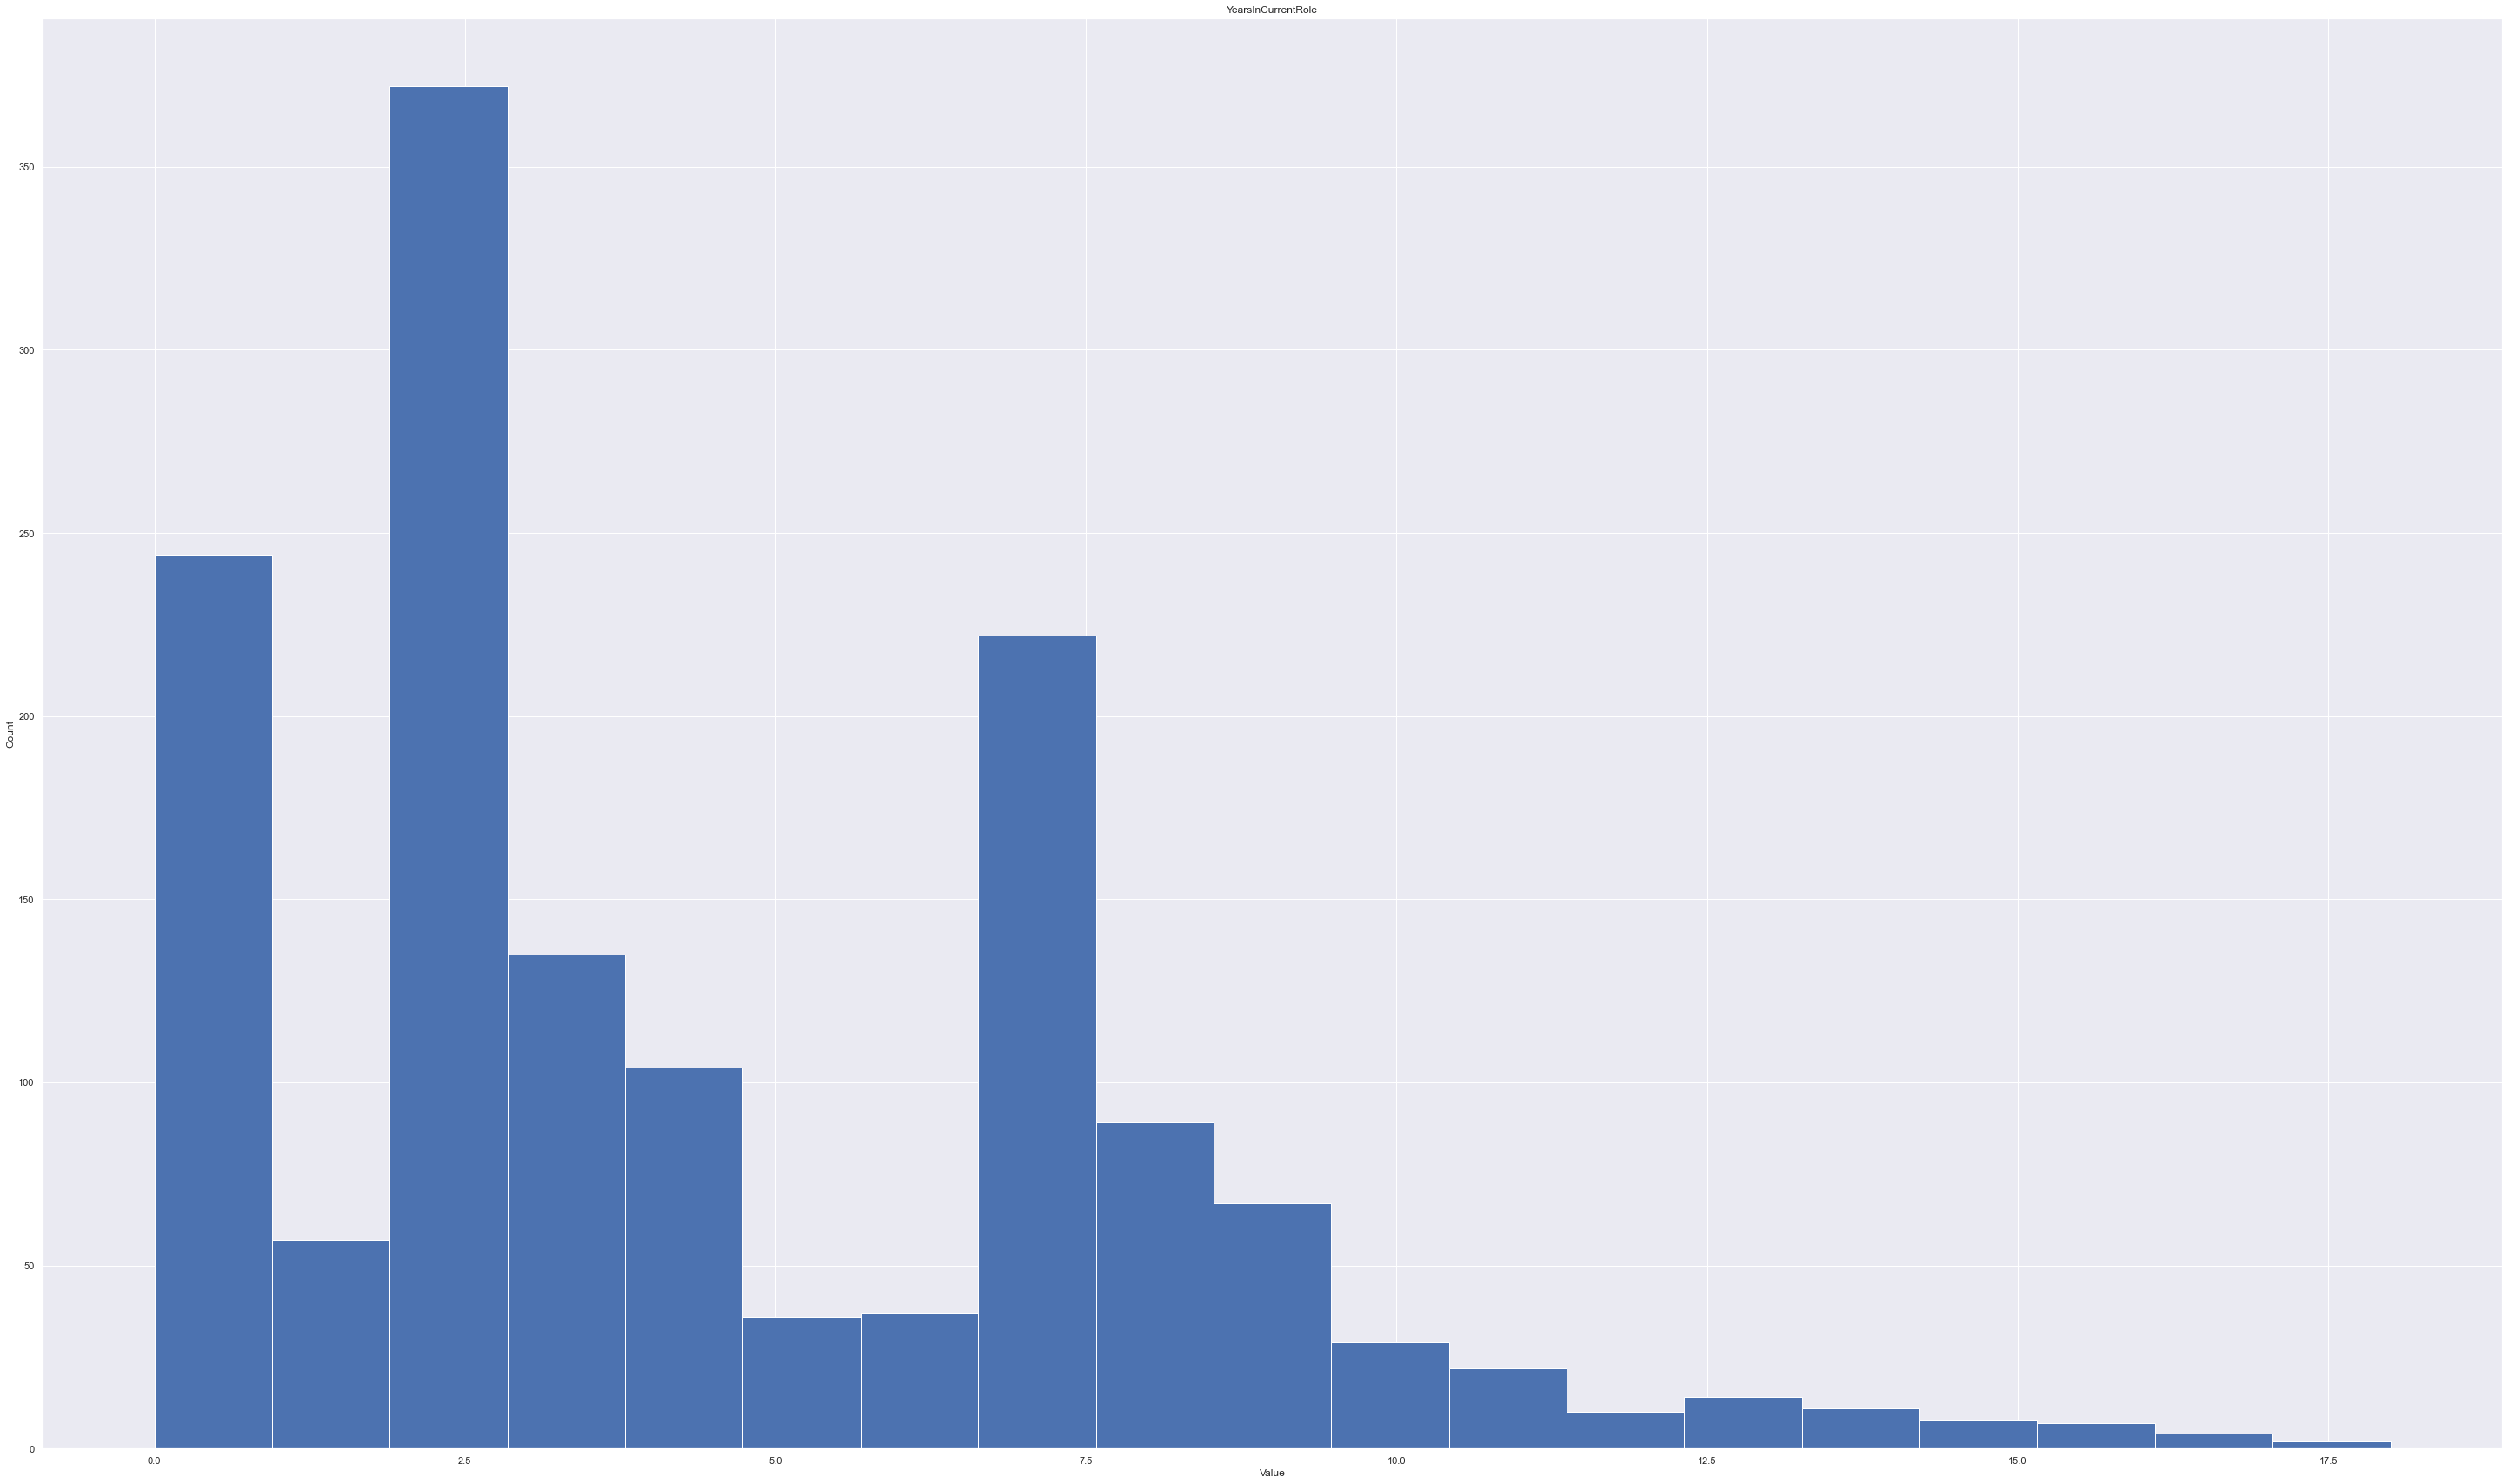

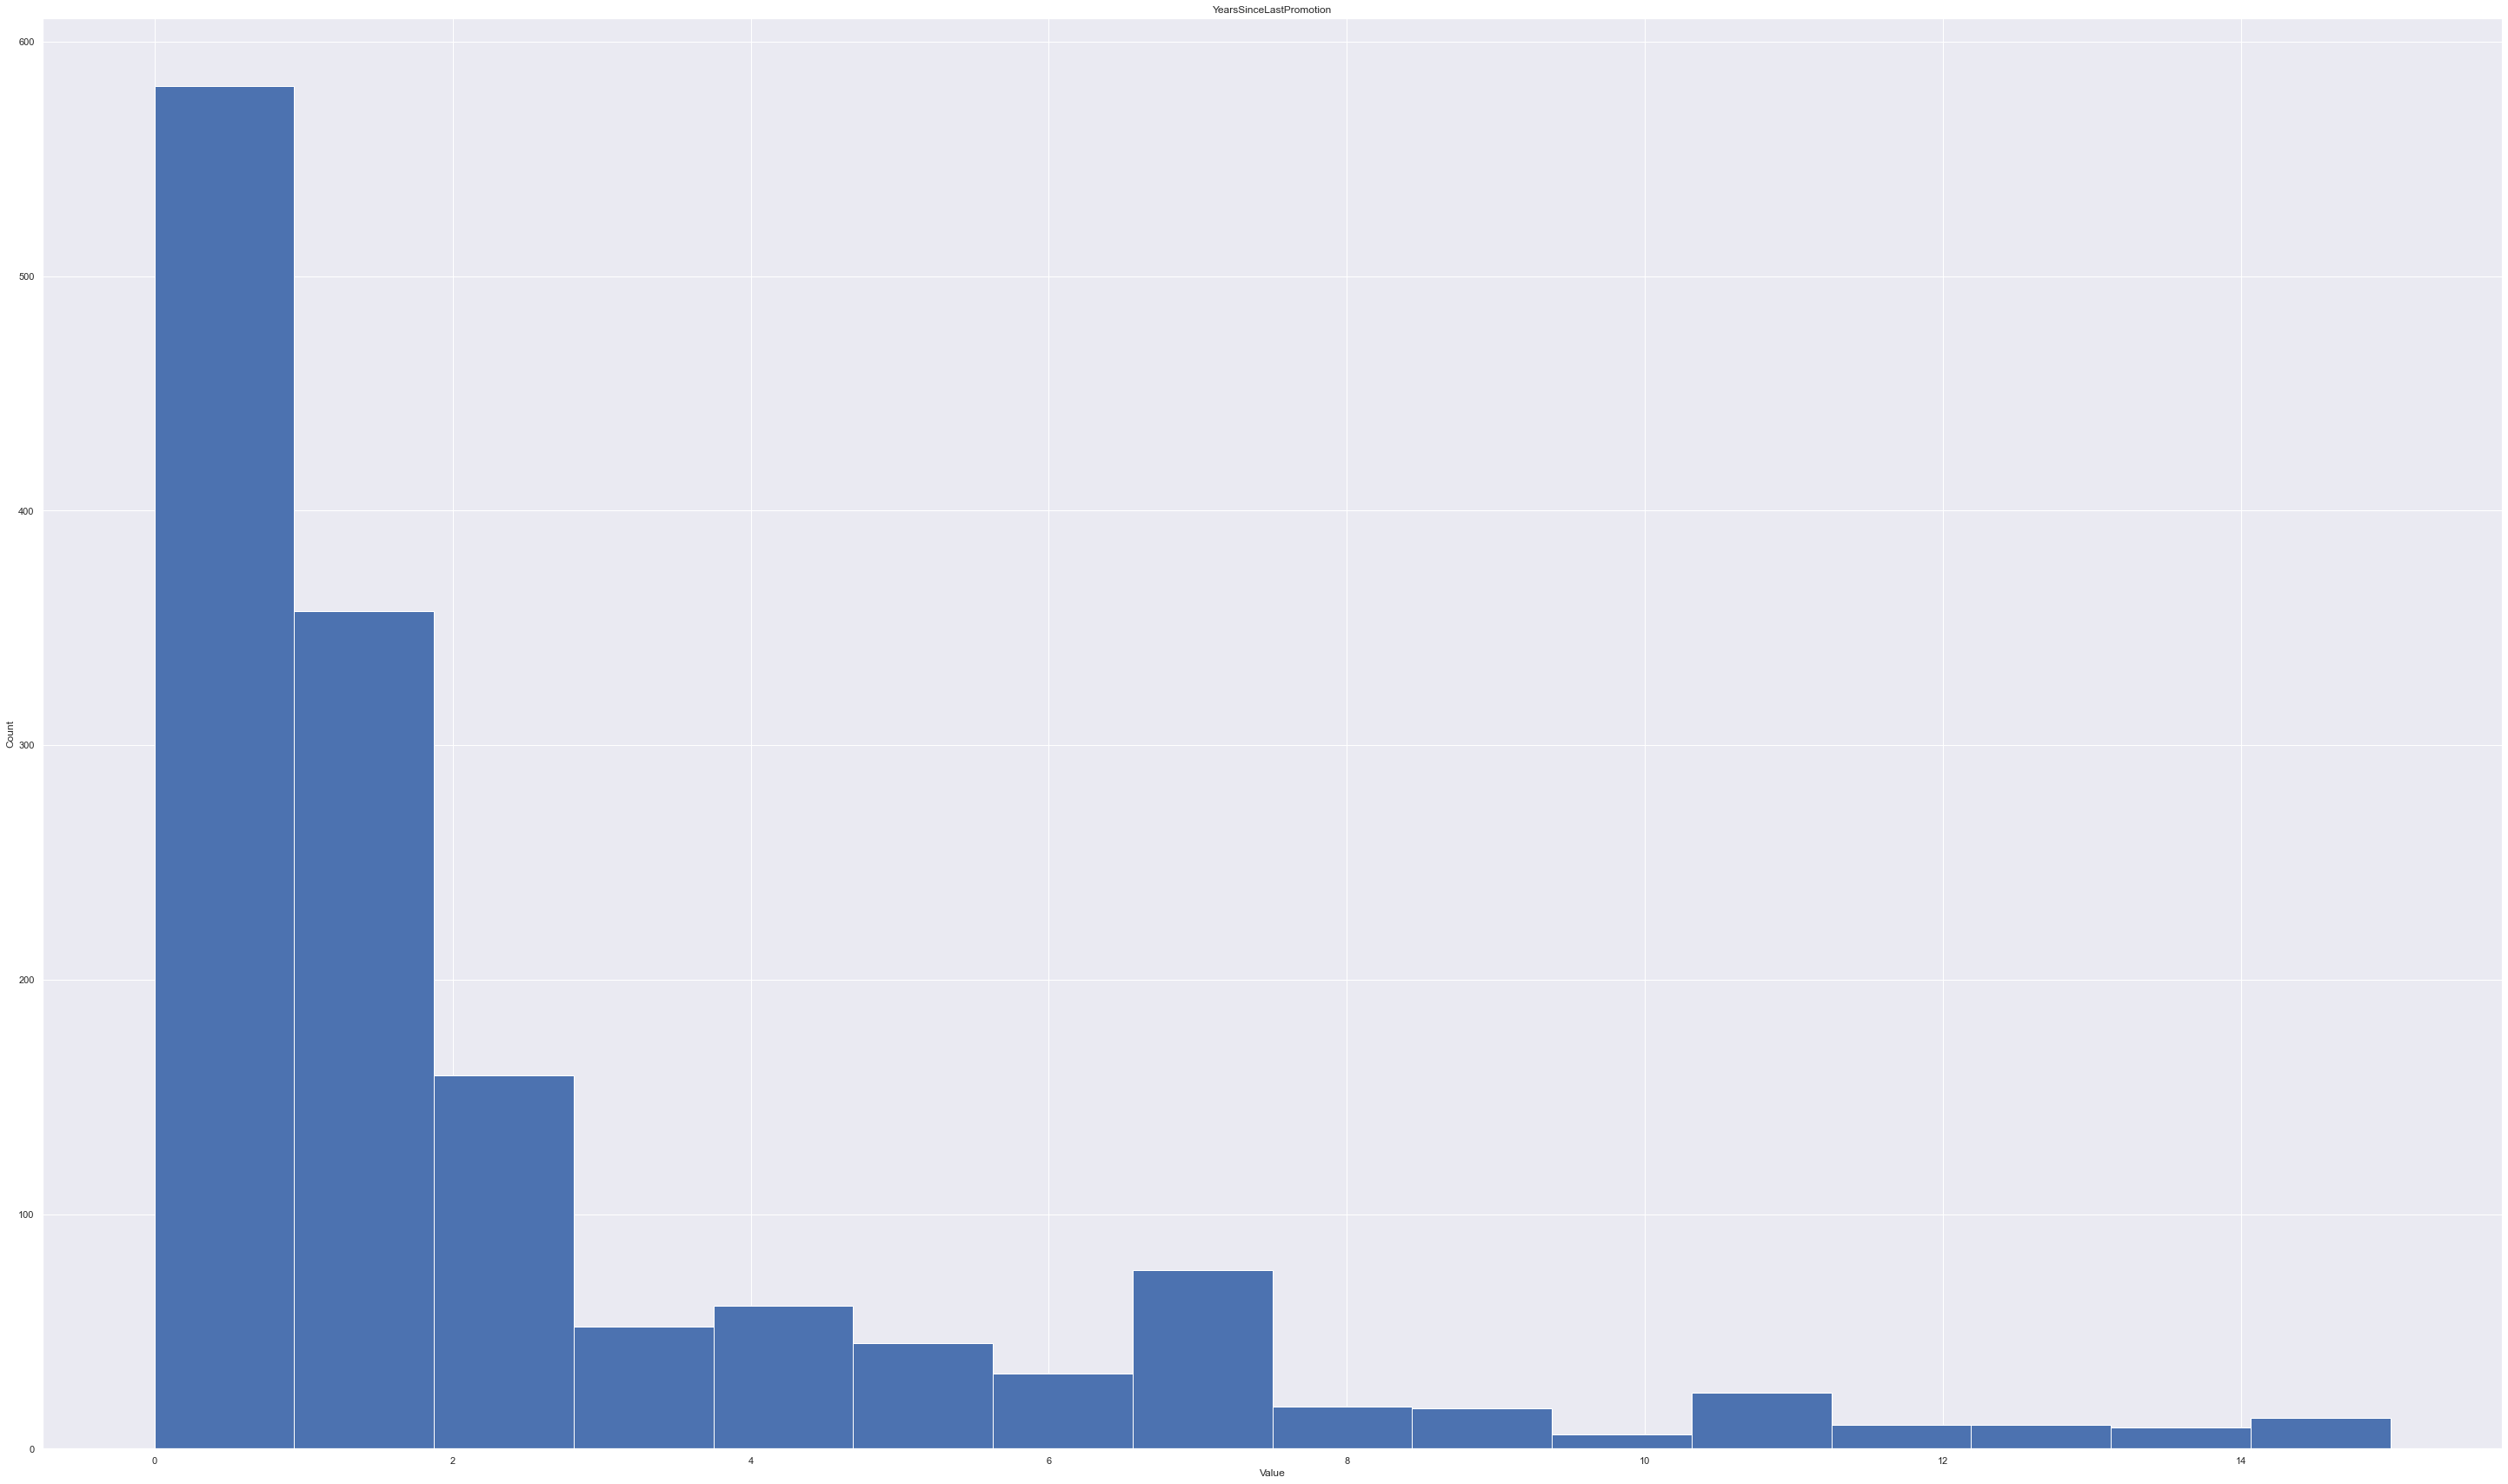

In [44]:
# гистограммы с циклом по всем признакам df
for i, bis in enumerate(list_atribut):
    plt.hist(df[bis], bins=(df[bis].nunique()))
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.title(bis)
    plt.show()

In [45]:
df1.Age.describe()
min_d = df1.Age.describe()['min']
q1 = df1.Age.describe()['25%']
med = df1.Age.describe()['50%']
q3 = df1.Age.describe()['75%']
max_d = df1.Age.describe()['max']


In [46]:
# Ящик с Усами по AGE
def box_moustache(data):
    
    min_d = data.describe()['min']
    q1 = data.describe()['25%']
    med = data.describe()['50%']
    q3 = data.describe()['75%']
    max_d = data.describe()['max']
    

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8, 8))
    
    
    ax1.text(0.5, 0.5, 'Текстовый блок', fontsize=12, ha='center')
    
    ax2.boxplot(data)
    ax2.set_ylabel('измени')
    ax2.set_title('Ящик с усами для признака')
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

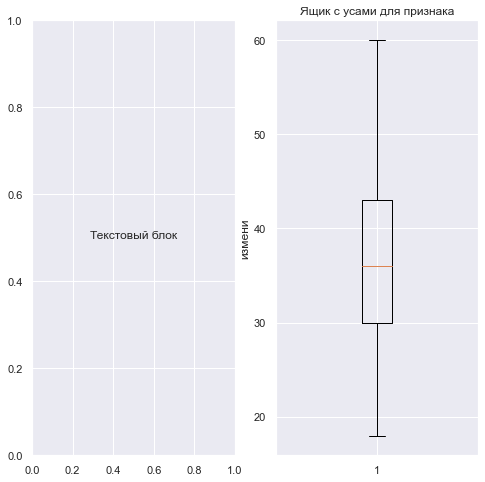

In [47]:
box_moustache(df1.Age)

## Выбросы 

In [52]:
# функция для определения интерквартильного размаха, количества/доли выбросов

def calculate_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (round((q25 - 1.5 * iqr), 0), round((q75 + 1.5 * iqr), 0))
    is_outlier = (data < boundaries[0]) | (data > boundaries[1])

    return boundaries, is_outlier.sum(), (is_outlier.sum()/len(data)*100).round(1)

In [53]:
# список числовых признаков

num_list = num_feat.to_list()
num_list

['Age',
 'DailyRate',
 'DistanceFromHome',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion']

In [54]:
# Для признаков с выбросами выводим данные согласно запросу 

for i in num_list:
    if (calculate_outliers(df1[i])[1]) > 0:
        print(f'Выбросы для признака: {i}')
        print(f'Границы для нормальных значений с интерквартильным размахом: {calculate_outliers(df1[i])[0]}')
        print(f'Количество выбросов: {calculate_outliers(df1[i])[1]}')
        print(f'Доля выбросов: {calculate_outliers(df1[i])[2]}%')
        print("----------------------------------------")


Выбросы для признака: MonthlyIncome
Границы для нормальных значений с интерквартильным размахом: (-5291.0, 16581.0)
Количество выбросов: 114
Доля выбросов: 7.8%
----------------------------------------
Выбросы для признака: NumCompaniesWorked
Границы для нормальных значений с интерквартильным размахом: (-4.0, 8.0)
Количество выбросов: 52
Доля выбросов: 3.5%
----------------------------------------
Выбросы для признака: StockOptionLevel
Границы для нормальных значений с интерквартильным размахом: (-2.0, 2.0)
Количество выбросов: 85
Доля выбросов: 5.8%
----------------------------------------
Выбросы для признака: TrainingTimesLastYear
Границы для нормальных значений с интерквартильным размахом: (0.0, 4.0)
Количество выбросов: 184
Доля выбросов: 12.5%
----------------------------------------
Выбросы для признака: YearsInCurrentRole
Границы для нормальных значений с интерквартильным размахом: (-6.0, 14.0)
Количество выбросов: 21
Доля выбросов: 1.4%
----------------------------------------

### Выявлены следующие признаки с выбросами. Данные с выбромаси принято решение не удалять  

## Моделирование 

In [13]:
# меняем тип данных чтоб закодировать как категориальный признак
df1['Education'] = df1['Education'].apply(lambda x: str(x))

In [14]:
# yes/no -----> меняем 1/0
df1['Attrition'] = df1['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

In [15]:
df1.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion
0,41,1,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,2,...,19479,8,Yes,11,1,0,0,1,4,0
1,49,0,Travel_Frequently,279,Research & Development,8,1,Life Sciences,2,3,...,24907,1,No,23,4,1,3,3,7,1
2,37,1,Travel_Rarely,1373,Research & Development,2,2,Other,4,4,...,2396,6,Yes,15,2,0,3,3,0,0
3,33,0,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,5,4,...,23159,1,Yes,11,3,0,3,3,7,3
4,27,0,Travel_Rarely,591,Research & Development,2,1,Medical,7,1,...,16632,9,No,12,4,1,3,3,2,2


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   int64 
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EmployeeNumber            1470 non-null   int64 
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

In [17]:
# делим данные на тренировочную и тестовую выборки.

In [18]:
x = df1.drop(columns=['Attrition','EmployeeNumber'])

In [19]:
y = df1['Attrition']

In [20]:
# делим выборки

In [101]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [102]:
# Категориальные

In [103]:
cat_feat = x_train.select_dtypes(include=object).columns

In [104]:
cat_feat

Index(['BusinessTravel', 'Department', 'Education', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'OverTime'],
      dtype='object')

In [105]:
x_train_cat_feat = x_train[cat_feat]
x_train_cat_feat 

,BusinessTravel,Department,Education,EducationField,Gender,JobRole,MaritalStatus,OverTime
1097,Travel_Rarely,Research & Development,2,Technical Degree,Male,Laboratory Technician,Divorced,No
727,Non-Travel,Research & Development,2,Life Sciences,Male,Research Scientist,Single,No
254,Travel_Rarely,Sales,2,Marketing,Male,Sales Executive,Divorced,No
1175,Travel_Rarely,Research & Development,3,Medical,Male,Manufacturing Director,Married,No
1341,Travel_Rarely,Research & Development,3,Life Sciences,Male,Laboratory Technician,Divorced,No
...,...,...,...,...,...,...,...,...
1130,Travel_Rarely,Research & Development,3,Life Sciences,Male,Laboratory Technician,Married,No
1294,Travel_Rarely,Research & Development,3,Life Sciences,Male,Healthcare Representative,Single,No
860,Travel_Frequently,Research & Development,4,Life Sciences,Male,Research Scientist,Married,Yes
1459,Travel_Rarely,Research & Development,2,Other,Male,Laboratory Technician,Married,Yes


In [106]:
x_test_cat_feat = x_test[cat_feat]
x_test_cat_feat 

,BusinessTravel,Department,Education,EducationField,Gender,JobRole,MaritalStatus,OverTime
1041,Travel_Rarely,Sales,3,Medical,Male,Sales Executive,Single,No
184,Travel_Rarely,Research & Development,2,Medical,Female,Manufacturing Director,Divorced,No
1222,Travel_Rarely,Human Resources,1,Human Resources,Male,Human Resources,Married,No
67,Travel_Rarely,Research & Development,3,Life Sciences,Male,Research Scientist,Divorced,No
220,Travel_Rarely,Research & Development,2,Life Sciences,Male,Laboratory Technician,Single,No
...,...,...,...,...,...,...,...,...
567,Travel_Rarely,Sales,3,Other,Male,Sales Executive,Single,No
560,Travel_Rarely,Research & Development,5,Life Sciences,Female,Manufacturing Director,Divorced,No
945,Travel_Rarely,Research & Development,3,Life Sciences,Female,Research Director,Married,Yes
522,Travel_Rarely,Research & Development,2,Life Sciences,Male,Research Scientist,Single,No


In [107]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [108]:
x_train_cat_feat = ohe.fit_transform(x_train_cat_feat)

C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [109]:
x_test_cat_feat = ohe.transform(x_test_cat_feat)

In [110]:
x_train_cat_feat = pd.DataFrame(x_train_cat_feat, columns=ohe.get_feature_names_out())
x_train_cat_feat

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1172,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1173,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1174,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [111]:
x_test_cat_feat = pd.DataFrame(x_test_cat_feat, columns=ohe.get_feature_names_out())
x_test_cat_feat

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
290,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
291,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
292,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [112]:
# числовые признаки в тренировочной и тестовой выборках к передаче в модель

In [113]:
num_feat = x_train.select_dtypes(exclude=object).columns
num_feat

Index(['Age', 'DailyRate', 'DistanceFromHome', 'EnvironmentSatisfaction',
       'HourlyRate', 'JobInvolvement', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'RelationshipSatisfaction', 'StockOptionLevel', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsInCurrentRole', 'YearsSinceLastPromotion'],
      dtype='object')

In [114]:
x_train_num_feat = x_train[num_feat]
x_test_num_feat = x_test[num_feat]

In [115]:
std_scaler = StandardScaler()
std_scaler

StandardScaler()

In [116]:
x_train_num_feat = std_scaler.fit_transform(x_train_num_feat)

In [117]:
x_test_num_feat = std_scaler.transform(x_test_num_feat)

In [118]:
x_train_num_feat = pd.DataFrame(x_train_num_feat, columns=num_feat)
x_train_num_feat

,Age,DailyRate,DistanceFromHome,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion
0,-1.388559,-1.108139,1.440396,0.279706,-0.472832,-1.012340,-1.582336,-0.868277,-0.601895,-1.059168,-0.339249,-0.639822,2.547471,0.157319,0.357435,-0.888208,-0.676110
1,-2.040738,-1.263481,-0.522699,-0.639104,0.309374,0.389912,1.152834,-1.132807,-0.115318,-0.659431,-0.066365,1.211176,-0.945525,-0.613546,0.357435,-1.165051,-0.676110
2,-0.845077,1.103647,1.317703,1.198515,-1.059487,0.389912,1.152834,0.116537,-0.503933,-0.259693,-0.339249,1.211176,0.218807,-0.613546,0.357435,-0.611364,-0.676110
3,0.241886,-0.758001,0.336155,1.198515,-0.032841,0.389912,-0.670613,-0.231070,-0.931675,0.539781,1.570943,0.285677,-0.945525,0.157319,0.357435,-0.057676,-0.355244
4,-0.627685,-1.204303,1.317703,-0.639104,1.091580,0.389912,0.241111,-0.464366,0.606876,-0.659431,-1.157903,-1.565321,0.218807,-0.613546,0.357435,1.049700,-0.676110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,-0.192899,-0.121835,2.299251,-0.639104,-1.010599,1.792164,0.241111,-0.632220,1.553287,-0.659431,0.479404,1.211176,1.383139,0.157319,-1.082099,1.326544,1.249084
1172,0.459279,-0.868960,-0.522699,-0.639104,0.896028,1.792164,-0.670613,0.103576,0.171392,0.140044,-0.885018,-1.565321,-0.945525,0.157319,-2.521633,-0.611364,-0.355244
1173,-1.605952,1.125839,-0.768086,0.279706,-0.912823,-1.012340,1.152834,-0.749930,-1.420082,-1.059168,-1.157903,-0.639822,0.218807,1.699050,0.357435,-1.165051,-0.676110
1174,-0.845077,1.426662,0.458849,1.198515,-1.010599,-1.012340,-0.670613,-0.500911,1.318373,0.539781,-0.612134,-1.565321,0.218807,-0.613546,0.357435,-0.334520,-0.676110


In [119]:
x_test_num_feat = pd.DataFrame(x_test_num_feat, columns=num_feat)
x_test_num_feat

,Age,DailyRate,DistanceFromHome,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion
0,-0.953774,0.164193,-0.522699,1.198515,0.847140,0.389912,-1.582336,0.442046,1.291771,-1.059168,0.752289,1.211176,-0.945525,0.928185,0.357435,-0.057676,-0.355244
1,1.763636,0.701729,0.458849,1.198515,-0.472832,1.792164,-1.582336,-0.410610,1.680245,-0.659431,-1.157903,0.285677,1.383139,0.157319,0.357435,-0.611364,-0.355244
2,-1.388559,-1.379372,1.563090,1.198515,-0.423944,-2.414593,0.241111,-1.025720,-0.383872,-0.659431,-1.157903,0.285677,0.218807,-0.613546,0.357435,-1.165051,-0.676110
3,0.894065,1.330497,-0.277312,-0.639104,-0.375056,0.389912,-1.582336,0.709975,0.629818,-0.259693,0.479404,0.285677,0.218807,-0.613546,0.357435,-1.165051,-0.676110
4,-0.084203,1.471045,-0.522699,1.198515,-0.228393,0.389912,-0.670613,-0.099549,-0.614704,2.138731,0.206520,1.211176,-0.945525,0.157319,1.796970,1.880231,0.286487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,-0.301596,-1.221563,-0.890780,1.198515,-0.326169,0.389912,1.152834,-0.023058,0.615603,-0.659431,1.843827,0.285677,-0.945525,1.699050,0.357435,0.219168,-0.355244
290,-0.301596,-1.559372,-0.154619,-0.639104,-1.695029,0.389912,-1.582336,-0.268040,-1.425149,0.140044,-0.339249,0.285677,0.218807,0.157319,0.357435,-1.165051,-0.676110
291,1.437547,1.288579,2.299251,1.198515,-1.157262,0.389912,-1.582336,2.230434,1.141449,0.539781,-1.157903,-0.639822,-0.945525,-0.613546,0.357435,-0.611364,-0.355244
292,0.024494,1.049401,0.090768,1.198515,0.651589,1.792164,1.152834,-0.361741,0.129448,0.140044,0.479404,-1.565321,-0.945525,-0.613546,0.357435,-1.165051,-0.676110


In [120]:
x_train1 = pd.concat([x_train_cat_feat, x_train_num_feat], axis=1)
x_train1

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,...,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.868277,-0.601895,-1.059168,-0.339249,-0.639822,2.547471,0.157319,0.357435,-0.888208,-0.676110
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-1.132807,-0.115318,-0.659431,-0.066365,1.211176,-0.945525,-0.613546,0.357435,-1.165051,-0.676110
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.116537,-0.503933,-0.259693,-0.339249,1.211176,0.218807,-0.613546,0.357435,-0.611364,-0.676110
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.231070,-0.931675,0.539781,1.570943,0.285677,-0.945525,0.157319,0.357435,-0.057676,-0.355244
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.464366,0.606876,-0.659431,-1.157903,-1.565321,0.218807,-0.613546,0.357435,1.049700,-0.676110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-0.632220,1.553287,-0.659431,0.479404,1.211176,1.383139,0.157319,-1.082099,1.326544,1.249084
1172,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.103576,0.171392,0.140044,-0.885018,-1.565321,-0.945525,0.157319,-2.521633,-0.611364,-0.355244
1173,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-0.749930,-1.420082,-1.059168,-1.157903,-0.639822,0.218807,1.699050,0.357435,-1.165051,-0.676110
1174,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.500911,1.318373,0.539781,-0.612134,-1.565321,0.218807,-0.613546,0.357435,-0.334520,-0.676110


In [121]:
x_test1 = pd.concat([x_test_cat_feat, x_test_num_feat], axis=1)
x_test1

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,Education_1,Education_2,Education_3,Education_4,...,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsInCurrentRole,YearsSinceLastPromotion
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.442046,1.291771,-1.059168,0.752289,1.211176,-0.945525,0.928185,0.357435,-0.057676,-0.355244
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.410610,1.680245,-0.659431,-1.157903,0.285677,1.383139,0.157319,0.357435,-0.611364,-0.355244
2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-1.025720,-0.383872,-0.659431,-1.157903,0.285677,0.218807,-0.613546,0.357435,-1.165051,-0.676110
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.709975,0.629818,-0.259693,0.479404,0.285677,0.218807,-0.613546,0.357435,-1.165051,-0.676110
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.099549,-0.614704,2.138731,0.206520,1.211176,-0.945525,0.157319,1.796970,1.880231,0.286487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,-0.023058,0.615603,-0.659431,1.843827,0.285677,-0.945525,1.699050,0.357435,0.219168,-0.355244
290,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.268040,-1.425149,0.140044,-0.339249,0.285677,0.218807,0.157319,0.357435,-1.165051,-0.676110
291,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,2.230434,1.141449,0.539781,-1.157903,-0.639822,-0.945525,-0.613546,0.357435,-0.611364,-0.355244
292,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-0.361741,0.129448,0.140044,0.479404,-1.565321,-0.945525,-0.613546,0.357435,-1.165051,-0.676110


# Modeling

In [130]:
import lightgbm as lgb

In [135]:
models_result_test_data = dict() 
models = [
    LogisticRegression(class_weight='balanced'),
    lgb.LGBMClassifier(class_weight='balanced'),
    MLPClassifier(hidden_layer_sizes=(5), random_state=42, max_iter=500),
    SVC(C=7.0, probability=True, class_weight='balanced'),
    GradientBoostingClassifier(),
    CatBoostClassifier(iterations=200,learning_rate=0.15, auto_class_weights='Balanced')
]

for m in models:
    dict_temp = []
    model = m
    m.fit(x_train1, y_train)
    predict_train = m.predict(x_train1)
    predict_test = m.predict(x_test1)
    acc_tr = accuracy_score(y_train, predict_train)
    dict_temp.append(accuracy_score(y_test, predict_test))
    
    prob = m.predict_proba(x_test1)
    prob = prob[:, 1]
    dict_temp.append(roc_auc_score(y_test, prob))
    
    dict_temp.append(precision_score(y_test, predict_test))
    dict_temp.append(recall_score(y_test, predict_test))
    dict_temp.append(f1_score(y_test, predict_test))
    models_result_test_data[type(model).__name__] = dict_temp
    
    
    

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 198, number of negative: 978
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1077
[LightGBM] [Info] Number of data points in the train set: 1176, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


0:	learn: 0.6399974	total: 3.12ms	remaining: 621ms
1:	learn: 0.6003113	total: 6.04ms	remaining: 598ms
2:	learn: 0.5682350	total: 8.69ms	remaining: 571ms
3:	learn: 0.5497136	total: 11.7ms	remaining: 573ms
4:	learn: 0.5306504	total: 14.2ms	remaining: 554ms
5:	learn: 0.5131142	total: 16.8ms	remaining: 543ms
6:	learn: 0.4930621	total: 19.9ms	remaining: 550ms
7:	learn: 0.4775570	total: 23.4ms	remaining: 562ms
8:	learn: 0.4678338	total: 26.1ms	remaining: 554ms
9:	learn: 0.4544154	total: 28.9ms	remaining: 549ms
10:	learn: 0.4436054	total: 32.1ms	remaining: 552ms
11:	learn: 0.4354198	total: 35ms	remaining: 549ms
12:	learn: 0.4238443	total: 37.5ms	remaining: 540ms
13:	learn: 0.4140676	total: 40.3ms	remaining: 535ms
14:	learn: 0.4014528	total: 42.7ms	remaining: 527ms
15:	learn: 0.3946382	total: 45.4ms	remaining: 522ms
16:	learn: 0.3846821	total: 48.3ms	remaining: 520ms
17:	learn: 0.3765522	total: 51.2ms	remaining: 517ms
18:	learn: 0.3640502	total: 53.9ms	remaining: 513ms
19:	learn: 0.3596090	tot

In [136]:
models_result_test_data

{'LogisticRegression': [0.7312925170068028,
  0.7723479135243843,
  0.2777777777777778,
  0.6410256410256411,
  0.3875968992248062],
 'LGBMClassifier': [0.8673469387755102,
  0.7939668174962293,
  0.5,
  0.3333333333333333,
  0.4],
 'MLPClassifier': [0.8605442176870748,
  0.7527400703871293,
  0.47368421052631576,
  0.46153846153846156,
  0.4675324675324675],
 'SVC': [0.8639455782312925,
  0.7926596279537457,
  0.48148148148148145,
  0.3333333333333333,
  0.3939393939393939],
 'GradientBoostingClassifier': [0.8639455782312925,
  0.779185520361991,
  0.47058823529411764,
  0.20512820512820512,
  0.28571428571428564],
 'CatBoostClassifier': [0.8707482993197279,
  0.7803921568627451,
  0.52,
  0.3333333333333333,
  0.40625000000000006]}

In [137]:
models_result_test_data_tbl = pd.DataFrame.from_dict(models_result_test_data, orient='index',
                       columns=['accuracy_score', 'roc_auc_score', 'precision_score', 'recall_score','f1_score'])

In [138]:
models_result_test_data_tbl

,accuracy_score,roc_auc_score,precision_score,recall_score,f1_score
LogisticRegression,0.731293,0.772348,0.277778,0.641026,0.387597
LGBMClassifier,0.867347,0.793967,0.500000,0.333333,0.400000
MLPClassifier,0.860544,0.752740,0.473684,0.461538,0.467532
SVC,0.863946,0.792660,0.481481,0.333333,0.393939
GradientBoostingClassifier,0.863946,0.779186,0.470588,0.205128,0.285714
CatBoostClassifier,0.870748,0.780392,0.520000,0.333333,0.406250


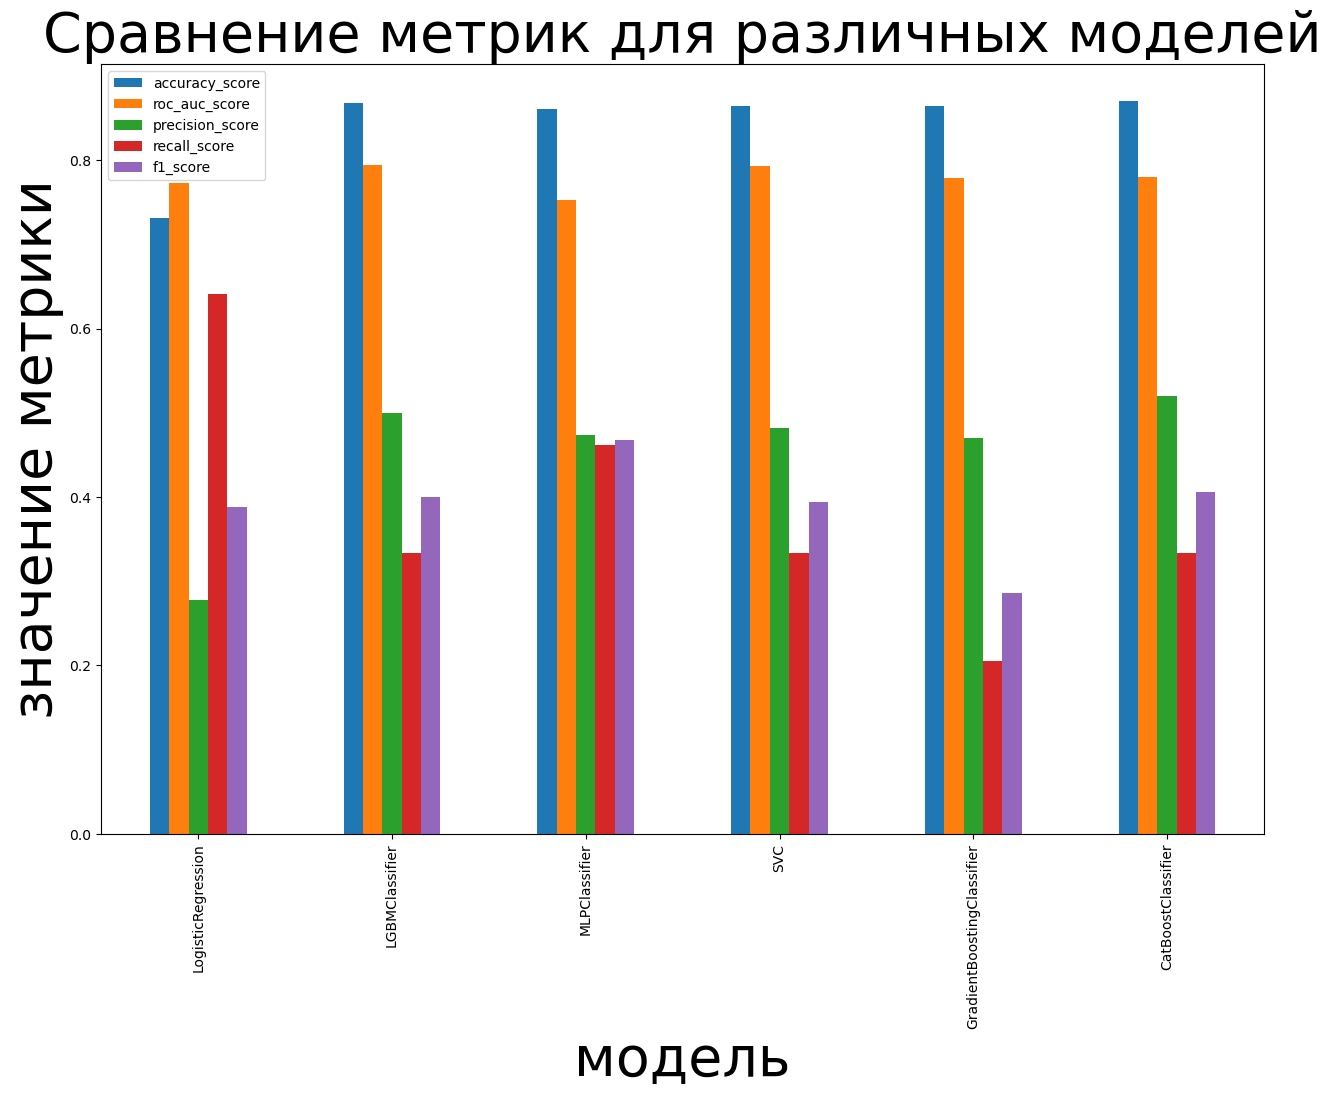

In [146]:
models_result_test_data_tbl.plot(figsize=(15,10), kind='bar')
plt.title('Cравнение метрик для различных моделей', fontsize=40)
plt.xlabel('модель', fontsize=40);
plt.ylabel('значение метрики', fontsize=40);


### Вывод: По метрике accuracy_score лучшая модель CatBoostClassifier, но наша задача выявить сотрудников с "ВЫГОРАНИЕМ".
### Исходя из поставленой задачи, нас итересеует метрика recall_score, поскольку нам важно вовремя выявить сотрудника который хочет уволиться, чтоб принять соответвующие меры.    

### По метрике recall_score наилучая модель LogisticRegression 0,64, хотя accuracy_score ниже

In [147]:
## GridSearchCV на LogisticRegression по метрике recall_score (Согласно ТЗ на лучшей модели по accuracy_score)

In [147]:
model_L = LogisticRegression(class_weight='balanced')

In [148]:
param_grid =  {
    'penalty': ['l1', 'l2'],  # Тип регуляризации - L1 или L2
    'C': [0.1, 1, 10, 100],  # Обратный коэффициент регуляризации
    'fit_intercept': [True, False],  # Использовать ли константу в модели
    'solver': ['liblinear', 'saga']  # Алгоритм оптимизации
}

In [149]:
scorer = make_scorer(recall_score)

In [150]:
grid_search = GridSearchCV(estimator=model_L, param_grid=param_grid, scoring=scorer)

In [151]:
grid_search.fit(x_train1, y_train)

C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Zaraz\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
             param_grid={'C': [0.1, 1, 10, 100], 'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring=make_scorer(recall_score))

In [160]:
y_pred = grid_search.predict(x_test1)

In [161]:
grid_search.best_params_

{'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'liblinear'}

In [162]:
grid_search.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [163]:
grid_search.best_score_

0.7623076923076922

In [164]:
grid_search.scorer_

make_scorer(recall_score)

In [165]:
accuracy_score(y_test, y_pred)

0.7448979591836735

In [166]:
recall_score_grid = recall_score(y_test, y_pred)
recall_score_grid

0.6666666666666666

In [167]:
confusion_matrix(y_test, yyyy_pred)

array([[193,  62],
       [ 13,  26]], dtype=int64)

### Вывод: в конкретном случае GridSearchCV оказал незначительное положительного влияние на модель по метрике recall

# Заключение:

## Несмотря на accuracy_score который ниже, по метрике recall_score для нашей задачи лучше всего подходит LogisticRegression. Поскольку в конкретном случае важно вовремя выявить сотрудников которые изменить место работы.

## С помощью ML  возможно создать кадровый резерв заранее. Классифицируя и выявляя наиболее лояльных и эффективных сотрудников. 